# RESULTS Poker DVS

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tonic, torch, os
from hots.network import network
from hots.utils import apply_jitter, get_loader, make_histogram_classification, HOTS_Dataset, fit_mlr, predict_mlr, score_classif_events, online_accuracy
import numpy as np

print(f'Tonic version installed -> {tonic.__version__}')

print(f'Number of GPU devices available: {torch.cuda.device_count()}')
for N_gpu in range(torch.cuda.device_count()):
    print(f'GPU {N_gpu+1} named {torch.cuda.get_device_name(N_gpu)}')

device = 'cpu'
#record_path = '/envau/work/neopto/USERS/GRIMALDI/HOTS/hotsline/Records/'
record_path = '../Records/' #-> default if not mentionned

Tonic version installed -> 1.0.19
Number of GPU devices available: 1
GPU 1 named GeForce RTX 2080 Ti


## Loading of the dataset for the clustering phase

In [3]:
kfold = None

type_transform = tonic.transforms.NumpyAsType(int)
trainset = tonic.datasets.POKERDVS(save_to='../../Data/', train=True, transform=type_transform)
testset = tonic.datasets.POKERDVS(save_to='../../Data/', train=False, transform=type_transform)
loader = get_loader(trainset)
trainloader = get_loader(trainset)
testloader = get_loader(testset)
num_sample_train = len(trainloader)
num_sample_test = len(testloader)
n_classes = len(testset.classes)
print(f'number of samples in the training set: {len(trainloader)}')
print(f'number of samples in the testing set: {len(testloader)}')

number of samples in the training set: 48
number of samples in the testing set: 20


## Initialization of the network

In [4]:
name = 'homeohots'
homeo = True
timestr = '2022-06-10'
dataset_name = 'poker'

Rz = [2, 4]
N_neuronz = [8, 16]
tauz = [1e4, 4e4]

hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo, record_path = record_path, device = device)

initial_name = hots.name

name_nohomeo = 'hots'
hots_nohomeo = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = False, record_path = record_path, device = device)

initial_name_nohomeo = hots_nohomeo.name

## Unsupervised clustering (Figure 4)

In [ ]:
if not os.path.exists(hots.record_path):
    os.mkdir(hots.record_path)
    os.mkdir(hots.record_path+'networks/')
path = hots.record_path+'networks/'+hots.name+'.pkl'
if not os.path.exists(path):
    hots.clustering(loader, trainset.ordering, device = device)
path_nohomeo = hots.record_path+'networks/'+hots_nohomeo.name+'.pkl'
if not os.path.exists(path_nohomeo):
    hots_nohomeo.clustering(loader, trainset.ordering, device = device)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [01:02<00:00,  1.29s/it]


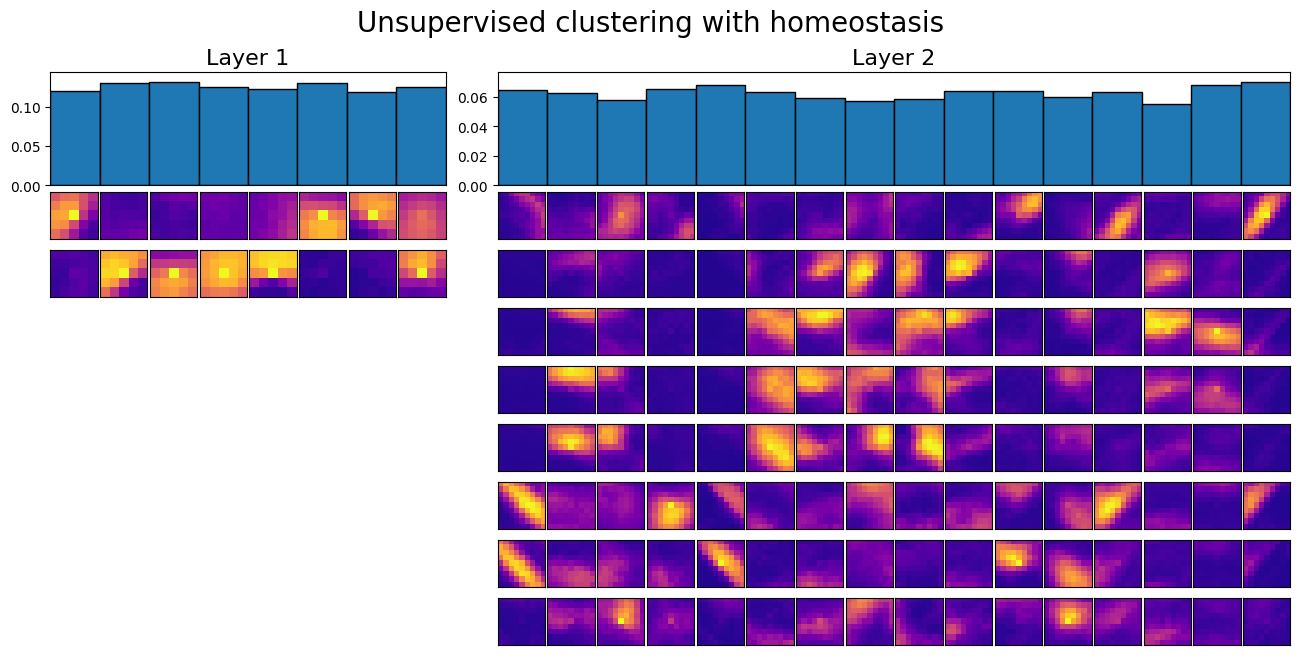

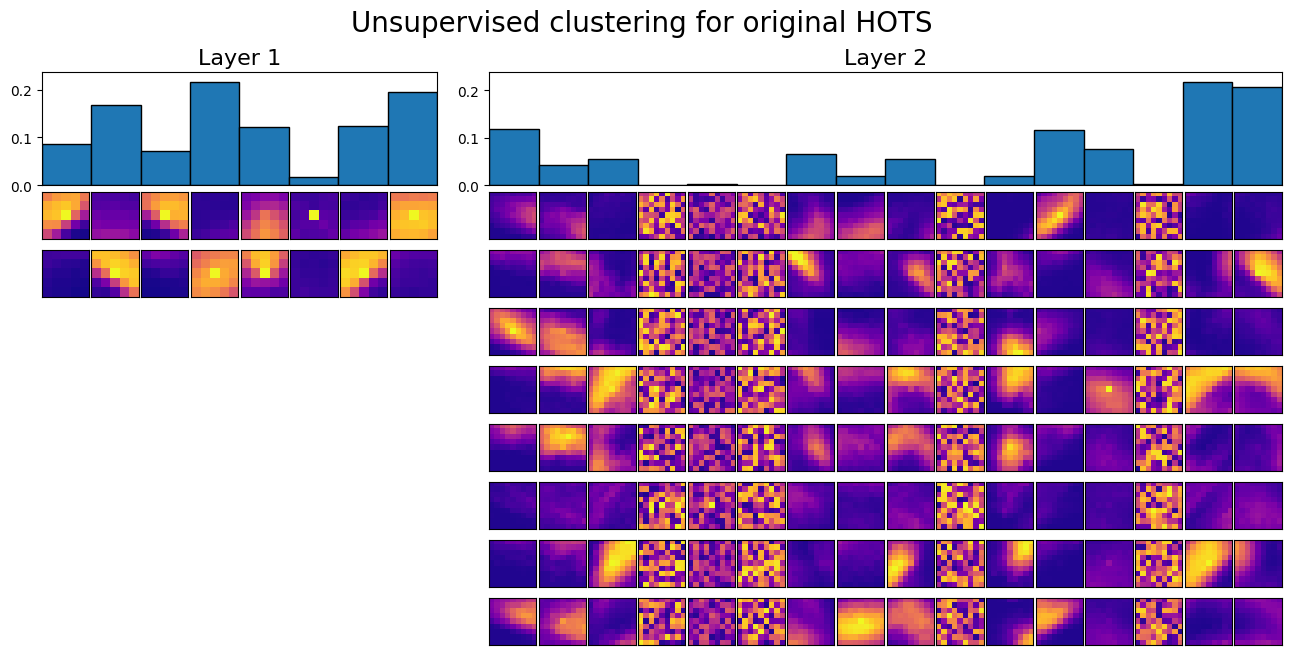

In [ ]:
hots.plotlayers();
hots_nohomeo.plotlayers();

## Training of the classification layer

In [ ]:
jitter = (None, None)
num_workers = 0
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 5 + 1
N_output_neurons = N_neuronz[-1]
ts_size = (trainset.sensor_size[0],trainset.sensor_size[1],N_output_neurons)
tau_cla = 3e4

train_path = f'{hots.record_path}output/train/{hots.name}_{num_sample_train}_{jitter}/'
test_path = f'{hots.record_path}output/test/{hots.name}_{num_sample_test}_{jitter}/'
model_path = f'{hots.record_path}networks/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'
results_path = f'{hots.record_path}LR_results/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'

hots.coding(trainloader, trainset.ordering, trainset.classes, training=True, device=device, verbose=False)
hots.coding(testloader, trainset.ordering, trainset.classes, training=False, device=device, verbose=False)

trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)
trainoutputloader = get_loader(trainset_output)
testset_output = HOTS_Dataset(test_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)
testoutputloader = get_loader(testset_output)

classif_layer, losses = fit_mlr(trainoutputloader, model_path, tau_cla, learning_rate, betas, num_epochs, ts_size, trainset.ordering, len(trainset.classes))

hots_nohomeo.coding(trainloader, trainset.ordering, trainset.classes, training=True, device=device, verbose=False)

train_path_nohomeo = f'{hots.record_path}output/train/{hots_nohomeo.name}_{num_sample_train}_{jitter}/'
test_path_nohomeo = f'{hots.record_path}output/test/{hots_nohomeo.name}_{num_sample_test}_{jitter}/'

trainset_output_nohomeo = HOTS_Dataset(train_path_nohomeo, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)

hots_nohomeo.coding(testloader, testset.ordering, testset.classes, training=False, jitter=jitter, device=device, verbose=False)
testset_output_nohomeo = HOTS_Dataset(test_path_nohomeo, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.16it/s]


device -> cuda


  3%|███████                                                                                                                                                                                                                                   | 1/33 [00:27<14:46, 27.72s/it]

Loss for epoch number 0: 3.94


  6%|██████████████▏                                                                                                                                                                                                                           | 2/33 [00:55<14:19, 27.71s/it]

Loss for epoch number 1: 3.545


  9%|█████████████████████▎                                                                                                                                                                                                                    | 3/33 [01:23<13:50, 27.68s/it]

Loss for epoch number 2: 3.528


 12%|████████████████████████████▎                                                                                                                                                                                                             | 4/33 [01:50<13:23, 27.72s/it]

Loss for epoch number 3: 3.503


 15%|███████████████████████████████████▍                                                                                                                                                                                                      | 5/33 [02:18<12:57, 27.78s/it]

Loss for epoch number 4: 3.474


 18%|██████████████████████████████████████████▌                                                                                                                                                                                               | 6/33 [02:46<12:31, 27.82s/it]

Loss for epoch number 5: 3.449


 21%|█████████████████████████████████████████████████▋                                                                                                                                                                                        | 7/33 [03:14<12:05, 27.92s/it]

Loss for epoch number 6: 3.427


 24%|████████████████████████████████████████████████████████▋                                                                                                                                                                                 | 8/33 [03:43<11:41, 28.06s/it]

Loss for epoch number 7: 3.408


 27%|███████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 9/33 [04:11<11:16, 28.18s/it]

Loss for epoch number 8: 3.392


 30%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                                                  | 10/33 [04:39<10:49, 28.24s/it]

Loss for epoch number 9: 3.377


 33%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 11/33 [05:08<10:22, 28.29s/it]

Loss for epoch number 10: 3.365


 36%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                    | 12/33 [05:36<09:54, 28.33s/it]

Loss for epoch number 11: 3.355


 39%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                             | 13/33 [06:04<09:25, 28.29s/it]

Loss for epoch number 12: 3.345


 42%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 14/33 [06:33<08:57, 28.27s/it]

Loss for epoch number 13: 3.337


 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 15/33 [07:01<08:27, 28.18s/it]

Loss for epoch number 14: 3.331


 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 16/33 [07:29<07:57, 28.11s/it]

Loss for epoch number 15: 3.325


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 17/33 [07:57<07:29, 28.06s/it]

Loss for epoch number 16: 3.319


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 18/33 [08:25<07:00, 28.03s/it]

Loss for epoch number 17: 3.314


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 19/33 [08:52<06:32, 28.02s/it]

Loss for epoch number 18: 3.31


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 20/33 [09:20<06:03, 27.98s/it]

Loss for epoch number 19: 3.305


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 21/33 [09:48<05:34, 27.92s/it]

Loss for epoch number 20: 3.302


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 22/33 [10:15<05:02, 27.46s/it]

Loss for epoch number 21: 3.298


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 23/33 [10:37<04:18, 25.87s/it]

Loss for epoch number 22: 3.295


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 24/33 [10:59<03:42, 24.73s/it]

Loss for epoch number 23: 3.293


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 25/33 [11:21<03:11, 23.91s/it]

Loss for epoch number 24: 3.29


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 26/33 [11:43<02:43, 23.39s/it]

Loss for epoch number 25: 3.287


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 27/33 [12:05<02:18, 23.02s/it]

Loss for epoch number 26: 3.286


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 28/33 [12:27<01:53, 22.78s/it]

Loss for epoch number 27: 3.283


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 29/33 [12:50<01:30, 22.72s/it]

Loss for epoch number 28: 3.281


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 30/33 [13:13<01:08, 22.73s/it]

Loss for epoch number 29: 3.279


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 31/33 [13:35<00:45, 22.51s/it]

Loss for epoch number 30: 3.277


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 32/33 [13:57<00:22, 22.38s/it]

Loss for epoch number 31: 3.275


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [14:19<00:00, 26.04s/it]


Loss for epoch number 32: 3.274


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.98it/s]


## Online Inference (Figure 5-(a))

In [ ]:
score = make_histogram_classification(trainset_output, testset_output, N_neuronz[-1])
score_nohomeo = make_histogram_classification(trainset_output_nohomeo, testset_output_nohomeo, N_neuronz[-1])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.01it/s]


Number of chance decisions: 0
90th quantile for number of events: 4515.6
Mean accuracy: 65.2%
Last accuracy: 75.0%
Highest probability accuracy: 75.0%


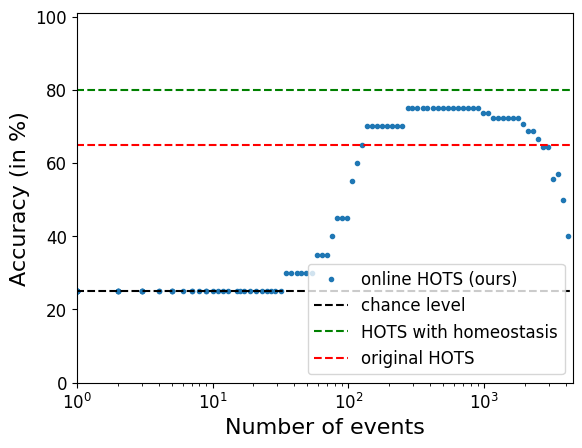

In [ ]:
mlr_threshold = None
onlinac,_,_,_ = online_accuracy(classif_layer, tau_cla, testoutputloader, results_path, ts_size, testset_output.ordering, n_classes, mlr_threshold = mlr_threshold, original_accuracy = score, original_accuracy_nohomeo = score_nohomeo, online_plot=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  2.00it/s]


Number of chance decisions: 11
90th quantile for number of events: 4515.6
Mean accuracy: 33.2%
Last accuracy: 55.00000000000001%
Highest probability accuracy: 75.0%


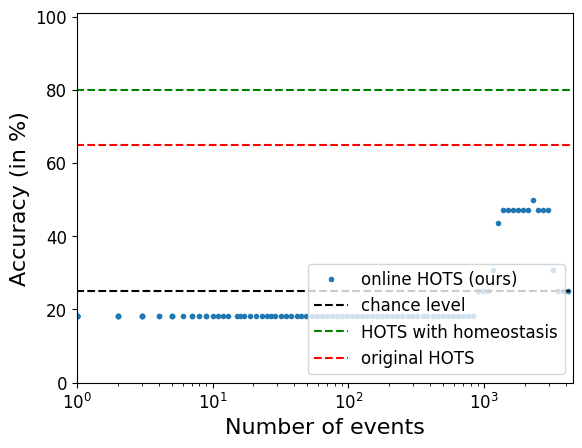

In [ ]:
mlr_threshold = .9
onlinac_thres,_,_,_ = online_accuracy(classif_layer, tau_cla, testoutputloader, results_path, ts_size, testset_output.ordering, n_classes, mlr_threshold = mlr_threshold, original_accuracy = score, original_accuracy_nohomeo = score_nohomeo, online_plot=True)

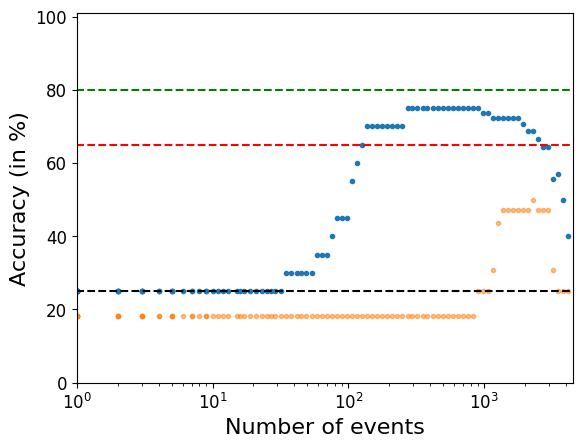

In [ ]:
import matplotlib.pyplot as plt

event_90th = 4515
sampling = (np.logspace(0,np.log10(event_90th),100)).astype(int)

fig, ax = plt.subplots()
ax.semilogx(sampling[:-1],onlinac[sampling[:-1]]*100, '.', label='online HOTS (ours)');
ax.semilogx(sampling[:-1],onlinac_thres[sampling[:-1]]*100, '.', label='online HOTS \nwith threshold', alpha = .5);
ax.hlines(1/n_classes*100,0,event_90th, linestyles='dashed', color='k', label='chance level')
ax.hlines(score_nohomeo*100,0,event_90th, linestyles='dashed', color='r', label='original HOTS')
ax.hlines(score*100,0,event_90th, linestyles='dashed', color='g', label='HOTS with homeostasis')
ax.set_xlabel('Number of events', fontsize=16);
ax.axis([1,event_90th,0,101]);
#plt.title('LR classification results evolution as a function of the number of events');
plt.setp(ax.get_xticklabels(),fontsize=12)
#ax.set_yticks([])
plt.setp(ax.get_yticklabels(),fontsize=12)
#ax.legend(fontsize=12, loc='lower right');
ax.set_ylabel('Accuracy (in %)', fontsize=16);
    #printfig(fig, figure_name)

## Robustness to spatial jitter (Figure 6-(a)-(up))

device -> cpu


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 759.53it/s]

semi saturation level for online HOTS (ours): [] ms
semi saturation level for HOTS with homeostasis: [] ms
semi saturation level for original HOTS: [] ms



/home/antoine/homhots/hotsline/hots/utils.py:632: RuntimeWarning: divide by zero encountered in power
  x = jitter**powa
/home/antoine/homhots/hotsline/hots/utils.py:634: RuntimeWarning: invalid value encountered in divide
  output = Rmax-Rmax*x/(x+jitter0)+Rmin
/home/antoine/homhots/hotsline/hots/utils.py:633: RuntimeWarning: invalid value encountered in double_scalars
  semisat = jitter0**powa
/home/antoine/homhots/hotsline/hots/utils.py:633: RuntimeWarning: invalid value encountered in double_scalars
  semisat = jitter0**powa


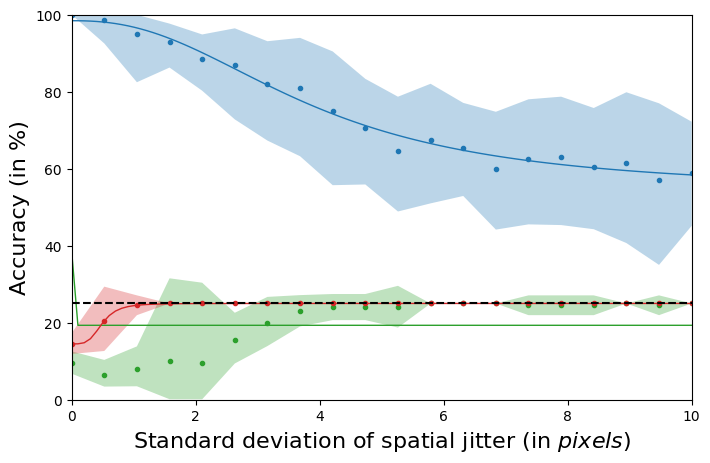

In [15]:
figname = 'spatial_jitter_poker.pdf'
hots.name = initial_name
hots_nohomeo.name = initial_name_nohomeo
standard_spatial_jitter_min = 0
standard_spatial_jitter_max = 10
apply_jitter(standard_spatial_jitter_min, standard_spatial_jitter_max, 'spatial', hots, hots_nohomeo, classif_layer, tau_cla, dataset_name, trainset_output, trainset_output_nohomeo, learning_rate ,betas ,num_epochs, mlr_threshold = mlr_threshold, device = device, verbose=True, figure_name = figname);

## Robustness to temporal jitter (Figure 6-(a)-(down))

device -> cpu


  0%|                                                                                                                                                                                                                                                  | 0/10 [00:00<?, ?it/s]

For temporal jitter equal to 1000.0 - Trial number 1
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_1_20_(None, 1000.0)/
Number of chance decisions: 0
90th quantile for number of events: 4492.5
Mean accuracy: 100.0%
Last accuracy: 95.0%
Highest probability accuracy: 100.0%
For temporal jitter equal to 1000.0
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 0.0 %
For temporal jitter equal to 1623.776739188721 - Trial number 1
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_1_20_(None, 1623.776739188721)/
Number of chance decisions: 0
90th quantile for number of events: 4484.900000000001
Mean accuracy: 100.0%
Last accuracy: 80.0%
Highest probability accuracy: 100.0%
For temporal jitter equal to 1623.776739188721
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 5.0 %
For temporal jitter equal to 2636.650898730358 - Trial num


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.02it/s]


Number of chance decisions: 6
90th quantile for number of events: 4167.2
Mean accuracy: 58.199999999999996%
Last accuracy: 40.0%
Highest probability accuracy: 80.0%
For temporal jitter equal to 11288.378916846883
Online HOTS accuracy: 80.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 18329.807108324374 - Trial number 1



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  8.31it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:04,  3.93it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:05,  3.00it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:04,  3.75it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:04,  2.84it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:05,  2.44it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:04,  2.67it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:04,  2.58it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:03<00:04,  2.31it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:04<00:03,  2.45it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:04<00:04,  1.94it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:05<00:02,  2.25it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:05<00:01,  2.62it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:06<00:01,  2.69it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:06<00:01,  2.61it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:07<00:00,  2.22it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:07<00:00,  2.40it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.54it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_1_20_(None, 18329.807108324374)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:01,  9.56it/s]

None
None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:06,  2.78it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:03,  4.12it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:05,  2.77it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:05,  2.59it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:04,  2.97it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:03,  3.21it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:03<00:03,  3.10it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:02,  3.04it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:04<00:02,  2.82it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:04<00:02,  2.85it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:04<00:02,  2.87it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:05<00:02,  2.42it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:06<00:02,  1.94it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:06<00:01,  1.89it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:06<00:00,  2.09it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:07<00:00,  1.94it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.55it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.31it/s]


Number of chance decisions: 5
90th quantile for number of events: 3666.6000000000004
Mean accuracy: 46.800000000000004%
Last accuracy: 25.0%
Highest probability accuracy: 90.0%
For temporal jitter equal to 18329.807108324374
Online HOTS accuracy: 90.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 29763.51441631319 - Trial number 1



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:07,  2.64it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:06,  2.90it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:05,  3.07it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:06,  2.56it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:04,  3.24it/s]

None
None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:02,  4.25it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:02,  4.35it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:03<00:03,  3.15it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:03,  2.99it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  3.19it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:04<00:02,  2.93it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:04<00:01,  3.01it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:05<00:01,  3.06it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:05<00:01,  2.71it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:06<00:00,  2.41it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:06<00:00,  2.49it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  2.87it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_1_20_(None, 29763.51441631319)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:08,  2.20it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:07,  2.50it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:06,  2.82it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:06,  2.35it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:04,  2.85it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:04,  2.95it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:03,  3.21it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:03,  3.20it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:03<00:03,  3.05it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:04<00:02,  3.00it/s]

None


None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:04<00:03,  2.31it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:05<00:02,  2.49it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:05<00:00,  3.96it/s]

None
None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:06<00:00,  4.03it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:06<00:00,  3.21it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  2.92it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.63it/s]


Number of chance decisions: 9
90th quantile for number of events: 3195.3
Mean accuracy: 36.3%
Last accuracy: 15.0%
Highest probability accuracy: 75.0%
For temporal jitter equal to 29763.51441631319
Online HOTS accuracy: 75.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 48329.30238571752 - Trial number 1



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  5.20it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  5.79it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:03,  4.48it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:03,  4.01it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:03,  3.60it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:04,  2.92it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:04,  2.47it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:04,  2.43it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:03<00:03,  2.69it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:03,  2.92it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  3.23it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:04<00:02,  2.57it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:05<00:01,  2.83it/s]

None


None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:05<00:00,  3.53it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:05<00:00,  3.52it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:06<00:00,  3.36it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.16it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_1_20_(None, 48329.30238571752)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:04,  4.39it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  5.05it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:04,  3.41it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:05,  2.80it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:06,  2.32it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:05,  2.59it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:04,  2.41it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:03,  2.83it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:03<00:03,  2.87it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:02,  3.25it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  3.18it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:04<00:02,  3.12it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:04<00:01,  3.90it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:05<00:01,  3.41it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:05<00:00,  3.41it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:05<00:00,  3.45it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.23it/s]


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  2.96it/s]


Number of chance decisions: 13
90th quantile for number of events: 2795.2
Mean accuracy: 26.1%
Last accuracy: 10.0%
Highest probability accuracy: 85.0%
For temporal jitter equal to 48329.30238571752
Online HOTS accuracy: 85.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 78475.99703514607 - Trial number 1



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:05,  3.46it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:05,  3.59it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:05,  3.03it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:04,  3.53it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:04,  3.66it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:05,  2.74it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:04,  2.67it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:04,  2.87it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:02,  4.23it/s]

None
None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  3.49it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:01,  3.59it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:04<00:01,  3.66it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:04<00:01,  3.82it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:04<00:00,  4.16it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:05<00:00,  3.84it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_1_20_(None, 78475.99703514607)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:06,  2.73it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:05,  3.27it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:05,  3.29it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:04,  3.75it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:04,  3.11it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  4.70it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  4.73it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:02,  4.44it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  4.22it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:02,  3.17it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  3.27it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:02,  3.41it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:03<00:01,  3.07it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:04<00:01,  2.79it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:04<00:01,  2.73it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:05<00:00,  3.00it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:05<00:00,  3.51it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.37it/s]


Number of chance decisions: 14
90th quantile for number of events: 2457.9
Mean accuracy: 8.0%
Last accuracy: 0.0%
Highest probability accuracy: 80.0%
For temporal jitter equal to 78475.99703514607
Online HOTS accuracy: 80.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 127427.49857031321 - Trial number 1



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:07,  2.71it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:07,  2.54it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:05,  3.09it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:04,  3.75it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:04,  3.02it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:03,  3.84it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:02,  3.79it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  3.87it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:01,  4.24it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:01,  4.88it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:03<00:01,  4.67it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:04<00:00,  5.46it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:04<00:00,  4.53it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:04<00:00,  4.97it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.93it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_1_20_(None, 127427.49857031321)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  4.82it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  5.35it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:03,  4.86it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:03,  3.82it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  4.24it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:03,  3.48it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:03,  3.24it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:02,  3.47it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  3.32it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:01,  3.55it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:03<00:01,  4.36it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:04<00:00,  4.30it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:04<00:00,  4.58it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:04<00:00,  4.31it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.96it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.97it/s]


Number of chance decisions: 17
90th quantile for number of events: 2093.0
Mean accuracy: 29.799999999999997%
Last accuracy: 25.0%
Highest probability accuracy: 75.0%
For temporal jitter equal to 127427.49857031321
Online HOTS accuracy: 75.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 206913.808111479 - Trial number 1



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:06,  3.02it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  4.42it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:03,  4.34it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:03,  4.44it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:03,  3.56it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:04,  3.07it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:03,  3.11it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  4.27it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:02,  4.35it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:03<00:01,  5.45it/s]

None
None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:03<00:01,  4.53it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:03<00:00,  4.52it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:04<00:00,  5.12it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:04<00:00,  5.37it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.34it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_1_20_(None, 206913.808111479)/
0 is not enough



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:01, 16.94it/s]

None
None
None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  7.17it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  5.75it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:02,  5.42it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  4.39it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:02,  4.95it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  5.19it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:01,  5.02it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  4.13it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  4.29it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:01,  3.83it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:03<00:01,  3.25it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:03<00:01,  3.45it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:03<00:00,  3.70it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:04<00:00,  4.27it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.38it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.95it/s]


Number of chance decisions: 20
90th quantile for number of events: 1682.6
Mean accuracy: 15.0%
Last accuracy: 15.0%
Highest probability accuracy: 75.0%
For temporal jitter equal to 206913.808111479
Online HOTS accuracy: 75.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 335981.8286283781 - Trial number 1



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  6.84it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:04,  3.98it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:05,  3.29it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:03,  4.49it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  6.45it/s]

None
None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:01,  5.80it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  4.84it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  5.43it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:03<00:00,  4.75it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:03<00:00,  4.38it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.86it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_1_20_(None, 335981.8286283781)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  6.80it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  5.64it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:02,  5.87it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  5.50it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.31it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  4.86it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  4.33it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:01,  5.50it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  5.08it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:03<00:00,  4.13it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:03<00:00,  3.57it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:03<00:00,  4.12it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.79it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.61it/s]


Number of chance decisions: 20
90th quantile for number of events: 1320.7
Mean accuracy: 15.0%
Last accuracy: 15.0%
Highest probability accuracy: 65.0%
For temporal jitter equal to 335981.8286283781
Online HOTS accuracy: 65.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 30.0 %
For temporal jitter equal to 545559.4781168514 - Trial number 1



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:05,  3.62it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  6.96it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:02,  6.74it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  6.45it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.71it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  6.84it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  5.80it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  5.55it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  4.91it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:03<00:00,  4.24it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.44it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_1_20_(None, 545559.4781168514)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  4.84it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  6.03it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:03,  4.58it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  4.92it/s]

None
None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  5.65it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:01,  5.68it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  5.53it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:01,  5.38it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:03<00:00,  5.80it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:03<00:00,  5.65it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.06it/s]


Number of chance decisions: 20
90th quantile for number of events: 908.0000000000001
Mean accuracy: 15.0%
Last accuracy: 15.0%
Highest probability accuracy: 40.0%
For temporal jitter equal to 545559.4781168514
Online HOTS accuracy: 40.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 885866.7904100833 - Trial number 1



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:01,  9.78it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  7.55it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:01,  7.83it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  5.76it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  5.12it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  5.11it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  4.94it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  5.13it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  5.28it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  6.12it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:03<00:00,  6.96it/s]

None
None


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.08it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_1_20_(None, 885866.7904100833)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  5.55it/s]

None
None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  5.97it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  5.59it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:02,  5.88it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  6.26it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  6.32it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  5.79it/s]

None
None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  8.28it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  6.77it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  5.91it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  5.50it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.05it/s]


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.58it/s]


Number of chance decisions: 20
90th quantile for number of events: 577.7
Mean accuracy: 35.0%
Last accuracy: 35.0%
Highest probability accuracy: 30.0%
For temporal jitter equal to 885866.7904100833
Online HOTS accuracy: 30.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 30.0 %
For temporal jitter equal to 1438449.888287663 - Trial number 1



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  6.48it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  7.53it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  6.96it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  6.23it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  5.96it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  5.50it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  7.42it/s]

None
None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  6.69it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  6.00it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  8.20it/s]

None
None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.51it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_1_20_(None, 1438449.888287663)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  6.66it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  6.56it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  5.75it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:01,  7.17it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  8.33it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  7.88it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  6.33it/s]

None
None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:01,  5.91it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  6.10it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  6.41it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.51it/s]


None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 40.22it/s]


Number of chance decisions: 20
90th quantile for number of events: 280.2
Mean accuracy: 25.0%
Last accuracy: 25.0%
Highest probability accuracy: 25.0%
For temporal jitter equal to 1438449.888287663
Online HOTS accuracy: 25.0 %
Original HOTS accuracy: 20.0 %
HOTS with homeostasis accuracy: 30.0 %
For temporal jitter equal to 2335721.4690901213 - Trial number 1



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  8.34it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  7.27it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  5.75it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:02,  6.62it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:01,  7.21it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  7.63it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  7.17it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:01,  6.12it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  6.49it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  6.68it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.83it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_1_20_(None, 2335721.4690901213)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  6.42it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  6.78it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  5.83it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  6.11it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  6.81it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:02,  6.00it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  6.05it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.58it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  6.75it/s]

None


None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:00,  7.55it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  6.96it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.88it/s]


None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.84it/s]


Number of chance decisions: 20
90th quantile for number of events: 105.1
Mean accuracy: 25.0%
Last accuracy: 25.0%
Highest probability accuracy: 20.0%
For temporal jitter equal to 2335721.4690901213
Online HOTS accuracy: 20.0 %
Original HOTS accuracy: 35.0 %
HOTS with homeostasis accuracy: 30.0 %
For temporal jitter equal to 3792690.190732246 - Trial number 1



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None
None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:01, 10.11it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  7.47it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  6.51it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:02,  6.04it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  6.39it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  6.52it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  7.42it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  7.66it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:01<00:00,  7.50it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  7.30it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  7.32it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  5.98it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.00it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_1_20_(None, 3792690.190732246)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  7.82it/s]

None
None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  6.47it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:01,  7.16it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  9.38it/s]

None
None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  8.79it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:00,  7.82it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:01<00:00,  8.43it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  6.67it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  6.24it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.08it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 224.27it/s]


Number of chance decisions: 20
90th quantile for number of events: 24.300000000000004
Mean accuracy: 40.0%
Last accuracy: 40.0%
Highest probability accuracy: 15.0%
For temporal jitter equal to 3792690.190732246
Online HOTS accuracy: 15.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 30.0 %
For temporal jitter equal to 6158482.110660254 - Trial number 1



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  7.00it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  7.10it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  7.84it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  7.50it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  7.48it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:01,  7.18it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:00<00:01,  7.25it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  8.71it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  7.38it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  6.16it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:01,  5.42it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  7.25it/s]

None
None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  6.99it/s]

None
None


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.13it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_1_20_(None, 6158482.110660254)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  7.66it/s]

None
None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  7.38it/s]

None
None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:00<00:01,  8.95it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  8.33it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  7.49it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:01<00:00,  6.64it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  7.28it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  6.05it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  6.32it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.06it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 338.04it/s]


Number of chance decisions: 20
90th quantile for number of events: 7.400000000000006
Mean accuracy: 15.0%
Last accuracy: 15.0%
Highest probability accuracy: 20.0%
For temporal jitter equal to 6158482.110660254
Online HOTS accuracy: 20.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 15.0 %
For temporal jitter equal to 10000000.0 - Trial number 1



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  5.62it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  5.25it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  5.38it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:01,  7.69it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:00<00:01,  7.97it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  6.29it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  7.28it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:00,  7.33it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  8.39it/s]

None
None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  7.64it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.25it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_1_20_(None, 10000000.0)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  7.24it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:01,  9.96it/s]

None
None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  7.09it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  7.19it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  6.99it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:00,  7.21it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  7.17it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  6.49it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  7.37it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.21it/s]

 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 2/10 [03:02<12:11, 91.39s/it]

Number of chance decisions: 20
90th quantile for number of events: 2.0
Mean accuracy: 25.0%
Last accuracy: 25.0%
Highest probability accuracy: 5.0%
For temporal jitter equal to 10000000.0
Online HOTS accuracy: 5.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 30.0 %
For temporal jitter equal to 1000.0 - Trial number 2



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:07,  2.64it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:08,  2.17it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:09,  1.76it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:08,  1.86it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:05,  2.37it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:05,  2.53it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:05,  2.28it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:05,  2.18it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:05,  1.70it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:05,  1.57it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:06<00:05,  1.56it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:07<00:04,  1.62it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:03,  1.57it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:01,  2.16it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  2.23it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:00,  2.13it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  2.39it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.93it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(None, 1000.0)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:13,  1.44it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:08,  2.16it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:11,  1.53it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:09,  1.64it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:03<00:10,  1.49it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:08,  1.63it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:04<00:07,  1.73it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:04<00:06,  1.80it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:04,  2.12it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:06<00:04,  2.06it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:06<00:03,  2.17it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:07<00:03,  1.90it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:03,  1.87it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:01,  2.38it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  2.26it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:00,  2.08it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  2.29it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.90it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.74it/s]
/home/antoine/homhots/hotsline/hots/utils.py:484: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


Number of chance decisions: 0
90th quantile for number of events: 4495.8
Mean accuracy: 100.0%
Last accuracy: 90.0%
Highest probability accuracy: 100.0%
For temporal jitter equal to 1000.0
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 5.0 %
For temporal jitter equal to 1623.776739188721 - Trial number 2



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:06,  2.94it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:10,  1.75it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:06,  2.54it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:06,  2.18it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:07,  1.88it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:07,  1.83it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:04<00:06,  1.88it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:05,  1.91it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:05,  1.67it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:03,  2.37it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:03,  2.22it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:02,  2.13it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  1.87it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:07<00:01,  2.06it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  2.34it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:08<00:01,  1.96it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  1.94it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.93it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(None, 1623.776739188721)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:12,  1.47it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:12,  1.45it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:10,  1.59it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:10,  1.47it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:06,  2.18it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:06,  2.01it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:04<00:06,  1.99it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:04,  2.24it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:04,  2.16it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:03,  2.62it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:03,  1.88it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:03,  1.88it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  1.91it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:01,  2.05it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  2.20it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:01,  1.94it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:10<00:00,  1.72it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.93it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.75it/s]
/home/antoine/homhots/hotsline/hots/utils.py:484: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


Number of chance decisions: 0
90th quantile for number of events: 4490.200000000001
Mean accuracy: 99.5%
Last accuracy: 80.0%
Highest probability accuracy: 95.0%
For temporal jitter equal to 1623.776739188721
Online HOTS accuracy: 95.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 5.0 %
For temporal jitter equal to 2636.650898730358 - Trial number 2



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:06,  2.66it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:06,  2.83it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:07,  2.07it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:08,  1.86it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:09,  1.54it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:07,  1.68it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:04<00:06,  1.78it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:06,  1.68it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:05,  1.71it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:06<00:03,  2.03it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:03,  2.02it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:03,  1.94it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  2.24it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:01,  2.35it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  1.94it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:00,  2.07it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  2.02it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.93it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(None, 2636.650898730358)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:12,  1.47it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:10,  1.78it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:10,  1.60it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:06,  2.17it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:06,  2.03it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:04<00:08,  1.62it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:04<00:06,  1.83it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:05<00:06,  1.64it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:05,  1.68it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:06<00:04,  1.99it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:06<00:04,  1.99it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:07<00:03,  1.99it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:03,  1.72it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:08<00:02,  1.94it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:02,  1.94it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:09<00:01,  1.94it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:00,  2.18it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.95it/s]


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.77it/s]


Number of chance decisions: 1
90th quantile for number of events: 4468.7
Mean accuracy: 93.0%
Last accuracy: 70.0%
Highest probability accuracy: 90.0%
For temporal jitter equal to 2636.650898730358
Online HOTS accuracy: 90.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 15.0 %
For temporal jitter equal to 4281.332398719395 - Trial number 2



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:12,  1.53it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:09,  1.81it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:07,  2.26it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:06,  2.44it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:06,  2.27it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:06,  2.22it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:06,  1.91it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:05,  2.08it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:05,  1.98it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:06,  1.62it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:06<00:05,  1.52it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:06<00:05,  1.50it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:02,  2.09it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  2.39it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  2.83it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:08<00:00,  2.52it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  2.02it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  2.00it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(None, 4281.332398719395)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:13,  1.44it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:10,  1.77it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:09,  1.85it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:09,  1.71it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:05,  2.45it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:05,  2.49it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:05,  2.32it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:04,  2.23it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:03,  2.52it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:03,  2.34it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:04,  1.78it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:04,  1.64it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:03,  1.53it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:08<00:03,  1.53it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:02,  1.61it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:00,  2.42it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  2.53it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.97it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.80it/s]


Number of chance decisions: 3
90th quantile for number of events: 4444.8
Mean accuracy: 77.0%
Last accuracy: 50.0%
Highest probability accuracy: 95.0%
For temporal jitter equal to 4281.332398719395
Online HOTS accuracy: 95.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 20.0 %
For temporal jitter equal to 6951.927961775606 - Trial number 2



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:06,  2.96it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:10,  1.79it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:11,  1.45it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:09,  1.60it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:08,  1.72it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:07,  1.79it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:04<00:07,  1.69it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:04<00:06,  1.92it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:05<00:06,  1.70it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:04,  2.06it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:02,  2.99it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:02,  2.72it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:06<00:01,  3.20it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:07<00:01,  2.45it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  2.05it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:08<00:00,  2.12it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  2.15it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.09it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(None, 6951.927961775606)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:05,  3.47it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:05,  3.14it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:04,  3.39it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:06,  2.28it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:05,  2.26it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:05,  2.24it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:04,  2.25it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:05,  1.95it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:04<00:04,  2.05it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:03,  2.01it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:05<00:03,  2.15it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:03,  1.75it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:06<00:02,  2.02it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:07<00:01,  2.30it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:07<00:01,  2.28it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:08<00:01,  1.77it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:08<00:00,  1.83it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.06it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.88it/s]


Number of chance decisions: 3
90th quantile for number of events: 4394.900000000001
Mean accuracy: 59.599999999999994%
Last accuracy: 40.0%
Highest probability accuracy: 90.0%
For temporal jitter equal to 6951.927961775606
Online HOTS accuracy: 90.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 20.0 %
For temporal jitter equal to 11288.378916846883 - Trial number 2



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:11,  1.59it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:07,  2.54it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:06,  2.51it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:08,  1.96it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:07,  2.14it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:06,  2.27it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:07,  1.77it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:03,  2.82it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:03,  2.54it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:04<00:03,  2.52it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:03,  2.14it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:03,  1.98it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:02,  2.02it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:06<00:02,  2.32it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:07<00:01,  2.50it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:07<00:01,  2.29it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:08<00:00,  3.05it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.27it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(None, 11288.378916846883)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:05,  3.28it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:05,  3.22it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:05,  3.10it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:05,  2.86it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:06,  2.26it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:05,  2.20it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:06,  1.88it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:05,  1.95it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:04,  2.12it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:04<00:04,  2.22it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:03,  2.31it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:05<00:02,  2.70it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:05<00:02,  2.66it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:06<00:02,  1.96it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:07<00:02,  1.82it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:07<00:01,  1.69it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:08<00:00,  2.64it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.27it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.05it/s]


Number of chance decisions: 6
90th quantile for number of events: 4136.7
Mean accuracy: 45.9%
Last accuracy: 35.0%
Highest probability accuracy: 85.0%
For temporal jitter equal to 11288.378916846883
Online HOTS accuracy: 85.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 18329.807108324374 - Trial number 2



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:06,  2.93it/s]


None


 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:04,  3.72it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:07,  2.32it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:04,  3.61it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:04,  2.81it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:04,  2.68it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:05,  2.38it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:04,  2.40it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:03<00:03,  2.52it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:04<00:02,  3.33it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:04<00:02,  3.18it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:04<00:02,  2.89it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:05<00:02,  2.44it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:05<00:01,  2.67it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:06<00:01,  2.75it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:06<00:00,  2.29it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:07<00:00,  2.60it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.57it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(None, 18329.807108324374)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None
None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:08,  2.11it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:07,  2.36it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:05,  2.84it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:04,  3.31it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:03,  3.36it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:03,  2.75it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:03<00:04,  2.29it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:04<00:04,  2.12it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:04<00:03,  2.30it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:05<00:02,  2.44it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:05<00:02,  2.42it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:06<00:02,  2.19it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:06<00:01,  2.34it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:06<00:01,  2.46it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:07<00:00,  2.76it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:07<00:00,  2.29it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.52it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.31it/s]


Number of chance decisions: 6
90th quantile for number of events: 3709.7000000000003
Mean accuracy: 65.60000000000001%
Last accuracy: 40.0%
Highest probability accuracy: 80.0%
For temporal jitter equal to 18329.807108324374
Online HOTS accuracy: 80.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 29763.51441631319 - Trial number 2



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:05,  3.19it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:09,  1.94it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:05,  2.98it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:05,  2.55it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:03,  3.81it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:03,  3.36it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:03,  3.12it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:02,  3.80it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:04<00:02,  2.88it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:04<00:02,  2.48it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:04<00:02,  2.66it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:05<00:01,  2.79it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:05<00:00,  3.34it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:06<00:00,  2.88it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:06<00:00,  2.89it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  2.87it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(None, 29763.51441631319)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  5.54it/s]

None
None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  4.80it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:04,  3.97it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:04,  3.40it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:04,  3.32it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:05,  2.60it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:04,  2.63it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:04,  2.78it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:04,  2.20it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:03<00:04,  2.30it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:03,  2.64it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:04<00:02,  2.97it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:04<00:02,  2.68it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:05<00:01,  2.81it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:05<00:01,  2.95it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:06<00:01,  2.56it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:06<00:00,  2.42it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  2.91it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.65it/s]


Number of chance decisions: 9
90th quantile for number of events: 3181.0
Mean accuracy: 26.700000000000003%
Last accuracy: 5.0%
Highest probability accuracy: 90.0%
For temporal jitter equal to 29763.51441631319
Online HOTS accuracy: 90.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 48329.30238571752 - Trial number 2



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:05,  3.30it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:07,  2.53it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:07,  2.42it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:06,  2.41it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:05,  2.69it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:04,  3.09it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:04,  2.66it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:03,  3.40it/s]

None
None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:02,  4.15it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:01,  4.27it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:01,  3.92it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:04<00:01,  3.29it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:04<00:01,  3.36it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:05<00:01,  2.65it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:05<00:00,  3.82it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:05<00:00,  3.58it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.23it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(None, 48329.30238571752)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:08,  2.14it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:06,  2.74it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:05,  3.07it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:03,  3.89it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:03,  4.10it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:03,  3.28it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:02,  3.97it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  3.37it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:02,  3.38it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:01,  3.72it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:03<00:01,  3.89it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:04<00:01,  3.11it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:04<00:00,  3.49it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:05<00:00,  3.37it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:05<00:00,  3.42it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.26it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.01it/s]


Number of chance decisions: 12
90th quantile for number of events: 2804.0
Mean accuracy: 28.599999999999998%
Last accuracy: 10.0%
Highest probability accuracy: 85.0%
For temporal jitter equal to 48329.30238571752
Online HOTS accuracy: 85.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 78475.99703514607 - Trial number 2



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  6.76it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  4.45it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:03,  4.17it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:03,  3.83it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:03,  3.86it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:03,  3.27it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:02,  4.08it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:02,  3.89it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  3.45it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:02,  3.43it/s]


None


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:03<00:01,  3.75it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:04<00:01,  3.32it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:04<00:01,  3.48it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:04<00:01,  2.75it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:05<00:00,  3.04it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:05<00:00,  3.24it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(None, 78475.99703514607)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:04,  3.87it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  6.50it/s]

None
None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  6.32it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:03,  4.42it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:03,  4.06it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:03,  3.99it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:03,  3.05it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:03,  3.22it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  3.76it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:01,  4.35it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:03<00:01,  4.44it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:03<00:01,  4.10it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:04<00:01,  3.48it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:04<00:00,  3.06it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:04<00:00,  2.83it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:05<00:00,  3.06it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.37it/s]


Number of chance decisions: 15
90th quantile for number of events: 2426.7
Mean accuracy: 39.4%
Last accuracy: 25.0%
Highest probability accuracy: 95.0%
For temporal jitter equal to 78475.99703514607
Online HOTS accuracy: 95.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 127427.49857031321 - Trial number 2



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None
None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  5.98it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  5.06it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:03,  4.04it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:03,  4.09it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:03,  3.54it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:04,  2.92it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  3.96it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:01,  4.19it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:01,  4.73it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:03<00:00,  5.42it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:03<00:00,  4.27it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:04<00:00,  4.21it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:04<00:00,  3.57it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:04<00:00,  3.71it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.97it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(None, 127427.49857031321)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:06,  2.81it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  4.41it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:03,  4.78it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:02,  4.92it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:03,  3.82it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:03,  3.79it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:02,  3.78it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  3.86it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:02,  3.45it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  2.93it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:03<00:01,  3.96it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:03<00:01,  4.08it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:04<00:01,  3.66it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:04<00:00,  3.28it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.99it/s]


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  4.00it/s]


Number of chance decisions: 18
90th quantile for number of events: 2085.8
Mean accuracy: 11.899999999999999%
Last accuracy: 10.0%
Highest probability accuracy: 85.0%
For temporal jitter equal to 127427.49857031321
Online HOTS accuracy: 85.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 30.0 %
For temporal jitter equal to 206913.808111479 - Trial number 2



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:05,  3.28it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:05,  3.04it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:04,  3.59it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:04,  3.93it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:04,  3.55it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:04,  3.33it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:02,  4.02it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:02,  4.52it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  3.99it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:02,  3.98it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:01,  4.18it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:03<00:01,  5.03it/s]

None
None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:03<00:00,  7.37it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:03<00:00,  4.89it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:04<00:00,  5.09it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.43it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(None, 206913.808111479)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  7.98it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  6.74it/s]

None
None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  5.78it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:02,  4.69it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:02,  4.71it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:01,  4.65it/s]


None


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  4.68it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  4.37it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:01,  4.00it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:03<00:01,  3.70it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:03<00:01,  3.19it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:03<00:00,  3.40it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:04<00:00,  3.66it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.40it/s]


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.97it/s]


Number of chance decisions: 20
90th quantile for number of events: 1723.5
Mean accuracy: 20.0%
Last accuracy: 20.0%
Highest probability accuracy: 75.0%
For temporal jitter equal to 206913.808111479
Online HOTS accuracy: 75.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 335981.8286283781 - Trial number 2



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  4.96it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:04,  4.14it/s]

None


None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:04,  3.82it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:04,  3.67it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:03,  3.92it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  4.64it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:01,  6.48it/s]

None
None
None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:01,  5.65it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:03<00:00,  5.35it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:03<00:00,  5.54it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:03<00:00,  5.46it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.89it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(None, 335981.8286283781)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  5.52it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  5.52it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  5.37it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  6.24it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  5.89it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:02,  6.74it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:01,  6.81it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  5.19it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.09it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  5.67it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  5.39it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:01,  4.18it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:01,  4.28it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:03<00:01,  3.92it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:03<00:00,  3.70it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:03<00:00,  3.58it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.91it/s]


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.59it/s]


Number of chance decisions: 20
90th quantile for number of events: 1330.6000000000001
Mean accuracy: 20.0%
Last accuracy: 20.0%
Highest probability accuracy: 65.0%
For temporal jitter equal to 335981.8286283781
Online HOTS accuracy: 65.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 30.0 %
For temporal jitter equal to 545559.4781168514 - Trial number 2



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  6.90it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:03,  4.87it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:02,  5.12it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  4.99it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  5.76it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:01,  5.23it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  5.87it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:00,  6.73it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  5.74it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:03<00:00,  5.70it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:03<00:00,  4.87it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.55it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(None, 545559.4781168514)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  5.94it/s]

None
None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  7.45it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  4.84it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:02,  6.54it/s]

None
None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  5.89it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  5.89it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:01,  4.75it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  4.70it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  5.29it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:03<00:00,  5.41it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:03<00:00,  4.91it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.48it/s]


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.95it/s]


Number of chance decisions: 20
90th quantile for number of events: 963.0000000000001
Mean accuracy: 50.0%
Last accuracy: 50.0%
Highest probability accuracy: 35.0%
For temporal jitter equal to 545559.4781168514
Online HOTS accuracy: 35.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 30.0 %
For temporal jitter equal to 885866.7904100833 - Trial number 2



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  8.13it/s]

None
None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  7.53it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:02,  6.26it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  5.45it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.31it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  5.73it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:00,  6.05it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  5.99it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  5.28it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.01it/s]

None
None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(None, 885866.7904100833)/
0 is not enough




  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  8.59it/s]

None
None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  8.32it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:01,  8.72it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:00<00:01,  7.53it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  6.22it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.96it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  6.13it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:01,  5.95it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  5.29it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  5.29it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:03<00:00,  4.52it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.99it/s]


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.06it/s]


Number of chance decisions: 20
90th quantile for number of events: 584.1000000000001
Mean accuracy: 10.0%
Last accuracy: 10.0%
Highest probability accuracy: 25.0%
For temporal jitter equal to 885866.7904100833
Online HOTS accuracy: 25.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 40.0 %
For temporal jitter equal to 1438449.888287663 - Trial number 2



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  5.19it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  7.69it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  5.70it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  6.84it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.28it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  5.74it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  5.41it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:01,  5.82it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  7.08it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  7.84it/s]

None
None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.51it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(None, 1438449.888287663)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  6.53it/s]

None
None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  6.32it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  5.83it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:01,  8.29it/s]

None
None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  7.51it/s]

None
None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:00,  9.51it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:00,  7.46it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  7.56it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  6.52it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  5.55it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.49it/s]


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 40.91it/s]


Number of chance decisions: 20
90th quantile for number of events: 254.60000000000002
Mean accuracy: 15.0%
Last accuracy: 15.0%
Highest probability accuracy: 25.0%
For temporal jitter equal to 1438449.888287663
Online HOTS accuracy: 25.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 2335721.4690901213 - Trial number 2



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  5.93it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  6.52it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  7.17it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  5.87it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  5.45it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:02,  5.18it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  5.29it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  5.68it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  8.64it/s]

None
None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  8.29it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.55it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(None, 2335721.4690901213)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:01, 16.70it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:01,  8.85it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:01,  7.16it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  7.33it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.32it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  5.53it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:01,  5.90it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  5.98it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  7.88it/s]

None
None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.80it/s]


None



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 101.14it/s]


Number of chance decisions: 20
90th quantile for number of events: 109.10000000000005
Mean accuracy: 25.0%
Last accuracy: 25.0%
Highest probability accuracy: 25.0%
For temporal jitter equal to 2335721.4690901213
Online HOTS accuracy: 25.0 %
Original HOTS accuracy: 10.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 3792690.190732246 - Trial number 2



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  6.96it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:01,  8.87it/s]


None


 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  6.96it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:02,  6.17it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  6.68it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  6.35it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:01<00:00,  8.77it/s]

None
None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  8.13it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  6.93it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.97it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(None, 3792690.190732246)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  7.35it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:01,  8.89it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:01,  7.69it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:00<00:01,  8.32it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  8.13it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  8.43it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:01<00:00,  7.33it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  5.83it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  6.32it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.05it/s]


None



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 229.74it/s]


Number of chance decisions: 20
90th quantile for number of events: 33.2
Mean accuracy: 15.0%
Last accuracy: 15.0%
Highest probability accuracy: 20.0%
For temporal jitter equal to 3792690.190732246
Online HOTS accuracy: 20.0 %
Original HOTS accuracy: 35.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 6158482.110660254 - Trial number 2



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  7.16it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  5.81it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  7.07it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:01,  8.96it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:00<00:01,  6.99it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  7.05it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  7.17it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:00,  7.81it/s]

None
None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  8.10it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  7.18it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.55it/s]

None


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.20it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(None, 6158482.110660254)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  5.82it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  6.82it/s]

None
None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:01,  7.14it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:00<00:01,  7.27it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  7.62it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  7.77it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:00,  7.50it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  7.36it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  5.79it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.17it/s]


None
None



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 285.22it/s]


Number of chance decisions: 20
90th quantile for number of events: 4.200000000000003
Mean accuracy: 25.0%
Last accuracy: 25.0%
Highest probability accuracy: 20.0%
For temporal jitter equal to 6158482.110660254
Online HOTS accuracy: 20.0 %
Original HOTS accuracy: 15.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 10000000.0 - Trial number 2



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  7.47it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  5.98it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  6.46it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:01,  8.95it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:01,  7.68it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  6.39it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.70it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  7.43it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:01<00:00,  7.40it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  6.86it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  7.13it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.34it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_2_20_(None, 10000000.0)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  7.28it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  8.25it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  5.91it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:01,  7.09it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  6.07it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  5.51it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:00,  7.78it/s]

None
None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  9.67it/s]

None
None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  8.22it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.31it/s]


None



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 690.44it/s]


Number of chance decisions: 20
90th quantile for number of events: 1.0
Mean accuracy: 15.0%
Last accuracy: 15.0%
Highest probability accuracy: 10.0%


 30%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                   | 3/10 [09:02<23:42, 203.28s/it]

For temporal jitter equal to 10000000.0
Online HOTS accuracy: 10.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 30.0 %
For temporal jitter equal to 1000.0 - Trial number 3



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:08,  2.22it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:10,  1.74it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:07,  2.14it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:08,  1.81it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:09,  1.59it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:07,  1.94it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:07,  1.67it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:04<00:06,  1.77it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:05,  1.98it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:06,  1.61it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:06<00:05,  1.71it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:06<00:04,  1.78it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:07<00:04,  1.66it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:03,  1.70it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:08<00:02,  1.76it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:09<00:02,  1.80it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:00,  2.34it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.92it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(None, 1000.0)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:07,  2.43it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:09,  1.85it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:10,  1.49it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:03<00:09,  1.63it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:09,  1.53it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:04<00:08,  1.49it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:05<00:07,  1.50it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:05<00:06,  1.59it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:06<00:06,  1.63it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:06<00:05,  1.71it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:07<00:03,  2.01it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:07<00:03,  2.01it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:08<00:01,  2.65it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:01,  2.72it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  2.39it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:00,  2.46it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  2.31it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.93it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.73it/s]
/home/antoine/homhots/hotsline/hots/utils.py:484: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


Number of chance decisions: 0
90th quantile for number of events: 4495.6
Mean accuracy: 100.0%
Last accuracy: 90.0%
Highest probability accuracy: 100.0%
For temporal jitter equal to 1000.0
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 10.0 %
For temporal jitter equal to 1623.776739188721 - Trial number 3



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  5.92it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:06,  2.66it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:05,  2.95it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:08,  1.91it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:08,  1.70it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:08,  1.57it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:04<00:09,  1.40it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:04<00:07,  1.69it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:05,  1.91it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:05,  1.86it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:06<00:05,  1.74it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:02,  2.43it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:02,  2.25it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  2.13it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:01,  2.10it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  2.07it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:01,  1.76it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  1.82it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.91it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(None, 1623.776739188721)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:07,  2.47it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:06,  2.59it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:05,  2.74it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:06,  2.28it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:06,  2.15it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:05,  2.19it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:05,  2.09it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:04,  2.08it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:04,  2.23it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:03,  2.16it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:03,  2.10it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:03,  1.88it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  1.73it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:07<00:02,  1.76it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  1.82it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:08<00:00,  2.08it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  1.79it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.94it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.75it/s]
/home/antoine/homhots/hotsline/hots/utils.py:484: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


Number of chance decisions: 0
90th quantile for number of events: 4479.5
Mean accuracy: 100.0%
Last accuracy: 85.0%
Highest probability accuracy: 100.0%
For temporal jitter equal to 1623.776739188721
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 10.0 %
For temporal jitter equal to 2636.650898730358 - Trial number 3



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  6.62it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:05,  3.22it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:06,  2.47it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:04,  3.03it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:06,  2.27it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:06,  2.13it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:07,  1.68it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:06,  1.76it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:06,  1.62it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:05,  1.66it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:06<00:04,  1.71it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:04,  1.57it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:03,  1.84it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  2.14it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:02,  1.89it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  1.93it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:01,  1.75it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  1.82it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.96it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(None, 2636.650898730358)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  6.73it/s]

None
None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:10,  1.74it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:10,  1.69it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:09,  1.74it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:06,  2.14it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:05,  2.38it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:04,  2.48it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:04,  2.28it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:05,  1.98it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:05,  1.78it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:03,  2.09it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:03,  1.98it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:03,  1.79it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  1.84it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:02,  1.87it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  2.03it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:00,  2.02it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  1.74it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.94it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.77it/s]
/home/antoine/homhots/hotsline/hots/utils.py:484: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


Number of chance decisions: 0
90th quantile for number of events: 4479.3
Mean accuracy: 100.0%
Last accuracy: 70.0%
Highest probability accuracy: 100.0%
For temporal jitter equal to 2636.650898730358
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 15.0 %
For temporal jitter equal to 4281.332398719395 - Trial number 3



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:09,  2.07it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:09,  1.92it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:08,  1.93it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:09,  1.67it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:09,  1.61it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:04,  2.60it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:04,  2.44it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:04,  2.22it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:04,  2.39it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:03,  2.58it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:05<00:02,  2.39it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:02,  2.44it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:06<00:02,  2.29it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:07<00:02,  1.77it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  1.67it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:08<00:01,  1.76it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  1.60it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.00it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(None, 4281.332398719395)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:07,  2.59it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:08,  2.10it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:10,  1.65it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:09,  1.61it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:06,  2.26it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:04,  2.89it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:05,  2.18it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:05,  2.13it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:05,  1.88it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:04,  1.92it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:03,  2.12it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:03,  1.82it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:03,  1.55it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  1.67it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:02,  1.99it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  2.24it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:00,  2.21it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  2.13it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.97it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.80it/s]


Number of chance decisions: 1
90th quantile for number of events: 4448.2
Mean accuracy: 87.4%
Last accuracy: 55.00000000000001%
Highest probability accuracy: 95.0%
For temporal jitter equal to 4281.332398719395
Online HOTS accuracy: 95.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 20.0 %
For temporal jitter equal to 6951.927961775606 - Trial number 3



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:04,  3.86it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:05,  2.96it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:05,  2.85it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:04,  3.15it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:05,  2.77it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:06,  2.10it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:05,  2.39it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:05,  2.06it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:04,  2.07it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:04<00:02,  2.94it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:05<00:02,  2.53it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:05<00:02,  2.32it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:06<00:02,  1.94it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:06<00:01,  2.02it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:07<00:01,  2.01it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:08<00:01,  1.83it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:08<00:00,  1.53it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.07it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(None, 6951.927961775606)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:06,  2.73it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:05,  3.08it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:08,  2.09it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:07,  2.02it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:08,  1.83it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:06,  2.13it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:07,  1.68it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:04<00:06,  1.81it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:06,  1.64it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:03,  2.58it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:03,  2.11it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:03,  2.14it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:03,  1.82it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:07<00:01,  2.42it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  2.38it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:08<00:00,  2.24it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  2.21it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.08it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.89it/s]


Number of chance decisions: 5
90th quantile for number of events: 4361.1
Mean accuracy: 51.1%
Last accuracy: 50.0%
Highest probability accuracy: 85.0%
For temporal jitter equal to 6951.927961775606
Online HOTS accuracy: 85.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 11288.378916846883 - Trial number 3



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:09,  2.03it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:11,  1.60it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:07,  2.26it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:07,  2.20it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:06,  2.29it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:07,  1.95it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:03,  3.02it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:03,  3.02it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:03,  2.89it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:04<00:04,  2.23it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:03,  2.50it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:05<00:02,  2.51it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:05<00:02,  2.53it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:06<00:01,  2.48it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:07<00:01,  2.16it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:07<00:00,  2.14it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:08<00:00,  1.82it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.23it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(None, 11288.378916846883)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:13,  1.43it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:12,  1.46it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:09,  1.83it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:06,  2.39it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:04,  3.06it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:05,  2.46it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:05,  2.18it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:05,  2.16it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:04,  2.39it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:04<00:03,  2.31it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:03,  2.57it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:05<00:02,  2.55it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:02,  2.41it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:06<00:02,  2.44it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:07<00:01,  2.74it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:08<00:01,  1.99it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:08<00:00,  2.22it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.28it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.07it/s]


Number of chance decisions: 7
90th quantile for number of events: 4146.5
Mean accuracy: 49.3%
Last accuracy: 40.0%
Highest probability accuracy: 75.0%
For temporal jitter equal to 11288.378916846883
Online HOTS accuracy: 75.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 20.0 %
For temporal jitter equal to 18329.807108324374 - Trial number 3



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:04,  4.35it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:07,  2.36it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:05,  2.89it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:05,  2.68it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:05,  2.76it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:05,  2.51it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:03,  3.38it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:03<00:03,  2.56it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:04<00:03,  2.66it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:04<00:03,  2.32it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:05<00:02,  2.37it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:05<00:01,  2.56it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:06<00:01,  2.64it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:06<00:01,  2.39it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:06<00:00,  2.60it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:07<00:00,  2.53it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.58it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(None, 18329.807108324374)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:07,  2.39it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:08,  2.01it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:07,  2.16it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:07,  2.27it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:05,  2.56it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:06,  2.13it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:04,  2.88it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:04,  2.21it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:04<00:03,  2.83it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:04<00:02,  2.85it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:05<00:02,  2.85it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:05<00:01,  2.92it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:06<00:01,  3.19it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:06<00:01,  2.49it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:07<00:00,  2.24it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:07<00:00,  2.56it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.56it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.32it/s]


Number of chance decisions: 9
90th quantile for number of events: 3698.8
Mean accuracy: 37.7%
Last accuracy: 35.0%
Highest probability accuracy: 90.0%
For temporal jitter equal to 18329.807108324374
Online HOTS accuracy: 90.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 29763.51441631319 - Trial number 3



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:12,  1.51it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:10,  1.68it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:05,  2.75it/s]

None


None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:05,  2.89it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:05,  2.47it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:04,  2.80it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:03,  3.59it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:03<00:02,  3.34it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:04<00:03,  2.84it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:04<00:03,  2.58it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:05<00:02,  2.42it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:05<00:02,  2.78it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:05<00:01,  2.91it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:05<00:01,  2.98it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:06<00:00,  3.17it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  2.87it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(None, 29763.51441631319)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:12,  1.55it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:08,  2.23it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:06,  2.59it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:05,  2.95it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:05,  2.85it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:05,  2.40it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:05,  2.29it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:04,  2.55it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:04,  2.33it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:03,  2.54it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:04<00:03,  2.73it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:04<00:02,  3.01it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:04<00:02,  2.93it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:05<00:02,  2.87it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:05<00:01,  3.67it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:05<00:00,  4.48it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:06<00:00,  3.40it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  2.89it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.63it/s]


Number of chance decisions: 9
90th quantile for number of events: 3194.0
Mean accuracy: 46.2%
Last accuracy: 15.0%
Highest probability accuracy: 80.0%
For temporal jitter equal to 29763.51441631319
Online HOTS accuracy: 80.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 48329.30238571752 - Trial number 3



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:06,  2.88it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:06,  3.00it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:05,  3.07it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:03,  3.90it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:04,  3.16it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:02,  4.04it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  4.24it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:02,  3.50it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  3.51it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:01,  3.72it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:04<00:01,  3.05it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:04<00:01,  3.40it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:04<00:01,  3.44it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:05<00:01,  2.86it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:05<00:00,  3.26it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.25it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(None, 48329.30238571752)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:04,  4.48it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:06,  2.86it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:06,  2.74it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:05,  3.04it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:03,  3.86it/s]

None
None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:02,  4.41it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  4.18it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:01,  4.42it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:01,  4.10it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:03<00:01,  4.25it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:03<00:01,  3.80it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:04<00:01,  3.10it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:04<00:01,  2.51it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:05<00:00,  2.37it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:05<00:00,  2.55it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.23it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  2.97it/s]


Number of chance decisions: 15
90th quantile for number of events: 2778.4
Mean accuracy: 33.300000000000004%
Last accuracy: 20.0%
Highest probability accuracy: 85.0%
For temporal jitter equal to 48329.30238571752
Online HOTS accuracy: 85.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 78475.99703514607 - Trial number 3



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  4.84it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:04,  4.07it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:03,  4.19it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:04,  3.10it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:04,  3.34it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:04,  3.13it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:02,  3.94it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  4.12it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:01,  4.61it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:01,  4.36it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:03<00:01,  4.43it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:04<00:01,  3.66it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:04<00:00,  3.68it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:04<00:00,  3.15it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:05<00:00,  2.88it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(None, 78475.99703514607)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:05,  3.60it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  4.59it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:04,  3.41it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:04,  3.34it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  4.74it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:02,  4.51it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  3.57it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:02,  3.63it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:01,  3.85it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:03<00:01,  3.65it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:04<00:01,  2.90it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:04<00:01,  3.12it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:04<00:01,  2.98it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:05<00:00,  2.84it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.62it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Number of chance decisions: 14
90th quantile for number of events: 2392.2000000000003
Mean accuracy: 34.2%
Last accuracy: 20.0%
Highest probability accuracy: 90.0%
For temporal jitter equal to 78475.99703514607
Online HOTS accuracy: 90.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 127427.49857031321 - Trial number 3



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:06,  2.84it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  5.01it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:03,  4.46it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:04,  3.31it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:03,  3.59it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:04,  3.22it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:03,  3.17it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:03,  2.96it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:03,  3.22it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  3.79it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:01,  3.89it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:04<00:01,  4.15it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:04<00:00,  4.78it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:04<00:00,  4.99it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:04<00:00,  5.25it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.00it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(None, 127427.49857031321)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:04,  3.94it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:04,  3.77it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:04,  3.67it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:04,  3.41it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:03,  4.30it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:02,  4.64it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:01,  5.33it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:02,  4.15it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  3.49it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:03<00:01,  3.64it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:03<00:01,  3.78it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:04<00:01,  3.72it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:04<00:00,  3.44it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:04<00:00,  3.61it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.96it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.96it/s]


Number of chance decisions: 15
90th quantile for number of events: 2091.0
Mean accuracy: 27.800000000000004%
Last accuracy: 20.0%
Highest probability accuracy: 85.0%
For temporal jitter equal to 127427.49857031321
Online HOTS accuracy: 85.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 30.0 %
For temporal jitter equal to 206913.808111479 - Trial number 3



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:06,  3.07it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  5.12it/s]

None
None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  5.91it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:02,  5.46it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  4.99it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:02,  4.61it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:02,  3.95it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:02,  3.97it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:01,  4.10it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:03<00:01,  4.25it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:03<00:01,  3.70it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:03<00:01,  3.56it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:04<00:00,  4.90it/s]

None
None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.40it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(None, 206913.808111479)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:04,  4.72it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  4.59it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:05,  3.04it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:04,  3.46it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:05,  2.99it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  5.04it/s]

None
None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:02,  5.26it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:01,  4.77it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  4.75it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:01,  4.50it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:03<00:01,  4.22it/s]

None


None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:04<00:00,  4.71it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:04<00:00,  5.49it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:04<00:00,  5.25it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.29it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.96it/s]


Number of chance decisions: 20
90th quantile for number of events: 1740.2
Mean accuracy: 35.0%
Last accuracy: 35.0%
Highest probability accuracy: 70.0%
For temporal jitter equal to 206913.808111479
Online HOTS accuracy: 70.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 35.0 %
For temporal jitter equal to 335981.8286283781 - Trial number 3



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  7.97it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:04,  4.33it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:04,  3.46it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:04,  3.43it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:02,  5.00it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  6.06it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  5.89it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  5.52it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:01,  5.30it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:03<00:01,  4.50it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:03<00:00,  4.12it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:03<00:00,  4.82it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:03<00:00,  5.69it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.98it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(None, 335981.8286283781)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  5.15it/s]

None


None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  7.43it/s]

None
None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:01,  6.76it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  7.41it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.01it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  5.14it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  4.94it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:01,  4.55it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:03<00:00,  4.49it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:03<00:00,  4.35it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.98it/s]


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.73it/s]


Number of chance decisions: 20
90th quantile for number of events: 1307.1000000000001
Mean accuracy: 20.0%
Last accuracy: 20.0%
Highest probability accuracy: 55.00000000000001%
For temporal jitter equal to 335981.8286283781
Online HOTS accuracy: 55.00000000000001 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 20.0 %
For temporal jitter equal to 545559.4781168514 - Trial number 3



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  5.72it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  5.83it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  4.78it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:03,  4.26it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  5.65it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  5.68it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.17it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:01,  4.71it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  4.53it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  6.74it/s]

None
None
None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:03<00:00,  6.36it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.56it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(None, 545559.4781168514)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  5.87it/s]

None
None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:04,  3.73it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:03,  4.80it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:02,  5.21it/s]

None
None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  5.82it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  5.82it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  5.61it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:01,  5.76it/s]

None
None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:03<00:00,  6.28it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:03<00:00,  6.57it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.50it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.91it/s]


Number of chance decisions: 20
90th quantile for number of events: 949.4000000000001
Mean accuracy: 20.0%
Last accuracy: 20.0%
Highest probability accuracy: 45.0%
For temporal jitter equal to 545559.4781168514
Online HOTS accuracy: 45.0 %
Original HOTS accuracy: 20.0 %
HOTS with homeostasis accuracy: 30.0 %
For temporal jitter equal to 885866.7904100833 - Trial number 3



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:05,  3.32it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  4.57it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:03,  5.08it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:02,  5.31it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  4.93it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  5.50it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:00,  8.19it/s]

None
None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  7.80it/s]

None
None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  7.18it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:03<00:00,  7.15it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.10it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(None, 885866.7904100833)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  6.35it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  5.39it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  5.31it/s]

None
None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  5.32it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  5.97it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:01,  5.63it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  5.85it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  7.43it/s]

None
None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  8.22it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.07it/s]


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.54it/s]


Number of chance decisions: 20
90th quantile for number of events: 594.7
Mean accuracy: 15.0%
Last accuracy: 15.0%
Highest probability accuracy: 25.0%
For temporal jitter equal to 885866.7904100833
Online HOTS accuracy: 25.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 35.0 %
For temporal jitter equal to 1438449.888287663 - Trial number 3



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None
None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:01,  9.53it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:01,  9.09it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  7.30it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  7.00it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  7.72it/s]

None
None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  7.21it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  6.24it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:01,  5.93it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  5.76it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  5.96it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  6.65it/s]

None
None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.40it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(None, 1438449.888287663)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  6.93it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  5.86it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  6.74it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:02,  6.16it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  5.62it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  6.21it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  5.69it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  5.58it/s]

None
None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:00,  6.25it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  6.28it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  6.34it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.44it/s]


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 41.37it/s]


Number of chance decisions: 20
90th quantile for number of events: 269.40000000000003
Mean accuracy: 25.0%
Last accuracy: 25.0%
Highest probability accuracy: 25.0%
For temporal jitter equal to 1438449.888287663
Online HOTS accuracy: 25.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 30.0 %
For temporal jitter equal to 2335721.4690901213 - Trial number 3



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  5.03it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  5.99it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  6.89it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:02,  6.63it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  6.15it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.51it/s]

None
None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:00,  7.21it/s]

None
None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  6.93it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  6.99it/s]

None
None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.82it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(None, 2335721.4690901213)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  4.79it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  7.07it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:01,  7.87it/s]

None
None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  6.73it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  7.75it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  6.27it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:00,  6.90it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  6.86it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  7.16it/s]

None
None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.83it/s]


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.52it/s]


Number of chance decisions: 20
90th quantile for number of events: 108.4
Mean accuracy: 30.0%
Last accuracy: 30.0%
Highest probability accuracy: 20.0%
For temporal jitter equal to 2335721.4690901213
Online HOTS accuracy: 20.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 20.0 %
For temporal jitter equal to 3792690.190732246 - Trial number 3



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  7.36it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:01,  7.52it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  6.04it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  6.78it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  6.13it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  5.66it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:01,  5.91it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  6.94it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  7.99it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.88it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(None, 3792690.190732246)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  5.37it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  6.90it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:02,  6.30it/s]

None
None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  7.78it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  7.88it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:01,  6.52it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  7.08it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  7.06it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  7.24it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.89it/s]


None



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 232.04it/s]


Number of chance decisions: 20
90th quantile for number of events: 35.1
Mean accuracy: 15.0%
Last accuracy: 15.0%
Highest probability accuracy: 20.0%
For temporal jitter equal to 3792690.190732246
Online HOTS accuracy: 20.0 %
Original HOTS accuracy: 35.0 %
HOTS with homeostasis accuracy: 15.0 %
For temporal jitter equal to 6158482.110660254 - Trial number 3



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  5.40it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  5.57it/s]

None
None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  8.56it/s]

None
None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  8.98it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:00,  8.04it/s]

None
None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:01<00:00,  8.41it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  7.17it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  7.17it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.22it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(None, 6158482.110660254)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  9.32it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  7.39it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  7.36it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:02,  6.44it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  6.95it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  6.20it/s]

None
None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:00,  6.41it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  8.93it/s]

None
None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  8.24it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.18it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 399.50it/s]


Number of chance decisions: 20
90th quantile for number of events: 4.400000000000006
Mean accuracy: 20.0%
Last accuracy: 20.0%
Highest probability accuracy: 30.0%
For temporal jitter equal to 6158482.110660254
Online HOTS accuracy: 30.0 %
Original HOTS accuracy: 15.0 %
HOTS with homeostasis accuracy: 10.0 %
For temporal jitter equal to 10000000.0 - Trial number 3



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  6.88it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  6.87it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:01,  7.89it/s]

None
None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  7.94it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.77it/s]

None
None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:01<00:00,  7.46it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  7.47it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  6.72it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.11it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_3_20_(None, 10000000.0)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:01, 10.77it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:01,  9.28it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:01,  7.62it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  6.77it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  5.81it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  7.22it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:01<00:00,  7.39it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  8.45it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  7.81it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  7.56it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.25it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                           | 4/10 [15:02<26:09, 261.56s/it]

Number of chance decisions: 20
90th quantile for number of events: 2.0
Mean accuracy: 25.0%
Last accuracy: 25.0%
Highest probability accuracy: 0.0%
For temporal jitter equal to 10000000.0
Online HOTS accuracy: 0.0 %
Original HOTS accuracy: 35.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 1000.0 - Trial number 4



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  6.25it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:06,  2.72it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:07,  2.30it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:08,  1.92it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:08,  1.83it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:08,  1.65it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:07,  1.85it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:04<00:06,  1.89it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:07,  1.54it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:05,  1.85it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:05,  1.73it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:06<00:04,  1.81it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:07<00:04,  1.65it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:03,  1.72it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:08<00:03,  1.57it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:02,  1.66it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:09<00:01,  1.59it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:10<00:01,  1.85it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.90it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(None, 1000.0)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:07,  2.54it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:06,  2.59it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:05,  2.71it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:06,  2.34it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:07,  1.93it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:07,  1.67it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:06,  1.98it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:06,  1.78it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:06,  1.51it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:06<00:05,  1.58it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:06<00:04,  1.67it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:03,  1.84it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:03,  1.89it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:01,  2.35it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  2.01it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:01,  1.99it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  1.97it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.92it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.74it/s]
/home/antoine/homhots/hotsline/hots/utils.py:484: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


Number of chance decisions: 0
90th quantile for number of events: 4493.700000000001
Mean accuracy: 100.0%
Last accuracy: 85.0%
Highest probability accuracy: 100.0%
For temporal jitter equal to 1000.0
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 0.0 %
For temporal jitter equal to 1623.776739188721 - Trial number 4



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:14,  1.30it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:11,  1.61it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:09,  1.76it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:09,  1.66it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:08,  1.74it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:07,  1.81it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:04<00:05,  2.11it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:04,  2.34it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:05,  1.77it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:06<00:05,  1.66it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:06<00:04,  1.69it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:07<00:03,  1.87it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:02,  2.16it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:01,  2.56it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  2.38it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:01,  1.99it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  1.99it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.94it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(None, 1623.776739188721)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:13,  1.37it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:09,  1.85it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:09,  1.88it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:10,  1.50it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:03<00:09,  1.63it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:07,  1.93it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:06,  2.12it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:04<00:05,  2.10it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:05,  2.06it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:05,  1.86it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:06<00:03,  2.21it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:03,  2.07it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:02,  2.35it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:07<00:01,  2.48it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  2.20it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:00,  2.12it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  1.69it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.92it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.75it/s]


Number of chance decisions: 1
90th quantile for number of events: 4484.0
Mean accuracy: 89.3%
Last accuracy: 70.0%
Highest probability accuracy: 95.0%
For temporal jitter equal to 1623.776739188721
Online HOTS accuracy: 95.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 0.0 %
For temporal jitter equal to 2636.650898730358 - Trial number 4



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  6.62it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:06,  2.72it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:07,  2.33it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:07,  2.17it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:08,  1.80it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:08,  1.60it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:06,  1.94it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:04<00:06,  1.75it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:04,  2.34it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:04,  2.13it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:06<00:04,  1.69it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:03,  1.88it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:02,  2.08it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  2.08it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:02,  1.87it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  1.85it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:00,  2.05it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  1.84it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.95it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(None, 2636.650898730358)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:14,  1.32it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:09,  1.90it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:08,  1.98it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:10,  1.54it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:03<00:09,  1.61it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:09,  1.55it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:04<00:06,  1.89it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:04<00:06,  1.91it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:05<00:05,  1.93it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:05,  1.96it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:06<00:05,  1.78it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:07<00:03,  2.19it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:02,  2.11it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:08<00:02,  1.81it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:02,  1.81it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:00,  2.50it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  2.31it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.96it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.76it/s]


Number of chance decisions: 1
90th quantile for number of events: 4474.2
Mean accuracy: 88.9%
Last accuracy: 70.0%
Highest probability accuracy: 90.0%
For temporal jitter equal to 2636.650898730358
Online HOTS accuracy: 90.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 20.0 %
For temporal jitter equal to 4281.332398719395 - Trial number 4



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:09,  2.02it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:10,  1.67it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:09,  1.79it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:09,  1.69it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:03<00:09,  1.57it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:07,  1.94it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:06,  2.11it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:04<00:05,  2.10it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:03,  2.67it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:03,  2.29it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:03,  2.50it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:03,  2.05it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:02,  2.24it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  2.10it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:07<00:01,  2.08it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  1.67it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  2.22it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.98it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(None, 4281.332398719395)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:09,  2.02it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:10,  1.65it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:09,  1.81it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:08,  1.81it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:08,  1.71it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:07,  1.81it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:06,  1.88it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:04<00:05,  2.06it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:06,  1.76it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:05,  1.81it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:06<00:05,  1.65it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:03,  2.22it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:02,  2.20it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  2.36it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:00,  3.19it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:00,  2.08it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  1.85it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.00it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.81it/s]


Number of chance decisions: 1
90th quantile for number of events: 4453.400000000001
Mean accuracy: 84.89999999999999%
Last accuracy: 55.00000000000001%
Highest probability accuracy: 90.0%
For temporal jitter equal to 4281.332398719395
Online HOTS accuracy: 90.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 20.0 %
For temporal jitter equal to 6951.927961775606 - Trial number 4



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:10,  1.86it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:11,  1.63it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:05,  2.68it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:06,  2.38it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:06,  2.33it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:04,  2.54it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:04,  2.69it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:03,  2.66it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:04<00:04,  2.06it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:03,  2.10it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:05<00:02,  2.38it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:05<00:02,  2.70it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:06<00:02,  2.17it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:07<00:01,  2.09it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:07<00:01,  2.13it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:08<00:00,  2.16it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:08<00:00,  1.94it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.09it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(None, 6951.927961775606)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:05,  3.33it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:04,  3.41it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:05,  2.80it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:06,  2.45it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:05,  2.36it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:05,  2.32it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:05,  2.30it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:05,  1.97it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:05,  1.92it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:05,  1.73it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:04,  1.65it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:04,  1.63it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:03,  1.71it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:03,  1.51it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:02,  1.79it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  1.61it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  2.49it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.06it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.88it/s]


Number of chance decisions: 5
90th quantile for number of events: 4378.400000000001
Mean accuracy: 67.5%
Last accuracy: 55.00000000000001%
Highest probability accuracy: 100.0%
For temporal jitter equal to 6951.927961775606
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 20.0 %
For temporal jitter equal to 11288.378916846883 - Trial number 4



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:04,  4.41it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:08,  2.23it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:09,  1.80it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:05,  2.83it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:04,  2.89it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:05,  2.58it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:05,  2.14it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:04,  2.49it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:04,  2.49it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:04<00:04,  2.04it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:03,  2.34it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:05<00:03,  2.26it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:02,  2.02it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:06<00:02,  2.15it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:07<00:01,  2.30it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:07<00:00,  2.36it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:08<00:00,  2.43it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.28it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(None, 11288.378916846883)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:06,  2.95it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:05,  3.18it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:06,  2.60it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:05,  2.58it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:05,  2.40it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:06,  2.07it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:04,  2.50it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:04,  2.52it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:04,  2.12it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:04<00:03,  2.34it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:04,  1.84it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:03,  1.79it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:03,  1.96it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:06<00:02,  2.09it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:07<00:01,  2.41it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:07<00:01,  2.44it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:08<00:00,  2.02it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.28it/s]


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.07it/s]


Number of chance decisions: 9
90th quantile for number of events: 4139.400000000001
Mean accuracy: 41.9%
Last accuracy: 45.0%
Highest probability accuracy: 85.0%
For temporal jitter equal to 11288.378916846883
Online HOTS accuracy: 85.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 18329.807108324374 - Trial number 4



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:10,  1.88it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:05,  3.28it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:06,  2.49it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:04,  3.46it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:03,  3.28it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:03,  3.15it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:03,  2.86it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:03<00:04,  2.40it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:04<00:03,  2.52it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:04<00:03,  2.62it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:04<00:02,  2.54it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:05<00:02,  2.14it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:06<00:02,  1.81it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:06<00:01,  2.20it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:06<00:01,  2.26it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:07<00:00,  2.04it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.56it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(None, 18329.807108324374)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:06,  2.92it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:05,  3.23it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:08,  2.09it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:06,  2.33it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:05,  2.53it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:04,  2.88it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:05,  2.47it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:04,  2.46it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:03<00:03,  2.90it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:04<00:03,  2.34it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:04<00:03,  2.47it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:04<00:02,  2.86it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:05<00:01,  3.62it/s]

None
None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:06<00:00,  3.19it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:06<00:00,  2.35it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:07<00:00,  2.19it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.31it/s]


Number of chance decisions: 10
90th quantile for number of events: 3764.9
Mean accuracy: 53.900000000000006%
Last accuracy: 50.0%
Highest probability accuracy: 95.0%
For temporal jitter equal to 18329.807108324374
Online HOTS accuracy: 95.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 29763.51441631319 - Trial number 4



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:09,  2.00it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:07,  2.36it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:06,  2.52it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:05,  3.05it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:04,  3.09it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:04,  3.13it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:03,  3.34it/s]


None


 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:02,  4.11it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:01,  4.67it/s]

None
None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:01,  4.12it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:04<00:01,  3.31it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:04<00:01,  3.29it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:05<00:01,  2.72it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:05<00:01,  2.23it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:06<00:00,  2.10it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:06<00:00,  2.25it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  2.89it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(None, 29763.51441631319)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:09,  1.90it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:07,  2.31it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:06,  2.65it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:07,  2.06it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:06,  2.35it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:04,  2.85it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:03,  3.12it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:03,  3.14it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:03<00:02,  3.38it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:02,  3.17it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:04<00:01,  4.26it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:04<00:01,  4.02it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:04<00:01,  3.92it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:05<00:01,  3.01it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:05<00:01,  2.91it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:06<00:00,  2.64it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:06<00:00,  2.45it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  2.90it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.64it/s]


Number of chance decisions: 9
90th quantile for number of events: 3198.0
Mean accuracy: 37.2%
Last accuracy: 10.0%
Highest probability accuracy: 70.0%
For temporal jitter equal to 29763.51441631319
Online HOTS accuracy: 70.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 48329.30238571752 - Trial number 4



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:09,  2.10it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:08,  2.23it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:06,  2.56it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:05,  2.84it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:03,  3.85it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:03,  3.73it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:03,  3.50it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:03<00:02,  3.79it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:02,  4.03it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  3.25it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:02,  3.35it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:04<00:01,  3.21it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:04<00:01,  3.29it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:05<00:00,  3.37it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:05<00:00,  2.88it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.25it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(None, 48329.30238571752)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:10,  1.74it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:07,  2.32it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:07,  2.33it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:07,  2.22it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:06,  2.48it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:04,  2.91it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:03,  3.05it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:03<00:02,  3.75it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:01,  4.13it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:04<00:01,  3.93it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:04<00:01,  4.01it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:04<00:01,  3.36it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:05<00:00,  4.36it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:05<00:00,  3.46it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.26it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  2.96it/s]


Number of chance decisions: 11
90th quantile for number of events: 2769.4
Mean accuracy: 53.5%
Last accuracy: 25.0%
Highest probability accuracy: 90.0%
For temporal jitter equal to 48329.30238571752
Online HOTS accuracy: 90.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 30.0 %
For temporal jitter equal to 78475.99703514607 - Trial number 4



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:05,  3.58it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:06,  2.69it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:06,  2.70it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:04,  3.38it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:03,  4.24it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:03,  3.62it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  3.48it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:02,  3.60it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  3.14it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:04<00:01,  3.89it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:04<00:01,  4.35it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:04<00:01,  3.98it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:04<00:00,  4.16it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:05<00:00,  3.50it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:05<00:00,  3.51it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(None, 78475.99703514607)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  5.20it/s]

None
None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:06,  2.92it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:06,  2.79it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:05,  3.15it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:05,  2.93it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:05,  2.73it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:04,  3.02it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:02,  3.73it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:02,  3.95it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  3.90it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:01,  3.93it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:03<00:00,  5.37it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:04<00:01,  3.77it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:04<00:00,  3.28it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:05<00:00,  3.07it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.40it/s]


Number of chance decisions: 15
90th quantile for number of events: 2427.9
Mean accuracy: 50.3%
Last accuracy: 35.0%
Highest probability accuracy: 80.0%
For temporal jitter equal to 78475.99703514607
Online HOTS accuracy: 80.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 127427.49857031321 - Trial number 4



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  4.92it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:03,  5.03it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:03,  3.85it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:03,  4.02it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:03,  3.99it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:02,  4.46it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  4.19it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:02,  3.74it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  4.75it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:03<00:01,  3.91it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:03<00:01,  3.54it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:04<00:00,  4.45it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:04<00:00,  4.11it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.99it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(None, 127427.49857031321)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  5.43it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  6.31it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:03,  4.18it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:02,  5.04it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  5.29it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:02,  5.00it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  4.74it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  4.81it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  4.52it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:03<00:01,  3.95it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:03<00:01,  3.18it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:03<00:01,  3.00it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:04<00:00,  3.36it/s]

None


None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:04<00:00,  3.09it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.95it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.02it/s]


Number of chance decisions: 17
90th quantile for number of events: 2107.4
Mean accuracy: 24.099999999999998%
Last accuracy: 20.0%
Highest probability accuracy: 80.0%
For temporal jitter equal to 127427.49857031321
Online HOTS accuracy: 80.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 206913.808111479 - Trial number 4



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:04,  4.47it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:05,  3.49it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:05,  3.39it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:04,  3.77it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:04,  3.14it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:04,  3.48it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:03,  3.29it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:03,  3.41it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  4.19it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  5.63it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:03<00:01,  5.78it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:03<00:00,  5.18it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:03<00:00,  6.10it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:04<00:00,  4.80it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.37it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(None, 206913.808111479)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None
None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  7.10it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  4.57it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:04,  3.73it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:03,  4.01it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:03,  4.22it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:03,  3.79it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:03,  3.44it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  3.93it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:02,  4.05it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:03<00:01,  5.49it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:03<00:00,  5.27it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:03<00:00,  4.90it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:04<00:00,  5.18it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:04<00:00,  5.78it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.41it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.94it/s]


Number of chance decisions: 20
90th quantile for number of events: 1745.7
Mean accuracy: 45.0%
Last accuracy: 45.0%
Highest probability accuracy: 85.0%
For temporal jitter equal to 206913.808111479
Online HOTS accuracy: 85.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 335981.8286283781 - Trial number 4



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:04,  3.79it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:04,  3.66it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:03,  4.66it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:03,  4.11it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  4.88it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:02,  4.92it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:01,  4.69it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  4.94it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:03<00:00,  5.49it/s]

None
None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:03<00:00,  7.42it/s]

None
None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.95it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(None, 335981.8286283781)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:04,  4.60it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:04,  4.24it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:03,  4.97it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:03,  4.55it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  5.91it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.29it/s]

None
None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  6.93it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:01,  5.28it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  5.37it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:03<00:00,  4.27it/s]


None


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:03<00:00,  4.43it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:03<00:00,  4.17it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.95it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.66it/s]


Number of chance decisions: 20
90th quantile for number of events: 1348.7
Mean accuracy: 20.0%
Last accuracy: 20.0%
Highest probability accuracy: 65.0%
For temporal jitter equal to 335981.8286283781
Online HOTS accuracy: 65.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 545559.4781168514 - Trial number 4



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  5.44it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  6.63it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  5.98it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:03,  4.77it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:02,  4.70it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  5.43it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:02,  5.01it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  7.24it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  5.72it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:01,  4.89it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:03<00:00,  5.82it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:03<00:00,  5.83it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.49it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(None, 545559.4781168514)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  5.70it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  5.59it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  5.58it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:01,  6.53it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  5.82it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  5.19it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  4.74it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:01,  4.93it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:03<00:00,  5.92it/s]

None
None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:03<00:00,  7.12it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.47it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.39it/s]


Number of chance decisions: 20
90th quantile for number of events: 913.2
Mean accuracy: 10.0%
Last accuracy: 10.0%
Highest probability accuracy: 30.0%
For temporal jitter equal to 545559.4781168514
Online HOTS accuracy: 30.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 15.0 %
For temporal jitter equal to 885866.7904100833 - Trial number 4



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  8.24it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:01,  9.47it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  7.52it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  5.89it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  6.38it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  5.84it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  5.83it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  5.47it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  5.76it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  5.11it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  6.73it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:03<00:00,  6.67it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.01it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(None, 885866.7904100833)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:04,  4.67it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  4.61it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:03,  5.20it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:02,  5.21it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  5.87it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  5.15it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:02,  4.88it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:01,  5.00it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  5.22it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:00,  6.62it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  7.60it/s]

None
None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.08it/s]


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.61it/s]


Number of chance decisions: 20
90th quantile for number of events: 544.9
Mean accuracy: 30.0%
Last accuracy: 30.0%
Highest probability accuracy: 25.0%
For temporal jitter equal to 885866.7904100833
Online HOTS accuracy: 25.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 1438449.888287663 - Trial number 4



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  6.51it/s]

None
None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  7.05it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:01,  7.36it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  6.14it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.74it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  6.56it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:01,  6.54it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:01,  5.41it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  6.13it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  6.18it/s]

None
None


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.53it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(None, 1438449.888287663)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:04,  4.31it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  5.22it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  6.04it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  5.78it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  6.00it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.61it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  7.44it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:00,  7.02it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  6.47it/s]

None
None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  8.19it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.52it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 42.33it/s]


Number of chance decisions: 20
90th quantile for number of events: 281.80000000000007
Mean accuracy: 35.0%
Last accuracy: 35.0%
Highest probability accuracy: 20.0%
For temporal jitter equal to 1438449.888287663
Online HOTS accuracy: 20.0 %
Original HOTS accuracy: 15.0 %
HOTS with homeostasis accuracy: 40.0 %
For temporal jitter equal to 2335721.4690901213 - Trial number 4



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  8.17it/s]

None
None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  7.70it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:01,  7.83it/s]


None
None


 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:00<00:01,  8.53it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.95it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  6.40it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:00,  6.11it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  7.14it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  6.13it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.84it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(None, 2335721.4690901213)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  7.01it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  8.20it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:01,  9.62it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:00<00:01,  7.67it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  7.17it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  5.86it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:01,  6.70it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  6.40it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  5.39it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  6.37it/s]

None
None


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.85it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.24it/s]


Number of chance decisions: 20
90th quantile for number of events: 115.50000000000003
Mean accuracy: 25.0%
Last accuracy: 25.0%
Highest probability accuracy: 25.0%
For temporal jitter equal to 2335721.4690901213
Online HOTS accuracy: 25.0 %
Original HOTS accuracy: 20.0 %
HOTS with homeostasis accuracy: 40.0 %
For temporal jitter equal to 3792690.190732246 - Trial number 4



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  5.74it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  6.52it/s]

None
None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:01,  7.64it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  7.95it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  5.92it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:01,  6.46it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  8.11it/s]

None
None
None


None


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  7.58it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.97it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(None, 3792690.190732246)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  9.09it/s]

None
None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  7.96it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:01,  8.12it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:00<00:01,  7.70it/s]

None
None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:00,  9.60it/s]

None
None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  7.86it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:01<00:00,  7.03it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  6.05it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  5.68it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.06it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 214.08it/s]


Number of chance decisions: 20
90th quantile for number of events: 34.0
Mean accuracy: 25.0%
Last accuracy: 25.0%
Highest probability accuracy: 30.0%
For temporal jitter equal to 3792690.190732246
Online HOTS accuracy: 30.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 20.0 %
For temporal jitter equal to 6158482.110660254 - Trial number 4



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  5.29it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  6.60it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  6.58it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  6.80it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:02,  6.88it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  6.99it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  7.10it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:00,  7.15it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  7.87it/s]

None
None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00, 10.10it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  7.82it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.86it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(None, 6158482.110660254)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  7.46it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  7.58it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:01, 10.02it/s]

None
None
None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:00<00:01,  9.55it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  7.90it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:00,  7.46it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:01<00:00,  6.74it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  6.23it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  6.92it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.20it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 335.15it/s]


Number of chance decisions: 20
90th quantile for number of events: 6.0
Mean accuracy: 35.0%
Last accuracy: 35.0%
Highest probability accuracy: 15.0%
For temporal jitter equal to 6158482.110660254
Online HOTS accuracy: 15.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 35.0 %
For temporal jitter equal to 10000000.0 - Trial number 4



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None
None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:01, 10.94it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:01,  9.05it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:01, 10.18it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:00<00:01,  7.50it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  7.34it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  7.44it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:01<00:00,  8.07it/s]

None
None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  7.28it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  6.94it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.31it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_4_20_(None, 10000000.0)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  7.38it/s]

None
None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  6.93it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:02,  6.51it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  6.84it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.42it/s]

None
None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:01,  6.94it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  6.61it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  7.96it/s]

None
None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.14it/s]


None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 5/10 [21:01<24:38, 295.63s/it]

Number of chance decisions: 20
90th quantile for number of events: 1.1000000000000014
Mean accuracy: 40.0%
Last accuracy: 40.0%
Highest probability accuracy: 5.0%
For temporal jitter equal to 10000000.0
Online HOTS accuracy: 5.0 %
Original HOTS accuracy: 20.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 1000.0 - Trial number 5



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:07,  2.62it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:06,  2.82it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:07,  2.25it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:07,  2.10it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:07,  2.05it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:05,  2.34it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:05,  2.22it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:05,  2.04it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:05,  1.82it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:04,  1.97it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:03,  2.22it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:03,  1.83it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  1.85it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:02,  1.88it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  1.91it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:08<00:00,  2.20it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  1.72it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.92it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(None, 1000.0)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:14,  1.30it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:11,  1.59it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:08,  1.95it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:08,  1.98it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:07,  1.97it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:08,  1.57it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:04<00:08,  1.52it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:04<00:07,  1.65it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:04,  2.47it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:03,  2.60it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:06<00:03,  2.09it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:03,  2.00it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:02,  2.11it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  1.82it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:02,  1.79it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:09<00:01,  1.84it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:01,  1.73it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.93it/s]


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.73it/s]
/home/antoine/homhots/hotsline/hots/utils.py:484: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


Number of chance decisions: 0
90th quantile for number of events: 4492.3
Mean accuracy: 100.0%
Last accuracy: 90.0%
Highest probability accuracy: 100.0%
For temporal jitter equal to 1000.0
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 5.0 %
For temporal jitter equal to 1623.776739188721 - Trial number 5



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:07,  2.64it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:08,  2.07it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:04,  3.30it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:06,  2.27it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:06,  2.13it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:06,  2.10it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:05,  2.32it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:05,  1.86it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:05,  1.90it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:04,  1.92it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:03,  2.06it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:03,  1.81it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  1.99it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:02,  1.75it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  1.76it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:01,  1.82it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  1.69it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.90it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(None, 1623.776739188721)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:09,  2.04it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:06,  2.83it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:07,  2.04it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:06,  2.31it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:06,  2.08it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:07,  1.75it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:04<00:07,  1.60it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:05,  1.92it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:05,  1.88it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:04,  1.92it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:06<00:03,  2.06it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:03,  1.86it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:01,  2.57it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:07<00:01,  2.08it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  1.97it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:08<00:01,  1.97it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  1.62it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.93it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.75it/s]


Number of chance decisions: 1
90th quantile for number of events: 4482.3
Mean accuracy: 89.8%
Last accuracy: 75.0%
Highest probability accuracy: 100.0%
For temporal jitter equal to 1623.776739188721
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 5.0 %
For temporal jitter equal to 2636.650898730358 - Trial number 5



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:09,  1.98it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:09,  1.98it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:11,  1.49it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:09,  1.77it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:09,  1.65it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:05,  2.29it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:04<00:06,  1.93it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:03,  2.53it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:04,  1.88it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:06<00:04,  1.67it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:07<00:04,  1.74it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:03,  1.75it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:08<00:02,  1.82it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:01,  2.13it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:09<00:01,  1.83it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:00,  2.08it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:10<00:00,  2.00it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.93it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(None, 2636.650898730358)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:06,  2.75it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:10,  1.79it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:07,  2.21it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:08,  1.84it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:09,  1.51it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:08,  1.59it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:04<00:05,  2.23it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:04,  2.31it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:04,  2.24it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:04,  2.14it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:06<00:03,  2.09it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:02,  2.37it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  2.47it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:07<00:01,  2.08it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  2.01it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:08<00:00,  2.02it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  1.95it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.96it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.76it/s]


Number of chance decisions: 1
90th quantile for number of events: 4466.7
Mean accuracy: 87.5%
Last accuracy: 65.0%
Highest probability accuracy: 95.0%
For temporal jitter equal to 2636.650898730358
Online HOTS accuracy: 95.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 20.0 %
For temporal jitter equal to 4281.332398719395 - Trial number 5



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:06,  2.81it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:05,  3.04it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:06,  2.56it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:04,  3.09it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:04,  3.26it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:05,  2.25it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:04,  2.50it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:04,  2.24it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:04<00:04,  2.14it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:04,  1.88it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:04,  1.67it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:03,  1.72it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  1.80it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:07<00:02,  1.98it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:07<00:01,  1.98it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:08<00:01,  1.98it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  1.63it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  2.00it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(None, 4281.332398719395)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:13,  1.39it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:05,  2.95it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:05,  3.04it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:05,  2.65it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:05,  2.39it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:06,  1.90it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:06,  1.74it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:06,  1.64it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:06,  1.52it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:05,  1.60it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:02,  2.46it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:02,  2.50it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  2.35it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:07<00:01,  2.21it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  2.16it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:08<00:00,  2.05it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  1.66it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.98it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.81it/s]


Number of chance decisions: 1
90th quantile for number of events: 4433.400000000001
Mean accuracy: 87.4%
Last accuracy: 60.0%
Highest probability accuracy: 95.0%
For temporal jitter equal to 4281.332398719395
Online HOTS accuracy: 95.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 20.0 %
For temporal jitter equal to 6951.927961775606 - Trial number 5



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:12,  1.47it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:12,  1.40it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:10,  1.60it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:08,  1.81it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:05,  2.63it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:03,  3.36it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:03,  3.52it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:03,  3.01it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:03,  2.73it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:04,  1.93it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:04,  1.92it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:05<00:03,  2.17it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:02,  2.43it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:06<00:02,  1.99it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:07<00:01,  2.17it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:07<00:01,  1.92it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:08<00:01,  1.81it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  1.85it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.09it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(None, 6951.927961775606)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:08,  2.32it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:12,  1.48it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:02<00:12,  1.42it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:09,  1.65it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:03<00:09,  1.59it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:07,  2.00it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:06,  1.97it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:04<00:05,  2.16it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:05,  2.18it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:04,  2.19it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:04,  2.11it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:02,  2.49it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:02,  2.30it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  2.28it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:02,  1.95it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  2.25it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:01,  1.90it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.09it/s]


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.88it/s]


Number of chance decisions: 4
90th quantile for number of events: 4373.1
Mean accuracy: 48.199999999999996%
Last accuracy: 45.0%
Highest probability accuracy: 90.0%
For temporal jitter equal to 6951.927961775606
Online HOTS accuracy: 90.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 20.0 %
For temporal jitter equal to 11288.378916846883 - Trial number 5



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:09,  2.08it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:07,  2.33it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:10,  1.64it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:04,  3.03it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:04,  3.02it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:04,  2.66it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:04,  2.46it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:04,  2.50it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:03<00:03,  2.75it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:04<00:03,  2.31it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:04,  1.94it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:05<00:03,  2.10it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:02,  2.21it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:06<00:02,  1.92it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:07<00:02,  1.81it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:07<00:01,  1.74it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:08<00:01,  1.92it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.28it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(None, 11288.378916846883)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:14,  1.35it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:09,  1.87it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:09,  1.78it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:07,  2.01it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:06,  2.17it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:05,  2.53it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:05,  2.52it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:05,  2.38it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:05,  1.84it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:05,  1.90it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:05,  1.79it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:03,  2.21it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:02,  2.40it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:01,  2.65it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:07<00:01,  2.62it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:07<00:00,  3.71it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:08<00:00,  2.54it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.24it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.06it/s]


Number of chance decisions: 5
90th quantile for number of events: 4166.400000000001
Mean accuracy: 64.1%
Last accuracy: 40.0%
Highest probability accuracy: 90.0%
For temporal jitter equal to 11288.378916846883
Online HOTS accuracy: 90.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 20.0 %
For temporal jitter equal to 18329.807108324374 - Trial number 5



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:01,  9.70it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:05,  3.50it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:04,  3.96it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:04,  3.52it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:03,  3.76it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:04,  2.75it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:04,  2.95it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:04,  2.37it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:03<00:05,  1.91it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:04<00:04,  2.04it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:04<00:03,  2.23it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:04<00:02,  2.40it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:05<00:01,  3.13it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:05<00:01,  3.05it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:06<00:01,  2.41it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:06<00:00,  2.50it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:07<00:00,  2.25it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.56it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(None, 18329.807108324374)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:05,  3.40it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:07,  2.40it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:06,  2.57it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:05,  2.81it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:06,  2.03it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:05,  2.25it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:05,  2.29it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:04,  2.44it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:04<00:03,  2.77it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:04<00:02,  2.82it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:05<00:03,  2.31it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:05<00:02,  2.69it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:06<00:02,  2.34it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:06<00:00,  3.06it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:07<00:00,  2.87it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:07<00:00,  3.08it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.56it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.32it/s]


Number of chance decisions: 7
90th quantile for number of events: 3719.6
Mean accuracy: 34.4%
Last accuracy: 25.0%
Highest probability accuracy: 90.0%
For temporal jitter equal to 18329.807108324374
Online HOTS accuracy: 90.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 29763.51441631319 - Trial number 5



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:05,  3.30it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:08,  2.24it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:06,  2.61it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:05,  2.69it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:05,  2.79it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:05,  2.73it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:04,  2.69it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:03,  2.81it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:03<00:03,  2.90it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:04<00:01,  4.20it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:04<00:01,  3.31it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:05<00:01,  2.90it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:05<00:01,  3.20it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:05<00:00,  3.37it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:06<00:00,  2.74it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:06<00:00,  2.51it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  2.90it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(None, 29763.51441631319)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:09,  2.10it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:06,  2.64it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:05,  2.88it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:03,  3.94it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:04,  2.87it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:04,  2.96it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:04,  2.88it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:03,  2.87it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:03<00:03,  2.61it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:04<00:02,  2.84it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:04<00:02,  2.34it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:05<00:02,  2.26it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:05<00:02,  2.35it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:05<00:01,  2.64it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:06<00:01,  2.80it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:06<00:00,  2.96it/s]

None
None


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.85it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.63it/s]


Number of chance decisions: 10
90th quantile for number of events: 3214.1000000000004
Mean accuracy: 49.7%
Last accuracy: 25.0%
Highest probability accuracy: 80.0%
For temporal jitter equal to 29763.51441631319
Online HOTS accuracy: 80.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 48329.30238571752 - Trial number 5



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:11,  1.72it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:05,  3.00it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:05,  3.17it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:04,  3.30it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:03,  3.49it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:02,  3.79it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  3.67it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:02,  3.11it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  2.85it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:04<00:02,  3.22it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:04<00:01,  3.32it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:04<00:01,  2.82it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:05<00:01,  2.99it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:05<00:00,  3.03it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:05<00:00,  3.04it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.24it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(None, 48329.30238571752)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:08,  2.15it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:06,  2.60it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:04,  3.95it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:03,  3.86it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:04,  2.81it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:04,  2.64it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:03,  3.27it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:03<00:02,  3.71it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:02,  3.71it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  3.22it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:04<00:02,  3.48it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:04<00:01,  3.46it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:04<00:01,  3.98it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:05<00:00,  3.86it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:05<00:00,  3.11it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.26it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  2.99it/s]


Number of chance decisions: 12
90th quantile for number of events: 2796.8
Mean accuracy: 27.0%
Last accuracy: 10.0%
Highest probability accuracy: 85.0%
For temporal jitter equal to 48329.30238571752
Online HOTS accuracy: 85.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 78475.99703514607 - Trial number 5



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:04,  3.96it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:06,  2.95it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:05,  3.15it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:03,  4.17it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  4.61it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:02,  4.35it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  3.59it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  3.59it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:02,  2.86it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:04<00:01,  3.36it/s]

None


None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:04<00:01,  3.49it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:04<00:00,  3.05it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:05<00:00,  3.23it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(None, 78475.99703514607)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:09,  1.98it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:04,  3.55it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:03,  4.53it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:03,  4.21it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:03,  3.35it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:03,  3.11it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:03,  2.91it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:03<00:03,  3.07it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:03,  2.83it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  2.75it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:04<00:01,  3.62it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:04<00:00,  4.05it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:04<00:00,  3.79it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:05<00:00,  3.84it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Number of chance decisions: 15
90th quantile for number of events: 2445.1
Mean accuracy: 32.2%
Last accuracy: 20.0%
Highest probability accuracy: 85.0%
For temporal jitter equal to 78475.99703514607
Online HOTS accuracy: 85.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 127427.49857031321 - Trial number 5



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None
None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:01, 10.25it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  6.00it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:03,  4.28it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:03,  4.30it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:03,  3.68it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:02,  4.32it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  4.33it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:01,  4.08it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:03<00:01,  3.95it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:03<00:01,  3.23it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:03<00:01,  3.40it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:04<00:00,  3.08it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:04<00:00,  3.34it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:05<00:00,  3.09it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.81it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(None, 127427.49857031321)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  5.90it/s]

None
None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  4.88it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  4.56it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:03,  4.33it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:03,  4.06it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  4.84it/s]

None
None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:02,  4.65it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:02,  4.34it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:02,  3.84it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:03<00:01,  4.18it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:03<00:01,  4.75it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:03<00:01,  3.80it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:04<00:00,  3.76it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:04<00:00,  3.88it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:04<00:00,  3.38it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.94it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.01it/s]


Number of chance decisions: 18
90th quantile for number of events: 2076.5
Mean accuracy: 11.799999999999999%
Last accuracy: 10.0%
Highest probability accuracy: 75.0%
For temporal jitter equal to 127427.49857031321
Online HOTS accuracy: 75.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 206913.808111479 - Trial number 5



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  6.95it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:04,  4.03it/s]


None


 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  4.36it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:04,  3.71it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:02,  4.93it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  4.83it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  4.25it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:02,  3.82it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  3.87it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  4.54it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:00,  6.76it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:03<00:00,  6.07it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:03<00:00,  4.60it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:03<00:00,  5.14it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:04<00:00,  4.15it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.32it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(None, 206913.808111479)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:04,  4.62it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:04,  4.25it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:04,  3.59it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:04,  3.92it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:03,  4.16it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  5.57it/s]

None
None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  5.71it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:01,  6.30it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  4.53it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  4.05it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:03<00:01,  4.13it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:03<00:00,  4.41it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:03<00:00,  4.78it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.23it/s]

None


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.39it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.92it/s]


Number of chance decisions: 20
90th quantile for number of events: 1754.3
Mean accuracy: 30.0%
Last accuracy: 30.0%
Highest probability accuracy: 80.0%
For temporal jitter equal to 206913.808111479
Online HOTS accuracy: 80.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 335981.8286283781 - Trial number 5



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  5.11it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  6.63it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:03,  4.71it/s]

None
None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:02,  6.75it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  7.29it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  5.83it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  5.40it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  6.08it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:01,  4.86it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:01,  4.37it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:03<00:00,  4.45it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:03<00:00,  4.54it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:03<00:00,  4.03it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.94it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(None, 335981.8286283781)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:04,  4.61it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  5.03it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  5.95it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:02,  5.49it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  8.23it/s]

None
None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  5.88it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  5.05it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:01,  4.65it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:03<00:00,  4.35it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:03<00:00,  4.94it/s]

None


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.96it/s]


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.63it/s]


Number of chance decisions: 20
90th quantile for number of events: 1350.1000000000001
Mean accuracy: 15.0%
Last accuracy: 15.0%
Highest probability accuracy: 55.00000000000001%
For temporal jitter equal to 335981.8286283781
Online HOTS accuracy: 55.00000000000001 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 545559.4781168514 - Trial number 5



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  4.80it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:04,  3.66it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  5.83it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  6.31it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:02,  5.33it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:01,  4.73it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  5.53it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  5.59it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  5.92it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:03<00:00,  5.40it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.54it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(None, 545559.4781168514)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  6.08it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  5.84it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  7.29it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:02,  6.46it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  5.92it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.05it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  4.71it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  5.71it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  5.77it/s]

None
None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:03<00:00,  6.07it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:03<00:00,  5.13it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.52it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.22it/s]


Number of chance decisions: 20
90th quantile for number of events: 925.5
Mean accuracy: 15.0%
Last accuracy: 15.0%
Highest probability accuracy: 45.0%
For temporal jitter equal to 545559.4781168514
Online HOTS accuracy: 45.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 885866.7904100833 - Trial number 5



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  8.22it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  8.34it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  6.14it/s]

None
None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  5.65it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  5.78it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  5.87it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  5.94it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:00,  6.72it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  6.67it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  5.95it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:03<00:00,  6.71it/s]

None
None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.06it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(None, 885866.7904100833)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  6.01it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  5.31it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  5.19it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  5.19it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  4.85it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  4.59it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:00,  7.55it/s]

None
None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  7.07it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:03<00:00,  6.27it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:03<00:00,  8.26it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.05it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.14it/s]


Number of chance decisions: 20
90th quantile for number of events: 562.3000000000001
Mean accuracy: 35.0%
Last accuracy: 35.0%
Highest probability accuracy: 25.0%
For temporal jitter equal to 885866.7904100833
Online HOTS accuracy: 25.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 1438449.888287663 - Trial number 5



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  6.68it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  7.73it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  7.22it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  5.67it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  5.34it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  6.38it/s]

None
None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.79it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:00,  7.18it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  7.10it/s]

None
None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  6.78it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.59it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(None, 1438449.888287663)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  7.01it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  5.12it/s]

None


None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  5.27it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  8.22it/s]

None
None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  7.18it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  6.84it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  8.95it/s]

None
None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  7.31it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  5.85it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  6.17it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.48it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 39.89it/s]


Number of chance decisions: 20
90th quantile for number of events: 282.8
Mean accuracy: 20.0%
Last accuracy: 20.0%
Highest probability accuracy: 25.0%
For temporal jitter equal to 1438449.888287663
Online HOTS accuracy: 25.0 %
Original HOTS accuracy: 15.0 %
HOTS with homeostasis accuracy: 40.0 %
For temporal jitter equal to 2335721.4690901213 - Trial number 5



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  5.77it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  5.19it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  6.28it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:01,  6.67it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  6.26it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  5.98it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:00,  7.92it/s]

None
None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  7.27it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  7.60it/s]

None
None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.72it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(None, 2335721.4690901213)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  6.78it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  7.16it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:02,  6.97it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  6.90it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.84it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  7.25it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:01,  6.94it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:00,  6.14it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  5.59it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  6.56it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.72it/s]


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.04it/s]


Number of chance decisions: 20
90th quantile for number of events: 120.2
Mean accuracy: 25.0%
Last accuracy: 25.0%
Highest probability accuracy: 20.0%
For temporal jitter equal to 2335721.4690901213
Online HOTS accuracy: 20.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 15.0 %
For temporal jitter equal to 3792690.190732246 - Trial number 5



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  6.02it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  6.50it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  5.41it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:02,  6.52it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:01,  6.86it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  7.44it/s]

None
None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:00,  8.76it/s]

None
None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  8.42it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  7.71it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  6.72it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.86it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(None, 3792690.190732246)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  6.84it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  7.86it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:01,  8.57it/s]

None
None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  7.39it/s]

None
None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  7.17it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:01,  6.57it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:00,  6.14it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  7.14it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  6.78it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.02it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 217.25it/s]


Number of chance decisions: 20
90th quantile for number of events: 33.1
Mean accuracy: 15.0%
Last accuracy: 15.0%
Highest probability accuracy: 30.0%
For temporal jitter equal to 3792690.190732246
Online HOTS accuracy: 30.0 %
Original HOTS accuracy: 20.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 6158482.110660254 - Trial number 5



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  7.13it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  5.61it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  7.39it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  9.02it/s]

None
None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:00,  9.86it/s]

None
None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:00,  8.19it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:01<00:00,  6.28it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  6.60it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  6.77it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.14it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(None, 6158482.110660254)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  7.41it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  8.31it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  7.84it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  7.18it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  6.21it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:02,  5.68it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  7.00it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  7.00it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:00,  7.55it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  7.36it/s]

None
None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  6.72it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.10it/s]


None



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 379.76it/s]


Number of chance decisions: 20
90th quantile for number of events: 7.100000000000001
Mean accuracy: 25.0%
Last accuracy: 25.0%
Highest probability accuracy: 20.0%
For temporal jitter equal to 6158482.110660254
Online HOTS accuracy: 20.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 20.0 %
For temporal jitter equal to 10000000.0 - Trial number 5



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:01,  9.68it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  7.56it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  6.43it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  6.84it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  7.09it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:01,  7.14it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  7.68it/s]

None
None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  8.21it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:00,  7.80it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  6.62it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  6.81it/s]

None
None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  6.90it/s]

None
None


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.29it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_5_20_(None, 10000000.0)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  7.46it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  5.93it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  5.24it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  6.02it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  6.55it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  7.92it/s]

None
None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:00,  9.02it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  7.64it/s]

None
None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  8.85it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.24it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 6/10 [27:01<21:07, 316.95s/it]

Number of chance decisions: 20
90th quantile for number of events: 1.0
Mean accuracy: 30.0%
Last accuracy: 30.0%
Highest probability accuracy: 25.0%
For temporal jitter equal to 10000000.0
Online HOTS accuracy: 25.0 %
Original HOTS accuracy: 35.0 %
HOTS with homeostasis accuracy: 30.0 %
For temporal jitter equal to 1000.0 - Trial number 6



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:10,  1.88it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:11,  1.61it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:09,  1.75it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:11,  1.45it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:03<00:10,  1.40it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:08,  1.56it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:04<00:08,  1.57it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:04<00:06,  1.80it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:05<00:06,  1.78it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:05,  1.84it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:06<00:04,  1.83it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:06<00:03,  2.08it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:07<00:02,  2.35it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  2.49it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:01,  2.29it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:09<00:01,  1.97it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:00,  2.09it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.91it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(None, 1000.0)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:10,  1.73it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:07,  2.41it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:06,  2.64it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:08,  1.93it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:07,  1.93it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:07,  1.77it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:07,  1.65it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:04<00:06,  1.72it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:05<00:07,  1.56it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:05,  1.79it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:06<00:05,  1.66it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:03,  2.22it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:03,  1.73it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:08<00:02,  1.79it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:02,  1.86it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:09<00:01,  2.00it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:01,  1.98it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.93it/s]


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.74it/s]
/home/antoine/homhots/hotsline/hots/utils.py:484: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


Number of chance decisions: 0
90th quantile for number of events: 4493.8
Mean accuracy: 100.0%
Last accuracy: 90.0%
Highest probability accuracy: 100.0%
For temporal jitter equal to 1000.0
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 5.0 %
For temporal jitter equal to 1623.776739188721 - Trial number 6



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:10,  1.74it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:12,  1.46it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:09,  1.85it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:07,  2.16it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:05,  2.74it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:03,  3.36it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:04,  2.73it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:05,  2.15it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:04,  2.43it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:04,  2.05it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:04,  1.65it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:04,  1.57it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:03,  1.67it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:03,  1.55it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:02,  1.67it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  1.85it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:01,  1.88it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  1.82it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.93it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(None, 1623.776739188721)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:09,  1.92it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:09,  1.95it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:06,  2.49it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:06,  2.24it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:06,  2.31it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:05,  2.42it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:05,  2.27it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:05,  2.15it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:05,  1.82it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:05,  1.71it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:06<00:05,  1.56it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:04,  1.53it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  2.30it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:01,  2.09it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  2.00it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:01,  1.79it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  2.09it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.91it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.74it/s]


Number of chance decisions: 1
90th quantile for number of events: 4484.400000000001
Mean accuracy: 89.9%
Last accuracy: 70.0%
Highest probability accuracy: 100.0%
For temporal jitter equal to 1623.776739188721
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 0.0 %
For temporal jitter equal to 2636.650898730358 - Trial number 6



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:05,  3.36it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:04,  3.43it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:06,  2.61it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:04,  2.99it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:05,  2.44it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:05,  2.20it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:05,  2.11it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:04,  2.22it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:04<00:03,  2.36it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:04,  1.98it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:05<00:03,  1.79it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:03,  1.85it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  1.67it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:07<00:02,  1.76it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:07<00:01,  2.02it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:08<00:01,  1.64it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  1.61it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.95it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(None, 2636.650898730358)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:12,  1.54it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:14,  1.28it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:02<00:12,  1.36it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:10,  1.54it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:03<00:10,  1.45it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:08,  1.61it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:04<00:06,  1.90it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:04<00:06,  1.93it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:04,  2.49it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:03,  2.50it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:06<00:03,  2.05it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:02,  2.72it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:01,  2.91it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:07<00:01,  2.59it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  2.29it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:08<00:00,  2.11it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  2.05it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.93it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.77it/s]


Number of chance decisions: 2
90th quantile for number of events: 4472.5
Mean accuracy: 89.7%
Last accuracy: 70.0%
Highest probability accuracy: 100.0%
For temporal jitter equal to 2636.650898730358
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 20.0 %
For temporal jitter equal to 4281.332398719395 - Trial number 6



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:09,  2.06it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:08,  2.03it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:08,  1.95it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:09,  1.73it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:06,  2.01it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:06,  2.16it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:04,  2.48it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:05,  2.08it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:05,  1.76it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:06<00:03,  2.13it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:03,  2.07it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:02,  2.09it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  2.07it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:02,  1.99it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  2.01it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:08<00:00,  2.27it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  2.42it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.00it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(None, 4281.332398719395)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  7.60it/s]

None
None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:08,  2.17it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:10,  1.68it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:09,  1.75it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:08,  1.85it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:09,  1.53it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:07,  1.66it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:04,  2.32it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:05,  1.96it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:05,  1.74it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:06<00:03,  2.07it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:03,  1.98it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:03,  1.83it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  2.05it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:01,  2.02it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  2.19it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:00,  2.30it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  2.20it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.99it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.81it/s]
/home/antoine/homhots/hotsline/hots/utils.py:484: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


Number of chance decisions: 0
90th quantile for number of events: 4436.2
Mean accuracy: 100.0%
Last accuracy: 65.0%
Highest probability accuracy: 100.0%
For temporal jitter equal to 4281.332398719395
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 20.0 %
For temporal jitter equal to 6951.927961775606 - Trial number 6



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:08,  2.21it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:10,  1.74it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:08,  2.01it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:07,  2.09it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:06,  2.17it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:06,  2.10it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:06,  1.90it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:04<00:06,  1.74it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:05,  1.88it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:05,  1.89it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:04,  2.09it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:06<00:04,  1.81it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:04,  1.65it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:03,  1.79it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:08<00:03,  1.54it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:02,  1.82it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:08<00:00,  2.77it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.08it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(None, 6951.927961775606)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:07,  2.37it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:07,  2.29it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:08,  1.83it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:08,  1.71it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:08,  1.62it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:04,  2.63it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:04,  2.37it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:04,  2.05it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:04,  2.11it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:03,  2.13it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:03,  2.16it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:02,  2.20it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  2.41it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:07<00:01,  2.65it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:07<00:01,  2.67it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:08<00:00,  2.37it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  1.92it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.09it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.88it/s]


Number of chance decisions: 2
90th quantile for number of events: 4371.0
Mean accuracy: 65.8%
Last accuracy: 45.0%
Highest probability accuracy: 95.0%
For temporal jitter equal to 6951.927961775606
Online HOTS accuracy: 95.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 20.0 %
For temporal jitter equal to 11288.378916846883 - Trial number 6



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:15,  1.21it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:08,  2.04it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:07,  2.25it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:05,  2.70it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:05,  2.47it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:04,  2.89it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:05,  2.31it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:04,  2.37it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:04,  2.47it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:04<00:03,  2.48it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:03,  2.07it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:05<00:03,  2.20it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:02,  2.17it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:06<00:01,  2.96it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:06<00:00,  3.11it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:07<00:00,  2.32it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:08<00:00,  2.08it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.29it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(None, 11288.378916846883)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:08,  2.13it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:07,  2.35it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:06,  2.45it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:06,  2.31it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:05,  2.62it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:05,  2.57it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:05,  2.39it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:04,  2.56it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:03,  2.86it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:04<00:03,  2.96it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:04<00:03,  2.36it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:05<00:03,  1.99it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:03,  1.89it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:06<00:02,  2.05it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:07<00:02,  1.81it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  1.58it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:08<00:01,  1.96it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.28it/s]


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.03it/s]


Number of chance decisions: 6
90th quantile for number of events: 4150.8
Mean accuracy: 54.400000000000006%
Last accuracy: 35.0%
Highest probability accuracy: 85.0%
For temporal jitter equal to 11288.378916846883
Online HOTS accuracy: 85.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 20.0 %
For temporal jitter equal to 18329.807108324374 - Trial number 6



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:10,  1.89it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:07,  2.36it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:04,  3.34it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:04,  3.39it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:04,  3.18it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:05,  2.18it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:03,  2.79it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:03<00:03,  2.80it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:04<00:03,  2.33it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:04<00:03,  2.17it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:05<00:03,  2.01it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:03,  1.89it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:06<00:02,  2.10it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:06<00:01,  2.30it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:06<00:01,  2.67it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:07<00:00,  2.57it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.56it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(None, 18329.807108324374)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:04,  4.31it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:05,  3.33it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:05,  3.35it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:04,  3.35it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:06,  2.22it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:04,  2.48it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:04,  2.56it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:03<00:03,  2.75it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:04<00:03,  2.65it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:04<00:03,  2.25it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:05<00:02,  2.41it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:05<00:02,  2.23it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:05<00:02,  2.37it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:06<00:01,  2.16it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:07<00:00,  2.66it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:07<00:00,  2.73it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.55it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.30it/s]


Number of chance decisions: 6
90th quantile for number of events: 3712.4
Mean accuracy: 61.0%
Last accuracy: 40.0%
Highest probability accuracy: 80.0%
For temporal jitter equal to 18329.807108324374
Online HOTS accuracy: 80.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 29763.51441631319 - Trial number 6



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:12,  1.50it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:08,  2.17it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:06,  2.72it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:06,  2.42it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:06,  2.20it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:05,  2.47it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:03,  3.21it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:03,  3.05it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:04<00:02,  3.11it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:04<00:02,  2.80it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:04<00:02,  2.78it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:05<00:02,  2.91it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:05<00:01,  2.99it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:05<00:01,  2.92it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:06<00:00,  3.29it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:06<00:00,  2.79it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  2.91it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(None, 29763.51441631319)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:06,  2.72it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:05,  3.25it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:05,  2.97it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:05,  3.04it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:04,  3.07it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:04,  3.12it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:03,  3.86it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:03,  3.03it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:03<00:03,  3.11it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  3.90it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:04<00:01,  3.40it/s]

None


None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:04<00:01,  2.90it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:05<00:01,  2.82it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:05<00:00,  3.04it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:06<00:00,  2.72it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  2.88it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.65it/s]


Number of chance decisions: 9
90th quantile for number of events: 3221.8
Mean accuracy: 39.5%
Last accuracy: 15.0%
Highest probability accuracy: 95.0%
For temporal jitter equal to 29763.51441631319
Online HOTS accuracy: 95.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 48329.30238571752 - Trial number 6



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:05,  3.52it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:04,  3.60it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:05,  2.92it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:05,  2.75it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:03,  3.40it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:03,  3.72it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  4.33it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:02,  4.10it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  3.79it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:01,  3.71it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:03<00:01,  3.88it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:04<00:01,  2.85it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:05<00:00,  3.12it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:05<00:00,  3.06it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:05<00:00,  2.81it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.23it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(None, 48329.30238571752)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  4.67it/s]

None


None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:05,  3.03it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:05,  3.18it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:04,  3.12it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:04,  3.11it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:04,  3.22it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:04,  2.71it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:03,  2.93it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:02,  3.33it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:04<00:03,  2.51it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:04<00:02,  2.64it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:04<00:02,  2.59it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:05<00:01,  2.81it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:05<00:01,  2.66it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:05<00:00,  4.17it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.19it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  2.98it/s]


Number of chance decisions: 12
90th quantile for number of events: 2807.3
Mean accuracy: 21.9%
Last accuracy: 5.0%
Highest probability accuracy: 85.0%
For temporal jitter equal to 48329.30238571752
Online HOTS accuracy: 85.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 78475.99703514607 - Trial number 6



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  6.96it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  4.71it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:03,  4.26it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:03,  4.05it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:03,  3.98it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:03,  3.45it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:03,  3.44it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:03,  2.79it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:03,  2.93it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:03,  2.84it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  2.68it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:03<00:01,  3.89it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:04<00:01,  3.88it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:04<00:00,  4.35it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:05<00:00,  3.65it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:05<00:00,  3.54it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(None, 78475.99703514607)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:07,  2.59it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:05,  3.04it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:05,  2.90it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:04,  3.23it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  4.67it/s]

None
None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:02,  5.17it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:02,  4.50it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:02,  3.90it/s]

None


None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  3.37it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:02,  2.76it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:04<00:01,  3.33it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:04<00:01,  3.47it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:04<00:00,  3.59it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:05<00:00,  3.61it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Number of chance decisions: 15
90th quantile for number of events: 2425.0
Mean accuracy: 31.8%
Last accuracy: 20.0%
Highest probability accuracy: 90.0%
For temporal jitter equal to 78475.99703514607
Online HOTS accuracy: 90.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 30.0 %
For temporal jitter equal to 127427.49857031321 - Trial number 6



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  5.29it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:04,  4.38it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  4.33it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:03,  4.19it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:02,  5.00it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  5.18it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:02,  4.22it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:03,  3.16it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:02,  3.08it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  2.92it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:02,  3.22it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:03<00:01,  3.34it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:04<00:01,  3.06it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:04<00:00,  4.56it/s]

None
None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:04<00:00,  4.41it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.82it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(None, 127427.49857031321)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:04,  4.25it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:04,  4.23it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:05,  3.28it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:04,  3.60it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:04,  3.32it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:03,  3.80it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:03,  3.75it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  4.24it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:02,  4.21it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:01,  3.95it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:03<00:01,  3.87it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:04<00:01,  3.82it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:04<00:00,  4.89it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:04<00:00,  4.71it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.91it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.98it/s]


Number of chance decisions: 18
90th quantile for number of events: 2071.8
Mean accuracy: 16.8%
Last accuracy: 15.0%
Highest probability accuracy: 95.0%
For temporal jitter equal to 127427.49857031321
Online HOTS accuracy: 95.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 206913.808111479 - Trial number 6



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:05,  3.36it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  5.27it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:04,  3.70it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:03,  3.95it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  4.37it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  4.44it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:02,  4.53it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  3.86it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  4.20it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:03<00:00,  5.87it/s]

None
None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:03<00:00,  5.99it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:03<00:00,  5.32it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:04<00:00,  5.26it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.44it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(None, 206913.808111479)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:01,  8.19it/s]

None
None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  5.36it/s]


None


 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:02,  5.14it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  4.89it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  4.19it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:02,  3.76it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  3.46it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:02,  3.75it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  4.36it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:03<00:01,  4.79it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:03<00:00,  3.98it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:04<00:00,  4.47it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:04<00:00,  4.55it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.43it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.03it/s]


Number of chance decisions: 20
90th quantile for number of events: 1699.0
Mean accuracy: 30.0%
Last accuracy: 30.0%
Highest probability accuracy: 75.0%
For temporal jitter equal to 206913.808111479
Online HOTS accuracy: 75.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 335981.8286283781 - Trial number 6



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  5.09it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  5.72it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  6.29it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  5.50it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  4.63it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  4.83it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  5.97it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:01,  5.07it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  4.61it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:01,  4.42it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:03<00:01,  4.54it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:03<00:00,  4.22it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:03<00:00,  5.37it/s]

None
None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.99it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(None, 335981.8286283781)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  5.39it/s]

None
None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  5.83it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:01,  7.10it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  6.00it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:02,  5.08it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  5.82it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  5.26it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:01,  4.39it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:03<00:00,  4.34it/s]

None
None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:03<00:00,  4.91it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.96it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.77it/s]


Number of chance decisions: 20
90th quantile for number of events: 1315.7
Mean accuracy: 5.0%
Last accuracy: 5.0%
Highest probability accuracy: 60.0%
For temporal jitter equal to 335981.8286283781
Online HOTS accuracy: 60.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 545559.4781168514 - Trial number 6



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  8.99it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  6.98it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  5.97it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  5.72it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:01,  6.53it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  7.36it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.89it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  5.67it/s]

None
None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:01,  5.89it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  5.65it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:03<00:00,  5.23it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.54it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(None, 545559.4781168514)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  5.97it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  5.84it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  6.50it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  5.87it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  5.81it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  6.90it/s]

None
None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.40it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  5.92it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  4.67it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  5.23it/s]

None
None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:03<00:00,  5.70it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.55it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.99it/s]


Number of chance decisions: 20
90th quantile for number of events: 902.2
Mean accuracy: 15.0%
Last accuracy: 15.0%
Highest probability accuracy: 45.0%
For temporal jitter equal to 545559.4781168514
Online HOTS accuracy: 45.0 %
Original HOTS accuracy: 20.0 %
HOTS with homeostasis accuracy: 35.0 %
For temporal jitter equal to 885866.7904100833 - Trial number 6



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  8.93it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  5.70it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  7.40it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:00<00:01,  7.79it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  6.15it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  6.05it/s]

None
None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:00,  6.49it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  5.71it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  5.82it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:03<00:00,  5.99it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.99it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(None, 885866.7904100833)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:01,  9.83it/s]

None
None
None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:00<00:01,  7.45it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  6.62it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.36it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  5.17it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  5.11it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  5.32it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  5.40it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:03<00:00,  5.42it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.04it/s]


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.98it/s]


Number of chance decisions: 20
90th quantile for number of events: 527.6
Mean accuracy: 35.0%
Last accuracy: 35.0%
Highest probability accuracy: 25.0%
For temporal jitter equal to 885866.7904100833
Online HOTS accuracy: 25.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 1438449.888287663 - Trial number 6



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  7.71it/s]

None
None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  7.31it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  5.94it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  5.82it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  6.45it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  5.75it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  5.74it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  5.73it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  7.22it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  7.61it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  7.01it/s]

None
None


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.52it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(None, 1438449.888287663)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  5.73it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  6.68it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  5.84it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  5.28it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  5.42it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:02,  4.51it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:00,  7.09it/s]

None
None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  7.01it/s]

None
None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  8.22it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.26it/s]


None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 41.43it/s]


Number of chance decisions: 20
90th quantile for number of events: 290.40000000000003
Mean accuracy: 20.0%
Last accuracy: 20.0%
Highest probability accuracy: 25.0%
For temporal jitter equal to 1438449.888287663
Online HOTS accuracy: 25.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 2335721.4690901213 - Trial number 6



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:01,  9.55it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  8.66it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  7.80it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  7.54it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:01,  9.63it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  6.62it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.87it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  7.74it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:01<00:00,  7.20it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  6.29it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  5.74it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  5.13it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.78it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(None, 2335721.4690901213)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None
None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  8.30it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  6.42it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:02,  6.22it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  6.48it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  6.66it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.17it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:00,  8.50it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:00,  6.68it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  6.09it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  7.26it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.76it/s]


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.12it/s]


Number of chance decisions: 20
90th quantile for number of events: 121.1
Mean accuracy: 20.0%
Last accuracy: 20.0%
Highest probability accuracy: 20.0%
For temporal jitter equal to 2335721.4690901213
Online HOTS accuracy: 20.0 %
Original HOTS accuracy: 20.0 %
HOTS with homeostasis accuracy: 20.0 %
For temporal jitter equal to 3792690.190732246 - Trial number 6



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  7.80it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  6.22it/s]

None
None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:02,  6.96it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  7.52it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.64it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  6.44it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  8.31it/s]

None
None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  6.66it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  7.24it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.91it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(None, 3792690.190732246)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  5.39it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  5.64it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  6.07it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  5.25it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  5.82it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:02,  5.35it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:00,  8.55it/s]

None
None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  9.09it/s]

None
None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  8.67it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.06it/s]


None



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 223.09it/s]


Number of chance decisions: 20
90th quantile for number of events: 33.300000000000004
Mean accuracy: 30.0%
Last accuracy: 30.0%
Highest probability accuracy: 20.0%
For temporal jitter equal to 3792690.190732246
Online HOTS accuracy: 20.0 %
Original HOTS accuracy: 15.0 %
HOTS with homeostasis accuracy: 20.0 %
For temporal jitter equal to 6158482.110660254 - Trial number 6



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:01, 14.48it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:01,  8.17it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:01,  7.48it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  6.36it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.76it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  6.82it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  5.76it/s]


None


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  7.67it/s]

None
None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  7.08it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  7.24it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.11it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(None, 6158482.110660254)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  6.42it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  7.60it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  6.55it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  6.75it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  7.40it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  7.67it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  7.80it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:01<00:00,  6.48it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  6.74it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  6.21it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.16it/s]


None
None



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 350.16it/s]


Number of chance decisions: 20
90th quantile for number of events: 4.100000000000001
Mean accuracy: 35.0%
Last accuracy: 35.0%
Highest probability accuracy: 30.0%
For temporal jitter equal to 6158482.110660254
Online HOTS accuracy: 30.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 10.0 %
For temporal jitter equal to 10000000.0 - Trial number 6



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  7.62it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:01,  9.67it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:01,  9.64it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:01,  7.53it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:02,  6.89it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  6.20it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.10it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  6.18it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:00,  6.66it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  7.83it/s]

None
None
None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.09it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_6_20_(None, 10000000.0)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  5.37it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  5.26it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  5.14it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  5.87it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  6.36it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  7.68it/s]

None
None
None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  8.78it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:00,  8.07it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:01<00:00,  7.76it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  7.99it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  7.50it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.25it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 7/10 [33:01<16:32, 330.77s/it]

Number of chance decisions: 20
90th quantile for number of events: 1.0
Mean accuracy: 25.0%
Last accuracy: 25.0%
Highest probability accuracy: 10.0%
For temporal jitter equal to 10000000.0
Online HOTS accuracy: 10.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 35.0 %
For temporal jitter equal to 1000.0 - Trial number 7



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:09,  1.92it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:09,  1.97it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:08,  1.96it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:08,  1.94it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:06,  2.21it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:07,  1.78it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:07,  1.69it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:04<00:08,  1.47it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:05<00:06,  1.59it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:06,  1.65it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:06<00:05,  1.57it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:06<00:04,  1.69it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:07<00:03,  1.99it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:02,  2.11it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:08<00:02,  1.84it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  2.55it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:00,  2.24it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.93it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_7_20_(None, 1000.0)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:14,  1.31it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:05,  2.90it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:06,  2.39it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:07,  2.09it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:06,  2.04it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:05,  2.28it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:06,  1.96it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:04,  2.27it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:04,  2.17it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:03,  2.25it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:04,  1.74it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:03,  1.79it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  1.84it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:02,  1.66it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  1.70it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:01,  1.77it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:10<00:00,  1.65it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.92it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.72it/s]
/home/antoine/homhots/hotsline/hots/utils.py:484: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


Number of chance decisions: 0
90th quantile for number of events: 4495.0
Mean accuracy: 100.0%
Last accuracy: 90.0%
Highest probability accuracy: 100.0%
For temporal jitter equal to 1000.0
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 5.0 %
For temporal jitter equal to 1623.776739188721 - Trial number 7



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:07,  2.43it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:08,  2.13it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:11,  1.53it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:09,  1.66it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:03<00:09,  1.57it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:09,  1.53it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:04<00:08,  1.60it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:04<00:07,  1.68it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:04,  2.41it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:06<00:03,  2.41it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:03,  2.05it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:02,  2.02it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  2.24it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:01,  2.49it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  2.00it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:01,  1.94it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  1.94it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.93it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_7_20_(None, 1623.776739188721)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:14,  1.32it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:06,  2.79it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:06,  2.30it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:07,  2.14it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:06,  2.09it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:06,  2.05it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:05,  2.05it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:06,  1.77it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:04,  2.17it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:03,  2.25it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:02,  2.50it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:02,  2.31it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  2.11it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:07<00:02,  1.85it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  1.71it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:08<00:01,  1.97it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  1.62it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.94it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.74it/s]


Number of chance decisions: 1
90th quantile for number of events: 4479.8
Mean accuracy: 90.0%
Last accuracy: 75.0%
Highest probability accuracy: 95.0%
For temporal jitter equal to 1623.776739188721
Online HOTS accuracy: 95.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 10.0 %
For temporal jitter equal to 2636.650898730358 - Trial number 7



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:07,  2.49it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:11,  1.63it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:07,  2.16it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:06,  2.44it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:07,  1.91it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:06,  2.13it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:06,  2.06it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:04<00:06,  1.83it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:06,  1.76it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:06,  1.51it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:06<00:06,  1.49it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:06<00:05,  1.57it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:07<00:04,  1.68it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:03,  1.78it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:08<00:02,  1.79it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:02,  1.84it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:09<00:01,  1.88it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:10<00:00,  2.25it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.94it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_7_20_(None, 2636.650898730358)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:09,  1.98it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:06,  2.64it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:07,  2.30it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:06,  2.38it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:05,  2.76it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:05,  2.42it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:04,  2.60it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:05,  2.03it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:04,  2.05it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:05,  1.75it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:04,  1.64it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:04,  1.59it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:03,  1.82it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:03,  1.55it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:02,  1.54it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:00,  2.09it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  2.03it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.96it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.77it/s]
/home/antoine/homhots/hotsline/hots/utils.py:484: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


Number of chance decisions: 0
90th quantile for number of events: 4471.5
Mean accuracy: 99.5%
Last accuracy: 65.0%
Highest probability accuracy: 100.0%
For temporal jitter equal to 2636.650898730358
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 20.0 %
For temporal jitter equal to 4281.332398719395 - Trial number 7



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:05,  3.56it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:05,  3.19it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:07,  2.11it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:08,  1.86it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:06,  2.17it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:06,  2.09it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:06,  1.83it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:05,  1.90it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:04,  2.23it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:04,  2.17it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:03,  2.12it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:02,  2.68it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:06<00:01,  2.65it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:07<00:01,  2.32it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:07<00:01,  2.16it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:08<00:01,  1.82it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  1.54it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.99it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_7_20_(None, 4281.332398719395)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:12,  1.46it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:09,  1.96it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:04,  3.36it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:06,  2.33it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:06,  2.14it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:06,  2.08it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:05,  2.14it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:04,  2.31it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:04,  2.22it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:03,  2.45it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:05<00:03,  2.32it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:03,  1.93it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  1.79it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:02,  1.62it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  1.72it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:08<00:01,  1.83it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  1.90it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.97it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.81it/s]


Number of chance decisions: 2
90th quantile for number of events: 4440.8
Mean accuracy: 86.9%
Last accuracy: 60.0%
Highest probability accuracy: 90.0%
For temporal jitter equal to 4281.332398719395
Online HOTS accuracy: 90.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 20.0 %
For temporal jitter equal to 6951.927961775606 - Trial number 7



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:04,  3.91it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:07,  2.44it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:07,  2.38it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:08,  1.93it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:07,  2.02it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:04,  2.62it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:06,  1.87it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:06,  1.74it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:05,  1.69it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:05,  1.59it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:06<00:05,  1.51it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:07<00:04,  1.68it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:03,  1.89it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  1.92it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:01,  2.18it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:08<00:00,  3.09it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  2.79it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.10it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_7_20_(None, 6951.927961775606)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:06,  2.71it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:08,  1.98it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:09,  1.67it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:08,  1.77it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:09,  1.51it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:04<00:07,  1.70it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:04<00:07,  1.66it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:05,  1.97it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:04,  2.06it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:04,  2.21it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:06<00:03,  2.21it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:02,  2.55it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:02,  2.70it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:07<00:01,  3.03it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:07<00:01,  2.69it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:08<00:00,  2.19it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  2.19it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.09it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.86it/s]


Number of chance decisions: 4
90th quantile for number of events: 4369.8
Mean accuracy: 64.4%
Last accuracy: 55.00000000000001%
Highest probability accuracy: 90.0%
For temporal jitter equal to 6951.927961775606
Online HOTS accuracy: 90.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 20.0 %
For temporal jitter equal to 11288.378916846883 - Trial number 7



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:11,  1.67it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:06,  2.62it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:07,  2.37it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:08,  1.88it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:06,  2.30it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:05,  2.37it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:07,  1.81it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:04,  2.33it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:04,  2.39it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:04<00:03,  2.66it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:03,  2.14it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:05<00:02,  2.34it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:02,  2.40it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:06<00:02,  2.31it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:07<00:00,  3.06it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:07<00:00,  2.68it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:08<00:00,  2.22it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.28it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_7_20_(None, 11288.378916846883)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:04,  3.84it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:07,  2.22it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:06,  2.66it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:04,  2.91it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:05,  2.31it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:04,  2.73it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:05,  2.11it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:04,  2.22it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:04<00:03,  2.49it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:04<00:03,  2.53it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:05<00:03,  1.88it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:02,  2.05it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:06<00:02,  2.06it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:07<00:01,  2.08it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:07<00:01,  2.30it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:07<00:00,  2.07it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:08<00:00,  2.18it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.28it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.05it/s]


Number of chance decisions: 7
90th quantile for number of events: 4148.0
Mean accuracy: 41.9%
Last accuracy: 35.0%
Highest probability accuracy: 85.0%
For temporal jitter equal to 11288.378916846883
Online HOTS accuracy: 85.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 20.0 %
For temporal jitter equal to 18329.807108324374 - Trial number 7



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:01,  9.70it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  5.24it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  4.76it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:04,  3.21it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:04,  3.29it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:03,  3.77it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:03,  3.35it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:03<00:03,  2.71it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:03,  2.27it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:04<00:03,  2.10it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:05<00:03,  1.78it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:05<00:02,  2.01it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:05<00:02,  2.11it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:06<00:01,  2.01it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:06<00:01,  2.22it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:07<00:00,  2.36it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:07<00:00,  2.51it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.55it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_7_20_(None, 18329.807108324374)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:08,  2.35it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:04,  3.65it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:06,  2.55it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:05,  2.65it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:04,  2.98it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:04,  2.78it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:03,  3.26it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:03<00:03,  3.12it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:03,  2.87it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:04<00:03,  2.42it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:04<00:02,  2.55it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:05<00:01,  3.60it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:05<00:01,  2.63it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:06<00:01,  2.35it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:06<00:00,  2.16it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:07<00:00,  2.43it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.34it/s]


Number of chance decisions: 8
90th quantile for number of events: 3706.4
Mean accuracy: 33.2%
Last accuracy: 35.0%
Highest probability accuracy: 90.0%
For temporal jitter equal to 18329.807108324374
Online HOTS accuracy: 90.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 29763.51441631319 - Trial number 7



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:07,  2.64it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:06,  2.62it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:05,  2.84it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:03,  3.85it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:03,  3.86it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:04,  3.01it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:03,  3.06it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:04,  2.60it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:02,  3.20it/s]

None


None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  3.18it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:04<00:02,  3.20it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:04<00:02,  2.60it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:05<00:01,  2.83it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:05<00:00,  3.29it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:06<00:00,  2.62it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  2.86it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_7_20_(None, 29763.51441631319)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None
None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:05,  3.27it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:06,  2.46it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:06,  2.29it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:05,  2.78it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:06,  2.20it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:05,  2.49it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:04,  2.86it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:04,  2.57it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:03<00:03,  2.63it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:04<00:03,  2.79it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:04<00:02,  2.75it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:04<00:02,  3.02it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:05<00:01,  3.88it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:05<00:01,  3.43it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:06<00:01,  2.93it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:06<00:00,  3.46it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  2.91it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.64it/s]


Number of chance decisions: 8
90th quantile for number of events: 3228.5
Mean accuracy: 25.4%
Last accuracy: 10.0%
Highest probability accuracy: 95.0%
For temporal jitter equal to 29763.51441631319
Online HOTS accuracy: 95.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 48329.30238571752 - Trial number 7



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None
None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  6.23it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:04,  3.72it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:05,  3.04it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:04,  3.19it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:04,  3.11it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:03,  3.22it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:03,  3.12it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:02,  3.36it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  3.70it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:01,  3.66it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:04<00:02,  2.96it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:04<00:01,  3.11it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:05<00:00,  3.36it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:05<00:00,  3.24it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:05<00:00,  3.22it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.23it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_7_20_(None, 48329.30238571752)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:06,  2.89it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:05,  3.39it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:04,  3.46it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:03,  4.32it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:03,  4.08it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:03,  3.37it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:03,  2.88it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:03<00:03,  2.67it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  3.50it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:04<00:02,  3.00it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:04<00:01,  3.03it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:04<00:01,  3.14it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:05<00:01,  3.12it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:05<00:00,  3.90it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:05<00:00,  3.32it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.25it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.00it/s]


Number of chance decisions: 13
90th quantile for number of events: 2750.8
Mean accuracy: 39.800000000000004%
Last accuracy: 20.0%
Highest probability accuracy: 90.0%
For temporal jitter equal to 48329.30238571752
Online HOTS accuracy: 90.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 78475.99703514607 - Trial number 7



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:08,  2.31it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:07,  2.37it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:05,  3.06it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:03,  4.07it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:03,  3.96it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:03,  3.95it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:02,  4.67it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  3.85it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  3.65it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:01,  3.61it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:03<00:01,  3.69it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:04<00:01,  3.36it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:04<00:01,  3.35it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:04<00:00,  3.88it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_7_20_(None, 78475.99703514607)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  6.17it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:04,  4.22it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:04,  4.01it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:03,  4.34it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:03,  4.07it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:03,  4.00it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:03,  3.29it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:03,  3.34it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:03,  3.12it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:03,  2.95it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  2.74it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:04<00:01,  3.77it/s]

None


None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:04<00:00,  4.36it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:04<00:00,  3.68it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.62it/s]


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.36it/s]


Number of chance decisions: 15
90th quantile for number of events: 2436.7000000000003
Mean accuracy: 26.5%
Last accuracy: 15.0%
Highest probability accuracy: 90.0%
For temporal jitter equal to 78475.99703514607
Online HOTS accuracy: 90.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 30.0 %
For temporal jitter equal to 127427.49857031321 - Trial number 7



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:04,  4.18it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:04,  3.97it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:05,  3.24it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:04,  3.59it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:03,  3.89it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:03,  3.91it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  4.20it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:02,  4.21it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  3.97it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:03<00:01,  4.11it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:04<00:01,  3.18it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:04<00:00,  4.24it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:04<00:00,  4.11it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.99it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_7_20_(None, 127427.49857031321)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  5.64it/s]

None
None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  4.62it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:04,  3.64it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:03,  3.98it/s]

None
None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  4.99it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:03,  3.67it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  4.19it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:02,  3.55it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  3.60it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:01,  3.68it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:03<00:01,  4.44it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:04<00:00,  4.94it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:04<00:00,  4.69it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:04<00:00,  3.81it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.98it/s]


Number of chance decisions: 16
90th quantile for number of events: 2074.3
Mean accuracy: 38.6%
Last accuracy: 30.0%
Highest probability accuracy: 95.0%
For temporal jitter equal to 127427.49857031321
Online HOTS accuracy: 95.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 206913.808111479 - Trial number 7



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  6.45it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:04,  3.69it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:04,  3.95it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:04,  3.58it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:03,  4.12it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:03,  3.68it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:02,  3.80it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  3.59it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:01,  4.25it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:03<00:01,  4.83it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:03<00:01,  4.68it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:03<00:00,  4.67it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:04<00:00,  5.91it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.40it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_7_20_(None, 206913.808111479)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  6.52it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  5.01it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:03,  4.64it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:02,  5.26it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  5.99it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  4.71it/s]

None


None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  5.05it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  4.91it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:01,  4.20it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:03<00:01,  3.74it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:03<00:01,  3.93it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:03<00:00,  4.11it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:04<00:00,  4.21it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.42it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.03it/s]


Number of chance decisions: 20
90th quantile for number of events: 1683.4
Mean accuracy: 10.0%
Last accuracy: 10.0%
Highest probability accuracy: 60.0%
For temporal jitter equal to 206913.808111479
Online HOTS accuracy: 60.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 335981.8286283781 - Trial number 7



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  4.68it/s]

None
None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  5.77it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  6.11it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  5.53it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:01,  5.63it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  5.47it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:01,  5.30it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  5.76it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:03<00:00,  4.90it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:03<00:00,  4.32it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.00it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_7_20_(None, 335981.8286283781)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:06,  3.08it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:05,  3.23it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:05,  3.32it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:04,  3.39it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:04,  3.73it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:03,  3.75it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:02,  4.72it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:01,  5.24it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:01,  5.18it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:03<00:00,  6.63it/s]

None
None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:03<00:00,  6.35it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.94it/s]


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.72it/s]


Number of chance decisions: 20
90th quantile for number of events: 1284.4
Mean accuracy: 20.0%
Last accuracy: 20.0%
Highest probability accuracy: 50.0%
For temporal jitter equal to 335981.8286283781
Online HOTS accuracy: 50.0 %
Original HOTS accuracy: 20.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 545559.4781168514 - Trial number 7



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  5.56it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  5.77it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  5.40it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:03,  5.19it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:02,  5.64it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  4.86it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  4.12it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:02,  3.96it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  4.91it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:01,  5.25it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:03<00:00,  5.54it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:03<00:00,  4.91it/s]

None
None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.48it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_7_20_(None, 545559.4781168514)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  5.39it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:04,  3.99it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  5.72it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  5.13it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  4.54it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:02,  4.32it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  5.39it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:00,  6.00it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  5.96it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:03<00:00,  7.29it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.54it/s]


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.10it/s]


Number of chance decisions: 20
90th quantile for number of events: 927.6
Mean accuracy: 20.0%
Last accuracy: 20.0%
Highest probability accuracy: 40.0%
For temporal jitter equal to 545559.4781168514
Online HOTS accuracy: 40.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 30.0 %
For temporal jitter equal to 885866.7904100833 - Trial number 7



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  6.16it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  7.38it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  5.69it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  5.79it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:02,  6.55it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  5.11it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  5.98it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  5.97it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:00,  8.20it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  7.59it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  6.27it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:03<00:00,  6.20it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.04it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_7_20_(None, 885866.7904100833)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  8.49it/s]

None
None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  5.19it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  4.67it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:02,  5.64it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  4.76it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.14it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  6.40it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  6.40it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:01,  5.78it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  6.54it/s]

None
None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:03<00:00,  7.67it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.12it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.97it/s]


Number of chance decisions: 20
90th quantile for number of events: 558.5
Mean accuracy: 15.0%
Last accuracy: 15.0%
Highest probability accuracy: 25.0%
For temporal jitter equal to 885866.7904100833
Online HOTS accuracy: 25.0 %
Original HOTS accuracy: 20.0 %
HOTS with homeostasis accuracy: 20.0 %
For temporal jitter equal to 1438449.888287663 - Trial number 7



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  4.73it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  6.46it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:01,  7.19it/s]

None
None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  8.13it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.64it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:01,  6.95it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  7.02it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  6.79it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  6.17it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.53it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_7_20_(None, 1438449.888287663)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  6.45it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  6.45it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  6.57it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  6.65it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:02,  6.05it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  5.64it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.67it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  7.41it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:00,  7.09it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  7.05it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  6.73it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  6.03it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.51it/s]


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 41.74it/s]


Number of chance decisions: 20
90th quantile for number of events: 265.50000000000006
Mean accuracy: 15.0%
Last accuracy: 15.0%
Highest probability accuracy: 25.0%
For temporal jitter equal to 1438449.888287663
Online HOTS accuracy: 25.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 35.0 %
For temporal jitter equal to 2335721.4690901213 - Trial number 7



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  7.78it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:01,  7.63it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:02,  6.47it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  6.02it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.29it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  5.78it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:00,  6.71it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  6.85it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  5.60it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.80it/s]


None
None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_7_20_(None, 2335721.4690901213)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  6.88it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  7.92it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  7.32it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  7.00it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  6.95it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  6.32it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  7.54it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  7.09it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:00,  6.42it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  6.62it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  7.20it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  5.85it/s]

None
None


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.82it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.32it/s]


Number of chance decisions: 20
90th quantile for number of events: 128.5
Mean accuracy: 40.0%
Last accuracy: 40.0%
Highest probability accuracy: 25.0%
For temporal jitter equal to 2335721.4690901213
Online HOTS accuracy: 25.0 %
Original HOTS accuracy: 20.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 3792690.190732246 - Trial number 7



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  7.27it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  7.03it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  5.68it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  6.95it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  5.84it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  6.76it/s]

None
None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  9.24it/s]

None
None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  7.42it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.98it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_7_20_(None, 3792690.190732246)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  6.66it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  6.81it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  6.77it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  6.03it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  5.73it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.45it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:00,  8.24it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:00,  7.05it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  5.93it/s]

None
None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  7.54it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.03it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 206.80it/s]


Number of chance decisions: 20
90th quantile for number of events: 29.000000000000014
Mean accuracy: 40.0%
Last accuracy: 40.0%
Highest probability accuracy: 20.0%
For temporal jitter equal to 3792690.190732246
Online HOTS accuracy: 20.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 30.0 %
For temporal jitter equal to 6158482.110660254 - Trial number 7



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  5.26it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:01,  8.98it/s]

None
None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:00<00:01,  7.32it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  8.17it/s]

None
None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:00,  8.02it/s]

None
None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  7.60it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  6.76it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  6.68it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.17it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_7_20_(None, 6158482.110660254)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  5.41it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  6.48it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:01,  7.93it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:02,  6.69it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  5.43it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.07it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  6.40it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:00,  7.02it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  7.69it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  6.58it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.92it/s]


None



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 328.90it/s]


Number of chance decisions: 20
90th quantile for number of events: 8.100000000000001
Mean accuracy: 30.0%
Last accuracy: 30.0%
Highest probability accuracy: 20.0%
For temporal jitter equal to 6158482.110660254
Online HOTS accuracy: 20.0 %
Original HOTS accuracy: 20.0 %
HOTS with homeostasis accuracy: 30.0 %
For temporal jitter equal to 10000000.0 - Trial number 7



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  8.43it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:01, 12.01it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:01,  8.86it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:01,  7.41it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  6.80it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.64it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  6.71it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:01<00:00,  6.94it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  6.72it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  7.65it/s]

None
None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.13it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_7_20_(None, 10000000.0)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  6.89it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  7.71it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:02,  6.13it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  8.06it/s]

None
None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  8.48it/s]

None
None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:01<00:00,  8.19it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  7.58it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  7.48it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  6.49it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.28it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 8/10 [39:01<11:19, 339.82s/it]

Number of chance decisions: 20
90th quantile for number of events: 2.0
Mean accuracy: 15.0%
Last accuracy: 15.0%
Highest probability accuracy: 20.0%
For temporal jitter equal to 10000000.0
Online HOTS accuracy: 20.0 %
Original HOTS accuracy: 10.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 1000.0 - Trial number 8



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:12,  1.49it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:11,  1.58it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:08,  1.93it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:08,  1.93it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:07,  2.09it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:07,  1.99it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:04,  2.87it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:05,  2.14it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:03,  2.28it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:04,  1.93it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:03,  1.94it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:03,  1.58it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  1.69it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:02,  1.75it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  1.81it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:01,  1.68it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  1.93it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.92it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_8_20_(None, 1000.0)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:13,  1.43it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:10,  1.69it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:02<00:12,  1.39it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:09,  1.76it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:08,  1.83it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:08,  1.61it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:04<00:07,  1.83it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:04<00:06,  1.83it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:05<00:06,  1.71it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:06,  1.62it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:06<00:03,  2.12it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:07<00:03,  2.09it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:02,  2.35it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:08<00:02,  2.19it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:01,  2.25it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:00,  2.68it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  2.43it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.93it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.73it/s]
/home/antoine/homhots/hotsline/hots/utils.py:484: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


Number of chance decisions: 0
90th quantile for number of events: 4496.400000000001
Mean accuracy: 100.0%
Last accuracy: 90.0%
Highest probability accuracy: 100.0%
For temporal jitter equal to 1000.0
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 5.0 %
For temporal jitter equal to 1623.776739188721 - Trial number 8



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:14,  1.30it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:13,  1.36it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:02<00:10,  1.56it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:06,  2.31it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:05,  2.59it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:06,  2.11it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:04<00:05,  2.06it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:04,  2.22it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:05,  1.92it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:05,  1.71it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:06<00:04,  1.89it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:04,  1.75it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:03,  1.98it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:07<00:01,  2.50it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  1.74it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:01,  1.74it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:10<00:00,  1.76it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.88it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_8_20_(None, 1623.776739188721)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:13,  1.44it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:12,  1.40it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:08,  1.91it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:07,  2.23it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:05,  2.45it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:05,  2.28it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:05,  2.11it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:05,  1.99it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:04,  2.16it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:04,  2.10it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:03,  2.06it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:03,  1.85it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:03,  1.64it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  1.72it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:02,  1.81it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:09<00:01,  1.54it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:01,  1.73it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.93it/s]


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.75it/s]
/home/antoine/homhots/hotsline/hots/utils.py:484: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


Number of chance decisions: 0
90th quantile for number of events: 4487.5
Mean accuracy: 100.0%
Last accuracy: 70.0%
Highest probability accuracy: 100.0%
For temporal jitter equal to 1623.776739188721
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 5.0 %
For temporal jitter equal to 2636.650898730358 - Trial number 8



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  6.62it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:06,  2.73it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:10,  1.67it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:06,  2.43it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:06,  2.21it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:06,  2.15it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:06,  1.86it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:06,  1.65it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:06,  1.59it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:05,  1.57it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:06<00:04,  1.69it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:07<00:04,  1.58it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:03,  1.81it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  2.12it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:01,  2.06it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  2.18it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:00,  2.03it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  2.26it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.96it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_8_20_(None, 2636.650898730358)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:10,  1.76it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:05,  3.08it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:04,  3.24it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:05,  2.65it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:06,  2.02it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:05,  2.20it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:06,  1.93it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:05,  2.18it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:04,  2.11it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:03,  2.61it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:05<00:03,  2.01it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:03,  1.99it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:06<00:02,  2.01it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:07<00:02,  1.71it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:02,  1.49it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:01,  1.60it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  1.66it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.94it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.76it/s]


Number of chance decisions: 1
90th quantile for number of events: 4460.900000000001
Mean accuracy: 89.7%
Last accuracy: 75.0%
Highest probability accuracy: 95.0%
For temporal jitter equal to 2636.650898730358
Online HOTS accuracy: 95.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 15.0 %
For temporal jitter equal to 4281.332398719395 - Trial number 8



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:14,  1.32it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:09,  1.91it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:09,  1.86it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:07,  2.09it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:07,  2.06it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:06,  2.06it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:06,  2.05it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:04<00:06,  1.86it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:04,  2.24it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:04,  2.22it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:06<00:04,  1.92it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:03,  2.24it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:02,  2.46it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  2.22it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:07<00:01,  2.72it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:08<00:00,  2.49it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  2.00it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  2.00it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_8_20_(None, 4281.332398719395)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:05,  3.21it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:08,  2.21it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:09,  1.80it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:08,  1.89it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:06,  2.29it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:07,  1.83it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:06,  1.90it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:04,  2.22it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:04,  2.15it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:04,  2.04it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:03,  2.02it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:03,  1.85it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  2.05it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:02,  1.82it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  2.04it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:00,  2.18it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  2.14it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.99it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.78it/s]


Number of chance decisions: 3
90th quantile for number of events: 4440.2
Mean accuracy: 65.0%
Last accuracy: 55.00000000000001%
Highest probability accuracy: 95.0%
For temporal jitter equal to 4281.332398719395
Online HOTS accuracy: 95.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 20.0 %
For temporal jitter equal to 6951.927961775606 - Trial number 8



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:08,  2.19it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:07,  2.48it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:07,  2.33it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:08,  1.97it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:09,  1.58it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:08,  1.68it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:07,  1.77it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:04,  2.68it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:03,  2.96it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:04<00:03,  2.70it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:03,  2.07it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:03,  1.81it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:03,  1.92it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  2.20it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:07<00:01,  2.23it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:08<00:00,  2.52it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  2.10it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.10it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_8_20_(None, 6951.927961775606)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:14,  1.35it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:06,  2.71it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:06,  2.34it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:07,  1.91it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:06,  2.03it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:06,  2.01it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:05,  2.39it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:05,  2.06it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:04,  2.35it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:05,  1.79it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:04,  1.90it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:04,  1.71it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:03,  1.76it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  1.88it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  2.55it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:08<00:00,  2.11it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  2.25it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.08it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.89it/s]


Number of chance decisions: 5
90th quantile for number of events: 4386.0
Mean accuracy: 67.2%
Last accuracy: 55.00000000000001%
Highest probability accuracy: 85.0%
For temporal jitter equal to 6951.927961775606
Online HOTS accuracy: 85.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 20.0 %
For temporal jitter equal to 11288.378916846883 - Trial number 8



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:04,  4.12it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:08,  2.16it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:06,  2.48it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:05,  2.67it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:06,  2.15it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:05,  2.21it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:05,  2.19it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:04,  2.28it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:04,  2.34it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:04<00:03,  2.28it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:04,  1.80it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:05<00:03,  2.19it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:03,  1.91it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:06<00:02,  2.07it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:07<00:01,  2.19it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:07<00:01,  2.46it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:08<00:00,  2.34it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:08<00:00,  2.65it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.23it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_8_20_(None, 11288.378916846883)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:01,  9.89it/s]

None
None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:01,  9.41it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:04,  4.19it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:03,  4.27it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:04,  3.13it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:06,  2.04it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:05,  2.28it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:05,  2.38it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:05,  1.96it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:05,  1.76it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:04<00:05,  1.66it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:04,  1.65it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:05<00:03,  1.84it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:03,  1.91it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:06<00:02,  2.22it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:06<00:01,  2.53it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:07<00:01,  2.15it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:07<00:00,  2.26it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:08<00:00,  2.21it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.26it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.05it/s]


Number of chance decisions: 9
90th quantile for number of events: 4142.0
Mean accuracy: 58.3%
Last accuracy: 50.0%
Highest probability accuracy: 90.0%
For temporal jitter equal to 11288.378916846883
Online HOTS accuracy: 90.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 18329.807108324374 - Trial number 8



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:07,  2.68it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:05,  3.17it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:03,  4.24it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:03,  3.91it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:04,  3.21it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:05,  2.56it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:04,  2.65it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:04,  2.58it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:03<00:04,  2.32it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:03,  2.69it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:04<00:02,  2.73it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:05<00:02,  2.08it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:05<00:02,  2.15it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:06<00:02,  1.95it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:06<00:01,  2.18it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:07<00:00,  2.85it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.55it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_8_20_(None, 18329.807108324374)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None
None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:05,  3.24it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:05,  3.09it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:05,  2.75it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:05,  2.80it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:03,  3.29it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:03,  3.48it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  4.28it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:03,  2.88it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:04<00:03,  2.33it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:04<00:02,  2.47it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:04<00:02,  2.83it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:05<00:01,  2.67it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:05<00:01,  2.60it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:06<00:01,  2.01it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:06<00:01,  1.94it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:07<00:00,  2.17it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.56it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.32it/s]


Number of chance decisions: 10
90th quantile for number of events: 3712.2000000000003
Mean accuracy: 42.9%
Last accuracy: 40.0%
Highest probability accuracy: 75.0%
For temporal jitter equal to 18329.807108324374
Online HOTS accuracy: 75.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 29763.51441631319 - Trial number 8



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:07,  2.68it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:06,  2.70it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:05,  2.89it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:04,  3.22it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:04,  3.23it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:05,  2.70it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:04,  3.07it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:03,  3.11it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:03<00:02,  3.84it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:02,  3.58it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  3.30it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:04<00:02,  2.88it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:05<00:01,  2.62it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:05<00:01,  2.44it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:05<00:00,  3.49it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:06<00:00,  2.87it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  2.89it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_8_20_(None, 29763.51441631319)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:06,  2.76it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:08,  2.15it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:09,  1.81it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:07,  2.09it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:05,  2.58it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:05,  2.73it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:04,  2.85it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:04,  2.42it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:04,  2.29it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:04,  2.23it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:04<00:02,  2.72it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:05<00:01,  3.14it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:05<00:01,  3.31it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:05<00:01,  3.59it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:06<00:00,  3.48it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:06<00:00,  3.38it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  2.90it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.58it/s]


Number of chance decisions: 11
90th quantile for number of events: 3228.0
Mean accuracy: 30.599999999999998%
Last accuracy: 10.0%
Highest probability accuracy: 85.0%
For temporal jitter equal to 29763.51441631319
Online HOTS accuracy: 85.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 48329.30238571752 - Trial number 8



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:06,  3.01it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:07,  2.38it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:03,  4.34it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:03,  3.98it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:03,  3.61it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:02,  4.20it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:02,  3.98it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  3.58it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:03,  2.72it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  2.93it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:02,  3.06it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:04<00:01,  3.44it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:04<00:01,  3.10it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:05<00:01,  2.69it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:05<00:00,  3.26it/s]

None


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.21it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_8_20_(None, 48329.30238571752)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:08,  2.36it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:04,  3.56it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:04,  3.78it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:03,  4.06it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:04,  3.24it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:03,  3.14it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:03,  3.12it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:03<00:03,  2.69it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  3.08it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:04<00:02,  3.17it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:04<00:01,  3.29it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:04<00:01,  3.20it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:05<00:00,  3.89it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:05<00:00,  3.76it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:05<00:00,  3.55it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.23it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  2.97it/s]


Number of chance decisions: 12
90th quantile for number of events: 2793.4
Mean accuracy: 41.8%
Last accuracy: 20.0%
Highest probability accuracy: 85.0%
For temporal jitter equal to 48329.30238571752
Online HOTS accuracy: 85.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 78475.99703514607 - Trial number 8



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:07,  2.53it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:07,  2.46it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:04,  3.82it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:04,  3.30it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:04,  3.29it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:03,  3.44it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:03,  3.43it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  4.53it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:02,  4.18it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:01,  3.59it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:04<00:01,  3.59it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:04<00:01,  3.67it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:04<00:01,  3.14it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:05<00:01,  2.95it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:05<00:00,  3.18it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_8_20_(None, 78475.99703514607)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:08,  2.32it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:07,  2.46it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:04,  3.45it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:05,  2.80it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:04,  3.05it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:04,  2.83it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:03,  3.54it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:02,  4.20it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  3.90it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:01,  3.82it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:04<00:01,  3.86it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:04<00:00,  4.01it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:04<00:00,  4.17it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:05<00:00,  3.39it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.42it/s]


Number of chance decisions: 15
90th quantile for number of events: 2400.4
Mean accuracy: 38.5%
Last accuracy: 25.0%
Highest probability accuracy: 85.0%
For temporal jitter equal to 78475.99703514607
Online HOTS accuracy: 85.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 127427.49857031321 - Trial number 8



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:06,  2.99it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:04,  3.62it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:06,  2.76it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:03,  4.54it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  4.42it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:03,  3.75it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:03,  3.30it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:02,  3.94it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  3.52it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:03<00:01,  4.15it/s]

None
None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:04<00:00,  4.86it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:04<00:00,  5.04it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:04<00:00,  4.75it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.94it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_8_20_(None, 127427.49857031321)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  5.58it/s]

None
None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:06,  2.83it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:05,  3.32it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:04,  3.52it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:03,  4.07it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:03,  4.08it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:02,  4.04it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  4.76it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  4.62it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:01,  3.77it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:03<00:01,  3.35it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:03<00:00,  4.24it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:04<00:00,  4.06it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:04<00:00,  3.03it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:05<00:00,  3.22it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.66it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.98it/s]


Number of chance decisions: 16
90th quantile for number of events: 2101.0
Mean accuracy: 20.599999999999998%
Last accuracy: 15.0%
Highest probability accuracy: 85.0%
For temporal jitter equal to 127427.49857031321
Online HOTS accuracy: 85.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 30.0 %
For temporal jitter equal to 206913.808111479 - Trial number 8



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:04,  4.06it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  4.65it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:03,  4.13it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:02,  4.87it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  4.60it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:03,  3.93it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:01,  5.23it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  5.75it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:00,  6.01it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:03<00:01,  4.22it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:03<00:00,  4.60it/s]


None


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:03<00:00,  4.66it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:04<00:00,  4.23it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.47it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_8_20_(None, 206913.808111479)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  6.10it/s]

None
None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  5.30it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:04,  3.44it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:04,  3.84it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:03,  3.96it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:04,  3.43it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:03,  3.69it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:03,  3.41it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  4.54it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:02,  4.40it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  3.85it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:03<00:01,  3.87it/s]

None


None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:03<00:00,  4.85it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:04<00:00,  4.85it/s]

None
None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.39it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.97it/s]


Number of chance decisions: 20
90th quantile for number of events: 1743.2
Mean accuracy: 35.0%
Last accuracy: 35.0%
Highest probability accuracy: 70.0%
For temporal jitter equal to 206913.808111479
Online HOTS accuracy: 70.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 335981.8286283781 - Trial number 8



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  5.46it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  4.32it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:03,  4.71it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:03,  4.31it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:03,  4.24it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  4.62it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:02,  4.19it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  3.96it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  4.95it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:03<00:01,  4.78it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:03<00:00,  5.67it/s]

None
None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:03<00:00,  6.65it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.96it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_8_20_(None, 335981.8286283781)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  5.29it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  5.21it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:02,  5.01it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  5.38it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:02,  5.38it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  4.44it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  4.29it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  4.27it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:03<00:01,  4.33it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:03<00:00,  4.75it/s]

None
None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:03<00:00,  6.54it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.85it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.65it/s]


Number of chance decisions: 20
90th quantile for number of events: 1324.0
Mean accuracy: 20.0%
Last accuracy: 20.0%
Highest probability accuracy: 65.0%
For temporal jitter equal to 335981.8286283781
Online HOTS accuracy: 65.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 545559.4781168514 - Trial number 8



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:05,  3.42it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:04,  4.22it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:02,  6.48it/s]

None
None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  5.97it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  5.96it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  6.83it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  5.53it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:01,  4.94it/s]

None


None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:03<00:00,  5.71it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.37it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_8_20_(None, 545559.4781168514)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None
None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  9.00it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  7.41it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  5.44it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:03,  4.45it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:03,  4.23it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:02,  4.47it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:01,  5.13it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  6.22it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  7.03it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  5.88it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:03<00:00,  5.23it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.45it/s]


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.92it/s]


Number of chance decisions: 20
90th quantile for number of events: 927.2
Mean accuracy: 20.0%
Last accuracy: 20.0%
Highest probability accuracy: 45.0%
For temporal jitter equal to 545559.4781168514
Online HOTS accuracy: 45.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 30.0 %
For temporal jitter equal to 885866.7904100833 - Trial number 8



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:04,  4.69it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:04,  3.81it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:03,  4.57it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:02,  6.23it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  8.70it/s]

None
None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  7.33it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  7.91it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:00,  6.48it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  6.11it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  5.63it/s]

None
None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.13it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_8_20_(None, 885866.7904100833)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  6.08it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  5.78it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  6.08it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  6.34it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  8.25it/s]

None
None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:00,  9.12it/s]

None
None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  7.21it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  6.01it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  5.00it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  4.78it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.00it/s]


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.06it/s]


Number of chance decisions: 20
90th quantile for number of events: 563.3000000000001
Mean accuracy: 20.0%
Last accuracy: 20.0%
Highest probability accuracy: 40.0%
For temporal jitter equal to 885866.7904100833
Online HOTS accuracy: 40.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 30.0 %
For temporal jitter equal to 1438449.888287663 - Trial number 8



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  6.47it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  5.60it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  6.23it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:02,  5.79it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  7.18it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.27it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  7.29it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  7.68it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  7.08it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  5.65it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.54it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_8_20_(None, 1438449.888287663)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  5.80it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  6.32it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  5.74it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  6.23it/s]

None
None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  8.02it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:01,  6.77it/s]

None
None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  6.92it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  6.55it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.53it/s]


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 42.10it/s]


Number of chance decisions: 20
90th quantile for number of events: 256.5
Mean accuracy: 20.0%
Last accuracy: 20.0%
Highest probability accuracy: 25.0%
For temporal jitter equal to 1438449.888287663
Online HOTS accuracy: 25.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 2335721.4690901213 - Trial number 8



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  6.52it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  6.22it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:02,  6.32it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  5.57it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:02,  4.99it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  6.68it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  6.76it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  7.30it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  6.74it/s]

None
None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.80it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_8_20_(None, 2335721.4690901213)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  6.97it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:01,  8.65it/s]

None
None
None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:01,  6.54it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  6.31it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  6.85it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:01,  6.40it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  6.88it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  6.96it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.82it/s]

None
None


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.91it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 100.32it/s]


Number of chance decisions: 20
90th quantile for number of events: 102.20000000000002
Mean accuracy: 30.0%
Last accuracy: 30.0%
Highest probability accuracy: 25.0%
For temporal jitter equal to 2335721.4690901213
Online HOTS accuracy: 25.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 40.0 %
For temporal jitter equal to 3792690.190732246 - Trial number 8



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  5.31it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  7.29it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:01,  7.77it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:01,  7.63it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:00<00:01,  7.39it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  7.26it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  6.47it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  5.48it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:00,  7.87it/s]

None
None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  8.61it/s]

None
None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  7.19it/s]

None


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.95it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_8_20_(None, 3792690.190732246)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  7.24it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  6.95it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  5.90it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:01,  6.86it/s]

None
None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  6.85it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.90it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:00,  7.26it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  9.47it/s]

None
None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  8.14it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.98it/s]


None



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 212.62it/s]


Number of chance decisions: 20
90th quantile for number of events: 29.900000000000013
Mean accuracy: 20.0%
Last accuracy: 20.0%
Highest probability accuracy: 25.0%
For temporal jitter equal to 3792690.190732246
Online HOTS accuracy: 25.0 %
Original HOTS accuracy: 35.0 %
HOTS with homeostasis accuracy: 15.0 %
For temporal jitter equal to 6158482.110660254 - Trial number 8



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  6.59it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  6.49it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:03,  5.29it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:01,  7.54it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  7.76it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  7.59it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  7.32it/s]

None
None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  8.34it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  7.13it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  6.38it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.04it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_8_20_(None, 6158482.110660254)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  6.14it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  6.75it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:02,  6.49it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  6.39it/s]

None
None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  8.10it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:00,  8.66it/s]

None
None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  6.98it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  7.50it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  8.55it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.19it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 362.74it/s]


Number of chance decisions: 20
90th quantile for number of events: 10.0
Mean accuracy: 20.0%
Last accuracy: 20.0%
Highest probability accuracy: 25.0%
For temporal jitter equal to 6158482.110660254
Online HOTS accuracy: 25.0 %
Original HOTS accuracy: 35.0 %
HOTS with homeostasis accuracy: 30.0 %
For temporal jitter equal to 10000000.0 - Trial number 8



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  5.36it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  5.27it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  6.09it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:01,  8.40it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:00<00:01,  9.66it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  7.45it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  7.28it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:01,  6.49it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  7.81it/s]

None
None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  6.89it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.25it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_8_20_(None, 10000000.0)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  7.61it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  5.46it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  5.68it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:01,  8.30it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  7.56it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:00,  8.76it/s]

None
None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:01<00:00,  7.27it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  6.87it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  7.31it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.17it/s]


None



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 637.63it/s]


Number of chance decisions: 20
90th quantile for number of events: 1.1000000000000014
Mean accuracy: 20.0%
Last accuracy: 20.0%
Highest probability accuracy: 15.0%


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 9/10 [45:01<05:46, 346.29s/it]

For temporal jitter equal to 10000000.0
Online HOTS accuracy: 15.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 30.0 %
For temporal jitter equal to 1000.0 - Trial number 9



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:09,  1.92it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:13,  1.37it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:11,  1.54it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:09,  1.67it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:07,  2.04it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:07,  1.79it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:04<00:07,  1.78it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:04<00:06,  1.85it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:05<00:06,  1.64it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:03,  2.31it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:06<00:04,  1.99it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:07<00:03,  1.99it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:02,  2.21it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:01,  2.64it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  2.07it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:00,  2.21it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  2.12it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.92it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_9_20_(None, 1000.0)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  6.13it/s]

None
None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:06,  2.64it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:10,  1.65it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:08,  1.89it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:06,  2.24it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:05,  2.33it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:05,  2.20it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:05,  1.85it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:05,  1.91it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:04,  2.08it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:06<00:04,  1.84it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:03,  1.81it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:02,  2.05it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  1.81it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:02,  1.84it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  1.89it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:01,  1.86it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  1.64it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.90it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.75it/s]
/home/antoine/homhots/hotsline/hots/utils.py:484: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


Number of chance decisions: 0
90th quantile for number of events: 4489.200000000001
Mean accuracy: 100.0%
Last accuracy: 90.0%
Highest probability accuracy: 100.0%
For temporal jitter equal to 1000.0
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 0.0 %
For temporal jitter equal to 1623.776739188721 - Trial number 9



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:12,  1.51it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:06,  2.55it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:07,  2.22it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:07,  2.11it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:07,  1.81it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:08,  1.61it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:04<00:06,  1.94it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:05,  1.87it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:05,  1.90it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:04,  2.08it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:03,  2.30it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:02,  2.12it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  2.08it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:02,  1.66it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  1.76it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:01,  1.54it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:10<00:00,  1.72it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.90it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_9_20_(None, 1623.776739188721)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:12,  1.46it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:06,  2.44it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:08,  1.91it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:08,  1.75it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:06,  2.09it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:06,  2.08it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:05,  2.24it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:05,  2.12it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:04,  2.33it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:04,  2.16it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:03,  2.25it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:03,  2.14it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:02,  2.08it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:07<00:01,  2.30it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  1.77it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:01,  1.83it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  1.82it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.93it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.73it/s]


Number of chance decisions: 1
90th quantile for number of events: 4485.1
Mean accuracy: 99.5%
Last accuracy: 80.0%
Highest probability accuracy: 95.0%
For temporal jitter equal to 1623.776739188721
Online HOTS accuracy: 95.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 5.0 %
For temporal jitter equal to 2636.650898730358 - Trial number 9



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  6.65it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:06,  2.80it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:08,  1.96it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:08,  1.95it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:07,  1.88it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:09,  1.54it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:07,  1.68it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:04<00:06,  1.77it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:05,  2.04it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:04,  2.03it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:05,  1.74it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:06<00:04,  1.61it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:07<00:04,  1.56it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  2.26it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:02,  1.98it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  2.27it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:00,  2.38it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  2.22it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.96it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_9_20_(None, 2636.650898730358)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:06,  2.80it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:06,  2.62it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:06,  2.37it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:06,  2.22it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:06,  2.11it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:06,  2.07it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:05,  2.38it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:04,  2.26it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:05,  1.92it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:05,  1.68it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:06<00:04,  1.72it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:03,  1.90it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  2.06it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:07<00:01,  2.25it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  1.97it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:09<00:01,  1.78it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  1.83it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.95it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.77it/s]


Number of chance decisions: 2
90th quantile for number of events: 4467.8
Mean accuracy: 90.2%
Last accuracy: 70.0%
Highest probability accuracy: 95.0%
For temporal jitter equal to 2636.650898730358
Online HOTS accuracy: 95.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 15.0 %
For temporal jitter equal to 4281.332398719395 - Trial number 9



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:05,  3.53it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:05,  3.31it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:08,  2.10it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:07,  2.26it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:08,  1.84it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:09,  1.45it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:07,  1.73it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:04<00:06,  1.82it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:05,  1.89it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:05<00:05,  1.96it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:04,  2.00it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:06<00:04,  1.98it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:03,  1.83it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  2.37it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:01,  2.17it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  2.12it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  2.41it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.98it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_9_20_(None, 4281.332398719395)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:13,  1.38it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:08,  2.07it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:09,  1.74it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:05,  2.77it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:05,  2.70it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:04,  2.95it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:05,  2.13it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:06,  1.69it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:05,  1.77it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:04,  1.87it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:04,  1.93it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:06<00:03,  1.76it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:07<00:03,  1.84it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:07<00:02,  1.84it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:08<00:02,  1.83it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:08<00:01,  1.74it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  2.35it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.00it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.81it/s]


Number of chance decisions: 2
90th quantile for number of events: 4435.6
Mean accuracy: 75.9%
Last accuracy: 60.0%
Highest probability accuracy: 95.0%
For temporal jitter equal to 4281.332398719395
Online HOTS accuracy: 95.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 20.0 %
For temporal jitter equal to 6951.927961775606 - Trial number 9



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:09,  1.98it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:08,  2.11it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:07,  2.18it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:06,  2.54it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:05,  2.72it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:06,  2.15it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:07,  1.83it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:04,  2.55it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:04,  2.47it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:04<00:03,  2.79it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:05<00:02,  3.10it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:02,  2.07it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:06<00:02,  2.11it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:07<00:02,  1.92it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:07<00:01,  1.71it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:08<00:01,  1.92it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:09<00:00,  1.76it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.10it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_9_20_(None, 6951.927961775606)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:12,  1.53it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:12,  1.45it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:09,  1.71it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:08,  1.89it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:07,  2.01it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:03<00:07,  1.80it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:04,  2.54it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:04,  2.66it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:05<00:03,  2.66it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:03,  2.42it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:05<00:02,  2.65it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:02,  2.37it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:06<00:02,  2.33it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:07<00:01,  2.20it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:07<00:01,  2.33it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:08<00:00,  2.05it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:08<00:00,  2.39it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.07it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.89it/s]


Number of chance decisions: 2
90th quantile for number of events: 4368.8
Mean accuracy: 62.9%
Last accuracy: 35.0%
Highest probability accuracy: 100.0%
For temporal jitter equal to 6951.927961775606
Online HOTS accuracy: 100.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 20.0 %
For temporal jitter equal to 11288.378916846883 - Trial number 9



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:13,  1.38it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:09,  1.88it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:10,  1.67it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:08,  1.92it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:06,  2.42it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:06,  2.22it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:06,  2.04it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:05,  2.20it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:03,  2.82it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:04<00:02,  3.06it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:02,  2.88it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:05<00:03,  2.32it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:06<00:02,  2.04it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:06<00:02,  2.27it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:07<00:01,  2.05it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:07<00:00,  2.82it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:08<00:00,  2.57it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.19it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_9_20_(None, 11288.378916846883)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:12,  1.48it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:11,  1.60it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:08,  1.94it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:02<00:08,  1.98it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:07,  2.14it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:04,  3.20it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:03,  3.50it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:03,  3.11it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:04,  2.29it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:04<00:03,  2.36it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:04<00:03,  2.66it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:05<00:02,  2.75it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:05<00:01,  3.46it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:06<00:01,  2.90it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:06<00:01,  2.33it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:07<00:01,  1.83it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:08<00:00,  1.75it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.28it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.06it/s]


Number of chance decisions: 4
90th quantile for number of events: 4134.900000000001
Mean accuracy: 56.699999999999996%
Last accuracy: 40.0%
Highest probability accuracy: 90.0%
For temporal jitter equal to 11288.378916846883
Online HOTS accuracy: 90.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 18329.807108324374 - Trial number 9



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:06,  3.00it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:09,  1.98it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:07,  2.15it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:08,  1.93it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:07,  1.89it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:06,  2.24it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:06,  2.11it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:04,  2.66it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:03,  3.02it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:04<00:03,  2.82it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:05<00:02,  2.68it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:05<00:02,  2.52it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:06<00:01,  2.60it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:06<00:01,  2.66it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:07<00:00,  3.23it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:07<00:00,  3.13it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.57it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_9_20_(None, 18329.807108324374)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:07,  2.44it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:01<00:09,  1.88it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:06,  2.50it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:07,  2.07it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:02<00:06,  2.30it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:06,  2.15it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:03<00:06,  2.12it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:03<00:05,  2.20it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:04<00:04,  2.27it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:04<00:04,  2.41it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:04<00:03,  2.65it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:05<00:01,  3.24it/s]

None
None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:05<00:01,  3.38it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:06<00:01,  3.23it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:06<00:00,  3.16it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:07<00:00,  2.59it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.52it/s]


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.30it/s]


Number of chance decisions: 7
90th quantile for number of events: 3722.5
Mean accuracy: 59.199999999999996%
Last accuracy: 40.0%
Highest probability accuracy: 85.0%
For temporal jitter equal to 18329.807108324374
Online HOTS accuracy: 85.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 29763.51441631319 - Trial number 9



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:05,  3.23it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:07,  2.52it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:07,  2.27it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:06,  2.57it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:05,  2.63it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:02<00:04,  2.95it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:02,  4.12it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:02,  3.84it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:03<00:02,  3.61it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:02,  3.31it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:01,  3.89it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:04<00:01,  3.09it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:04<00:01,  2.96it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:05<00:01,  2.82it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:05<00:00,  3.14it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:06<00:00,  2.72it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  2.90it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_9_20_(None, 29763.51441631319)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None
None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  6.56it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  4.59it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:03,  4.32it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:04,  3.63it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:04,  2.82it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:04,  2.79it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:05,  2.20it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:03<00:05,  2.18it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:03<00:03,  2.61it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:03,  2.76it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:04<00:03,  2.52it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:04<00:01,  3.23it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:05<00:01,  2.72it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:05<00:01,  2.73it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:06<00:01,  2.51it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:06<00:00,  2.67it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  2.92it/s]


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.62it/s]


Number of chance decisions: 10
90th quantile for number of events: 3128.3
Mean accuracy: 25.900000000000002%
Last accuracy: 10.0%
Highest probability accuracy: 90.0%
For temporal jitter equal to 29763.51441631319
Online HOTS accuracy: 90.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 48329.30238571752 - Trial number 9



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:05,  3.57it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:04,  4.06it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:05,  3.13it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:05,  3.08it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:05,  2.75it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:04,  3.02it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:02,  4.21it/s]

None
None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:02,  3.95it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  3.82it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:02,  2.94it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:04<00:01,  3.48it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:04<00:01,  2.93it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:05<00:00,  3.07it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:05<00:00,  3.41it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:05<00:00,  3.26it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.25it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_9_20_(None, 48329.30238571752)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:08,  2.19it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:06,  2.88it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:04,  3.51it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:04,  3.54it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:04,  3.57it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:04,  3.09it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:02<00:04,  3.06it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:02,  3.70it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:02,  3.98it/s]

None
None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:01,  4.78it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:03<00:01,  3.79it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:04<00:01,  3.28it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:04<00:01,  3.36it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:05<00:01,  2.67it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:05<00:00,  2.49it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.26it/s]


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.00it/s]


Number of chance decisions: 12
90th quantile for number of events: 2730.0
Mean accuracy: 49.2%
Last accuracy: 25.0%
Highest probability accuracy: 90.0%
For temporal jitter equal to 48329.30238571752
Online HOTS accuracy: 90.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 78475.99703514607 - Trial number 9



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:05,  3.76it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:05,  3.49it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:03,  4.83it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:03,  4.39it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:03,  4.21it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:03,  3.56it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:03,  3.38it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:03,  3.01it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:03,  2.86it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  3.04it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:04<00:01,  3.41it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:04<00:01,  3.81it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:04<00:00,  4.03it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:05<00:00,  4.05it/s]

None


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_9_20_(None, 78475.99703514607)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:07,  2.65it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:06,  2.58it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:01<00:05,  3.01it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:01<00:05,  3.09it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:04,  3.46it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:02<00:03,  3.62it/s]

None
None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  4.36it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:03<00:02,  3.32it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:03<00:02,  3.00it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:04<00:02,  2.88it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:04<00:01,  3.46it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:04<00:01,  3.95it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:05<00:00,  4.00it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:05<00:00,  4.54it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.42it/s]


Number of chance decisions: 14
90th quantile for number of events: 2462.8
Mean accuracy: 34.8%
Last accuracy: 20.0%
Highest probability accuracy: 85.0%
For temporal jitter equal to 78475.99703514607
Online HOTS accuracy: 85.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 127427.49857031321 - Trial number 9



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:04,  3.89it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:04,  3.69it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:05,  3.31it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:03,  4.11it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  5.72it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:03,  3.93it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  4.10it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  4.69it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:01,  4.61it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:03<00:01,  4.40it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:03<00:01,  3.88it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:03<00:01,  3.80it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:04<00:00,  3.84it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:04<00:00,  3.47it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.94it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_9_20_(None, 127427.49857031321)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  5.83it/s]

None
None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:04,  4.23it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:04,  4.23it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  5.85it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:02,  5.07it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  6.27it/s]

None
None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  4.66it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:02,  3.59it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:02,  3.38it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:03<00:01,  3.75it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:03<00:01,  3.44it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:03<00:01,  3.49it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:04<00:00,  3.63it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:04<00:00,  3.73it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:04<00:00,  3.84it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.93it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.91it/s]


Number of chance decisions: 16
90th quantile for number of events: 2115.4
Mean accuracy: 19.1%
Last accuracy: 15.0%
Highest probability accuracy: 90.0%
For temporal jitter equal to 127427.49857031321
Online HOTS accuracy: 90.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 206913.808111479 - Trial number 9



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  7.26it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  5.56it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:04,  4.13it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:03,  4.06it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:03,  4.16it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:03,  3.77it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:03,  3.96it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:02,  4.18it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:01,  4.57it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  4.59it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:03<00:01,  4.00it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:03<00:01,  3.81it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:03<00:00,  4.40it/s]

None
None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:04<00:00,  5.05it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.44it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_9_20_(None, 206913.808111479)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  7.51it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:04,  4.08it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:04,  4.04it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  5.98it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:02,  5.24it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:03,  4.31it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:02,  5.22it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:02<00:02,  4.01it/s]


None


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  4.68it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  4.02it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:03<00:01,  3.80it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:03<00:00,  4.82it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:03<00:00,  4.79it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:03<00:00,  4.71it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:04<00:00,  4.05it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.44it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.97it/s]


Number of chance decisions: 20
90th quantile for number of events: 1697.0
Mean accuracy: 30.0%
Last accuracy: 30.0%
Highest probability accuracy: 80.0%
For temporal jitter equal to 206913.808111479
Online HOTS accuracy: 80.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 30.0 %
For temporal jitter equal to 335981.8286283781 - Trial number 9



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None
None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  7.95it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:03,  5.04it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:03,  4.51it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  4.49it/s]

None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  4.47it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:01,  5.46it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  6.18it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:01,  4.79it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  5.33it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:03<00:00,  4.72it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:03<00:00,  4.86it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.91it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_9_20_(None, 335981.8286283781)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:05,  3.75it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:04,  4.14it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:03,  4.47it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:03,  4.39it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  5.16it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:02,  5.14it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:01,  5.37it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  4.62it/s]

None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  4.61it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:03<00:00,  5.41it/s]

None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:03<00:00,  5.83it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:03<00:00,  5.66it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.97it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.69it/s]


Number of chance decisions: 20
90th quantile for number of events: 1312.6
Mean accuracy: 20.0%
Last accuracy: 20.0%
Highest probability accuracy: 60.0%
For temporal jitter equal to 335981.8286283781
Online HOTS accuracy: 60.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 545559.4781168514 - Trial number 9



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  7.16it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  7.61it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  5.22it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:03,  4.91it/s]

None
None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  6.45it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  5.91it/s]

None
None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  6.00it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:01,  5.20it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:01,  4.38it/s]

None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:03<00:00,  4.45it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:03<00:00,  4.71it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.41it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_9_20_(None, 545559.4781168514)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:04,  3.96it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:03,  5.00it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:01<00:03,  4.51it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  4.67it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:02,  4.57it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:02<00:02,  4.34it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:02<00:01,  5.04it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:00,  6.36it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  6.28it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:03<00:00,  7.63it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.54it/s]

None




100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.20it/s]


Number of chance decisions: 20
90th quantile for number of events: 924.4
Mean accuracy: 40.0%
Last accuracy: 40.0%
Highest probability accuracy: 40.0%
For temporal jitter equal to 545559.4781168514
Online HOTS accuracy: 40.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 885866.7904100833 - Trial number 9



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:05,  3.26it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  5.69it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:02,  6.15it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  6.20it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  6.20it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  5.74it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  5.04it/s]

None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:01,  5.12it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  5.46it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:03<00:00,  6.78it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.01it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_9_20_(None, 885866.7904100833)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  5.78it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  5.87it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  4.84it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:03,  4.02it/s]

None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:01<00:02,  4.96it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  5.30it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:02,  5.40it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:02<00:01,  7.92it/s]

None
None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:00,  8.35it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  7.92it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  6.92it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.03it/s]


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.00it/s]


Number of chance decisions: 20
90th quantile for number of events: 547.1
Mean accuracy: 30.0%
Last accuracy: 30.0%
Highest probability accuracy: 25.0%
For temporal jitter equal to 885866.7904100833
Online HOTS accuracy: 25.0 %
Original HOTS accuracy: 20.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 1438449.888287663 - Trial number 9



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  6.86it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  5.67it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  6.62it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  6.07it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  7.74it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  7.87it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  6.59it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:00,  7.08it/s]

None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  6.14it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  5.17it/s]

None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  5.24it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.47it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_9_20_(None, 1438449.888287663)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  4.80it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:04,  4.17it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  6.57it/s]

None
None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  6.08it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  6.38it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  6.30it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:02<00:01,  6.22it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  6.69it/s]

None
None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  7.80it/s]

None
None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.61it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 46.03it/s]


Number of chance decisions: 20
90th quantile for number of events: 247.70000000000005
Mean accuracy: 25.0%
Last accuracy: 25.0%
Highest probability accuracy: 25.0%
For temporal jitter equal to 1438449.888287663
Online HOTS accuracy: 25.0 %
Original HOTS accuracy: 20.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 2335721.4690901213 - Trial number 9



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:01,  9.64it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:01,  9.51it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  8.20it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  7.75it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  6.60it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  5.94it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  6.24it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  6.27it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  6.52it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:01,  6.64it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  7.09it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  5.94it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  7.12it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.79it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_9_20_(None, 2335721.4690901213)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  6.55it/s]

None
None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:01,  8.70it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  6.85it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  7.10it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  7.32it/s]

None
None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  5.75it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:02<00:00,  6.51it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  6.85it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  6.41it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.26it/s]


None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.79it/s]


Number of chance decisions: 20
90th quantile for number of events: 114.40000000000003
Mean accuracy: 20.0%
Last accuracy: 20.0%
Highest probability accuracy: 20.0%
For temporal jitter equal to 2335721.4690901213
Online HOTS accuracy: 20.0 %
Original HOTS accuracy: 35.0 %
HOTS with homeostasis accuracy: 15.0 %
For temporal jitter equal to 3792690.190732246 - Trial number 9



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:03,  5.00it/s]

None
None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  5.98it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:02,  5.47it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  6.18it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:00,  8.12it/s]

None
None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  8.96it/s]

None
None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  7.99it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  7.77it/s]

None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.72it/s]


None
../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_9_20_(None, 3792690.190732246)/
0 is not enough



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  5.23it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  7.47it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  6.49it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  6.70it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:00<00:01,  8.79it/s]

None
None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  8.58it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  7.19it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:00,  7.53it/s]

None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:01<00:00,  7.50it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  5.60it/s]

None
None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  6.10it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.67it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 211.11it/s]


Number of chance decisions: 20
90th quantile for number of events: 34.1
Mean accuracy: 40.0%
Last accuracy: 40.0%
Highest probability accuracy: 30.0%
For temporal jitter equal to 3792690.190732246
Online HOTS accuracy: 30.0 %
Original HOTS accuracy: 40.0 %
HOTS with homeostasis accuracy: 25.0 %
For temporal jitter equal to 6158482.110660254 - Trial number 9



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  6.15it/s]

None
None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  5.69it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:01,  7.92it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  6.66it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  8.10it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  7.00it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  8.57it/s]

None
None
None



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 17/20 [00:02<00:00,  8.01it/s]

None
None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  7.59it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.14it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_9_20_(None, 6158482.110660254)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  7.17it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  5.27it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  5.70it/s]

None
None



 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 6/20 [00:00<00:02,  6.44it/s]

None
None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  6.88it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  7.46it/s]

None
None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  6.67it/s]

None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:01,  6.82it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  8.09it/s]

None
None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  7.86it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.18it/s]


None



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 355.10it/s]


Number of chance decisions: 20
90th quantile for number of events: 5.200000000000003
Mean accuracy: 30.0%
Last accuracy: 30.0%
Highest probability accuracy: 10.0%
For temporal jitter equal to 6158482.110660254
Online HOTS accuracy: 10.0 %
Original HOTS accuracy: 30.0 %
HOTS with homeostasis accuracy: 20.0 %
For temporal jitter equal to 10000000.0 - Trial number 9



  0%|                                                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

None



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:03,  5.20it/s]

None



 10%|███████████████████████▍                                                                                                                                                                                                                  | 2/20 [00:00<00:02,  6.26it/s]

None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:03,  5.61it/s]

None



 20%|██████████████████████████████████████████████▊                                                                                                                                                                                           | 4/20 [00:00<00:02,  6.22it/s]

None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  6.03it/s]

None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:01,  7.51it/s]

None


None



 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/20 [00:01<00:01,  7.24it/s]

None



 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 9/20 [00:01<00:01,  7.68it/s]

None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  7.51it/s]

None



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 11/20 [00:01<00:01,  7.48it/s]

None



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 12/20 [00:01<00:01,  7.22it/s]

None
None



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15/20 [00:02<00:00,  7.02it/s]

None
None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  7.58it/s]

None



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 19/20 [00:02<00:00,  7.77it/s]

None
None
None


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.29it/s]


../Records/output/test/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_9_20_(None, 10000000.0)/
0 is not enough



  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:00<00:02,  7.42it/s]

None
None



 15%|███████████████████████████████████                                                                                                                                                                                                       | 3/20 [00:00<00:02,  6.18it/s]

None
None



 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 5/20 [00:00<00:02,  6.14it/s]

None
None



 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 7/20 [00:01<00:01,  6.65it/s]

None
None



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 10/20 [00:01<00:01,  8.88it/s]

None
None
None



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 13/20 [00:01<00:00,  9.00it/s]

None
None
None



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14/20 [00:01<00:00,  7.67it/s]

None



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 16/20 [00:02<00:00,  6.63it/s]

None
None



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/20 [00:02<00:00,  6.33it/s]

None
None



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.29it/s]


None



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [51:01<00:00, 306.18s/it]
/home/antoine/homhots/hotsline/hots/utils.py:633: RuntimeWarning: invalid value encountered in double_scalars
  semisat = jitter0**powa
/home/antoine/homhots/hotsline/hots/utils.py:633: RuntimeWarning: invalid value encountered in double_scalars
  semisat = jitter0**powa
/home/antoine/homhots/hotsline/hots/utils.py:633: RuntimeWarning: invalid value encountered in double_scalars
  semisat = jitter0**powa


Number of chance decisions: 20
90th quantile for number of events: 1.0
Mean accuracy: 25.0%
Last accuracy: 25.0%
Highest probability accuracy: 20.0%
For temporal jitter equal to 10000000.0
Online HOTS accuracy: 20.0 %
Original HOTS accuracy: 25.0 %
HOTS with homeostasis accuracy: 25.0 %
semi saturation level for online HOTS (ours): [] ms
semi saturation level for HOTS with homeostasis: [] ms


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

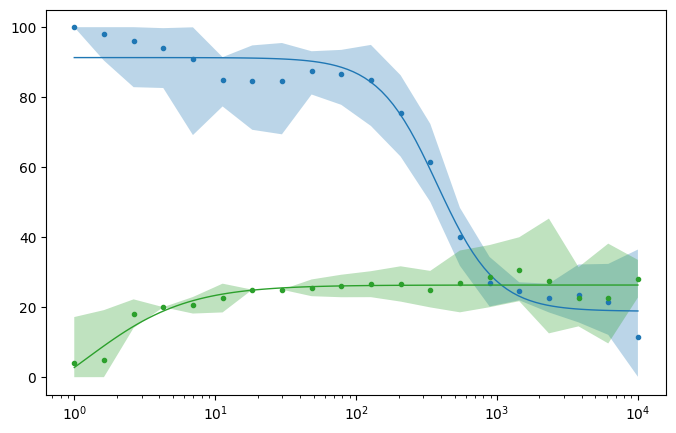

In [22]:
figname = 'temporal_jitter_poker.pdf'
hots.name = initial_name
hots_nohomeo.name = initial_name_nohomeo
standard_temporal_jitter_min = 3
standard_temporal_jitter_max = 7
apply_jitter(standard_temporal_jitter_min, standard_temporal_jitter_max, 'temporal', hots, hots_nohomeo, classif_layer, tau_cla, dataset_name, trainset_output, trainset_output_nohomeo, learning_rate ,betas ,num_epochs, mlr_threshold = mlr_threshold, device = device, verbose=True, figure_name = figname);

In [23]:
results = np.load('../Records/jitter_results/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_10_3_7_None_20.npz')

In [24]:
jitter_values = results['arr_0']
scores_jit = results['arr_1']
scores_jit_histo = results['arr_2']
scores_jit_histo_nohomeo = results['arr_3']

In [25]:
fitting = True
logscale = True
jitter_type = 'temporal'
jitter_values*=1e-3

/home/antoine/homhots/hotsline/hots/utils.py:633: RuntimeWarning: invalid value encountered in double_scalars
  semisat = jitter0**powa
/home/antoine/homhots/hotsline/hots/utils.py:633: RuntimeWarning: invalid value encountered in double_scalars
  semisat = jitter0**powa
/tmp/ipykernel_505793/1634953786.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_t.set_yticklabels(['']*10);


semi saturation level for online HOTS (ours): [] ms
semi saturation level for HOTS with homeostasis: [] ms
semi saturation level for original HOTS: [] ms


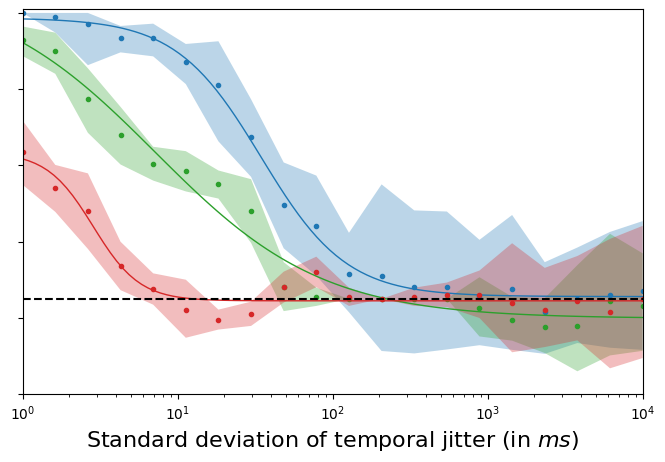

In [26]:
from hots.utils import plotjitter
import matplotlib.pyplot as plt
fig_t, ax_t = plt.subplots(1,1,figsize=(8,5))
colorz = ['#2ca02c','#1f77b4','#d62728']
label = 'online HOTS (ours)'
param_T = [.9, 1/n_classes, 3, 20] # to change to adjust the fit
n_epoch = 33

fig_t, ax_t, semisat_t = plotjitter(fig_t, ax_t, jitter_values, scores_jit, param = param_T, color=colorz[1], label=label, n_epo=n_epoch, fitting = fitting, logscale=logscale)
if fitting:
    print(f'semi saturation level for {label}: {np.round(semisat_t,2)} ms')

label = 'HOTS with homeostasis'
param_T = [.95, 1/n_classes, 2, .1] # to change to adjust the fit
fig_t, ax_t, semisat_t = plotjitter(fig_t, ax_t, jitter_values, scores_jit_histo, param = param_T, color=colorz[0], label=label, n_epo=n_epoch, fitting = fitting, logscale=logscale)
if fitting:
    print(f'semi saturation level for {label}: {np.round(semisat_t,2)} ms')

label = 'original HOTS'
param_T = [.95,1/n_classes, 2, 2] # to change to adjust the fit
fig_t, ax_t, semisat_t = plotjitter(fig_t, ax_t, jitter_values, scores_jit_histo_nohomeo, param = param_T, color=colorz[2], label=label, n_epo=n_epoch, fitting = fitting, logscale=logscale)
if fitting:
    print(f'semi saturation level for {label}: {np.round(semisat_t,2)} ms')

chance_t = np.ones([len(jitter_values)])*100/n_classes
ax_t.plot(jitter_values,chance_t, 'k--', label='chance level')
if jitter_type=='temporal':
    ax_t.axis([1,max(jitter_values),0,101]);
    ax_t.set_xlabel('Standard deviation of temporal jitter (in $ms$)', fontsize=16);
else:
    ax_t.axis([0,max(jitter_values),0,101]);
    ax_t.set_xlabel('Standard deviation of spatial jitter (in $pixels$)', fontsize=16);
#fig_t.legend(loc='upper right');
#ax_t.set_ylabel('Accuracy (in %)', fontsize=16);
ax_t.set_yticklabels(['']*10);

In [27]:
name = 'temporal_jitter_poker.pdf'

dpi_exp = None
bbox = 'tight'
path = '../../manuscript/fig/'
#path = '../../GrimaldiEtAl2020HOTS_clone_laurent/fig'
fig_t.savefig(path+name, dpi = dpi_exp, bbox_inches=bbox, transparent=True)

In [8]:
import torch
a = torch.randint(0,10,[100])
print(a)
print(torch.where(a>5)[0])

tensor([0, 1, 4, 9, 7, 8, 8, 0, 5, 7, 3, 6, 8, 7, 0, 2, 6, 7, 0, 3, 8, 5, 5, 4,
        7, 5, 6, 0, 5, 9, 2, 9, 4, 7, 0, 9, 1, 2, 2, 2, 6, 1, 2, 9, 1, 9, 3, 7,
        6, 8, 2, 9, 0, 6, 7, 6, 0, 3, 2, 9, 4, 9, 8, 8, 4, 9, 5, 7, 8, 8, 9, 8,
        3, 3, 4, 0, 5, 5, 6, 6, 8, 2, 5, 0, 3, 0, 3, 7, 8, 5, 1, 2, 1, 1, 5, 0,
        0, 2, 8, 7])
tensor([ 3,  4,  5,  6,  9, 11, 12, 13, 16, 17, 20, 24, 26, 29, 31, 33, 35, 40,
        43, 45, 47, 48, 49, 51, 53, 54, 55, 59, 61, 62, 63, 65, 67, 68, 69, 70,
        71, 78, 79, 80, 87, 88, 98, 99])
